## Environment Construction

In [138]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
# Pretty Plots
import matplotlib
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family='serif', serif=['Palatino'])
sns.set(font='serif', font_scale=1.4)
sns.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})
def setup_plot():
    fig = plt.figure(dpi=100, figsize=(5.0,3.0))
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)
    ax.tick_params(direction='in')

In [266]:
import highway_env
import gym.spaces
import numpy as np
from highway_env.vehicle.behavior import IDMVehicle
from highway_env.envs.common.observation import KinematicObservation

def get_state(env):
    return KinematicObservation(env.env).observe()[0][:-1]

def _make_vehicles(self):
    """
    Populate a road with several vehicles on the highway and on the merging lane, as well as an ego-vehicle.
    """
    rng = self.np_random

    # Controlled vehicles
    self.controlled_vehicles = []
    for i in range(self.config["controlled_vehicles"]):
        lane_index = ("a", "b", rng.randint(2)) if i == 0 else \
            self.road.network.random_lane_index(rng)
        controlled_vehicle = self.action_type.vehicle_class.make_on_lane(self.road, lane_index, speed=None,
                                                                         longitudinal=rng.uniform(20, 50))

        self.controlled_vehicles.append(controlled_vehicle)
        self.road.vehicles.append(controlled_vehicle)
        

class NoisyRaceTrack(gym.Env):
    def __init__(self, kin_obs=False, eps=0.075):
        self.env = gym.make("racetrack-v0")
        self.env._make_vehicles = lambda: _make_vehicles(self.env)
        self.env.configure({
            "other_vehicles": 0,
            "show_trajectories": True,
        })
        if kin_obs:
            self.env.configure({"observation": {"type": "Kinematics"}})
            self.observation_space = gym.spaces.Box(-100*np.ones(4), 100*np.ones(4))
        else:
            self.observation_space = self.env.observation_space
        self.action_space = gym.spaces.Box(-np.ones(1), np.ones(1))
        self.t = 0
        self.u = 0
        self.noise_steps = 0
        self.eps = eps
        self.kin_obs = kin_obs
        self.env.reset()
    def reset(self):
        self.t = 0
        self.u = 0
        self.noise_steps = 0
        self.env.reset()
        return env.step(np.array([0]))[0]
    def close(self):
        return self.env.close()
    def render(self, mode='human'):
        return self.env.render(mode=mode)
    def rad_process(self):
        # Rademacher noise for 3 timesteps
        if self.noise_steps == 0:
            if np.random.uniform() < self.eps:
                self.u = (np.random.binomial(n=1, p=0.5) * 4.0) - 2.0
                self.noise_steps = 3
            else:
                self.u = 0
        else:
            self.noise_steps -= 1
    def step(self, action):
        if self.t == 0:
            self.env.reset()
        self.rad_process()
        action = np.clip(action + self.u, -1, +1)
        next_obs, reward, done, info = self.env.step(action)
        self.t += 1
        if self.kin_obs:
            return next_obs[0][:-1], reward, done, info
        else:
            return next_obs, reward, done, info

In [267]:
env = NoisyRaceTrack()

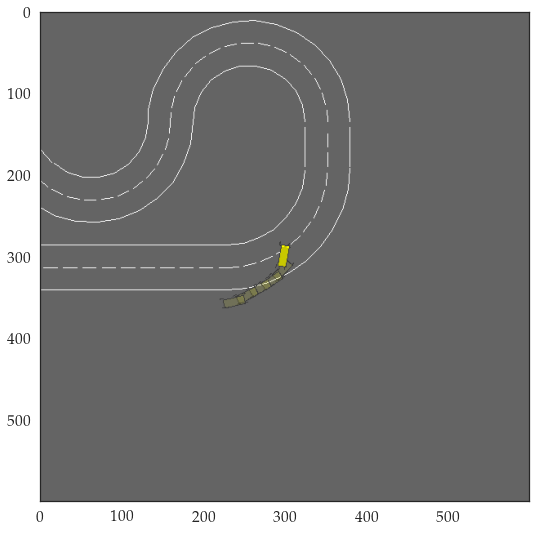

In [268]:
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array'))
for _ in range(20):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = np.random.normal(size=1)
    env.step(action)
env.close()

In [269]:
print(env.action_space)
print(env.observation_space)

Box(-1.0, 1.0, (1,), float32)
Box(-inf, inf, (2, 12, 12), float32)


## Expert Training

In [270]:
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.evaluation import evaluate_policy

In [271]:
# model = PPO('MlpPolicy', env, verbose=1, policy_kwargs=dict(net_arch=[256, 256]), use_sde=False)

In [272]:
model = PPO("MlpPolicy",
            env,
            policy_kwargs=dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
            n_steps=64 * 12,
            batch_size=64,
            n_epochs=10,
            learning_rate=5e-4,
            gamma=0.9,
            verbose=2)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [273]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

In [274]:
print(mean_reward, std_reward)

12.375576 6.1844864


In [275]:
model.learn(total_timesteps=2e5)

----------------------------
| time/              |     |
|    fps             | 25  |
|    iterations      | 1   |
|    time_elapsed    | 30  |
|    total_timesteps | 768 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 61           |
|    total_timesteps      | 1536         |
| train/                  |              |
|    approx_kl            | -0.010562703 |
|    clip_fraction        | 0.0672       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | -13.8        |
|    learning_rate        | 0.0005       |
|    loss                 | -0.0345      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0298      |
|    std                  | 0.953        |
|    value_loss           | 0.0881       |
-----------------------

----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 13         |
|    time_elapsed         | 390        |
|    total_timesteps      | 9984       |
| train/                  |            |
|    approx_kl            | 0.07072728 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.16      |
|    explained_variance   | 0.784      |
|    learning_rate        | 0.0005     |
|    loss                 | -0.00257   |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.04      |
|    std                  | 0.76       |
|    value_loss           | 0.286      |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 25         |
|    iterations           | 14         |
|    time_elapsed         | 418        |
|    total_times

---------------------------------------
| time/                   |           |
|    fps                  | 26        |
|    iterations           | 24        |
|    time_elapsed         | 705       |
|    total_timesteps      | 18432     |
| train/                  |           |
|    approx_kl            | 0.0770471 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.977    |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.0332    |
|    n_updates            | 230       |
|    policy_gradient_loss | -0.0421   |
|    std                  | 0.639     |
|    value_loss           | 0.509     |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 25          |
|    time_elapsed         | 734         |
|    total_timesteps      | 19

----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 35         |
|    time_elapsed         | 1018       |
|    total_timesteps      | 26880      |
| train/                  |            |
|    approx_kl            | 0.07104051 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.739     |
|    explained_variance   | 0.577      |
|    learning_rate        | 0.0005     |
|    loss                 | 0.271      |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.0505    |
|    std                  | 0.506      |
|    value_loss           | 0.867      |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 36         |
|    time_elapsed         | 1046       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 26          |
|    iterations           | 46          |
|    time_elapsed         | 1329        |
|    total_timesteps      | 35328       |
| train/                  |             |
|    approx_kl            | 0.107073806 |
|    clip_fraction        | 0.395       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.494      |
|    explained_variance   | 0.191       |
|    learning_rate        | 0.0005      |
|    loss                 | 0.225       |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.0427     |
|    std                  | 0.391       |
|    value_loss           | 0.919       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 47         |
|    time_elapsed         | 1357      

----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 57         |
|    time_elapsed         | 1639       |
|    total_timesteps      | 43776      |
| train/                  |            |
|    approx_kl            | 0.22265494 |
|    clip_fraction        | 0.471      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | -0.212     |
|    learning_rate        | 0.0005     |
|    loss                 | 0.234      |
|    n_updates            | 560        |
|    policy_gradient_loss | -0.0593    |
|    std                  | 0.286      |
|    value_loss           | 0.885      |
----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 26        |
|    iterations           | 58        |
|    time_elapsed         | 1667      |
|    total_timesteps 

---------------------------------------
| time/                   |           |
|    fps                  | 26        |
|    iterations           | 68        |
|    time_elapsed         | 1948      |
|    total_timesteps      | 52224     |
| train/                  |           |
|    approx_kl            | 0.2559023 |
|    clip_fraction        | 0.509     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.0678    |
|    explained_variance   | 0.291     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.146     |
|    n_updates            | 670       |
|    policy_gradient_loss | -0.055    |
|    std                  | 0.222     |
|    value_loss           | 0.77      |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 69         |
|    time_elapsed         | 1976       |
|    total_timesteps      | 52992  

----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 79         |
|    time_elapsed         | 2256       |
|    total_timesteps      | 60672      |
| train/                  |            |
|    approx_kl            | 0.45174515 |
|    clip_fraction        | 0.521      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.313      |
|    explained_variance   | -0.138     |
|    learning_rate        | 0.0005     |
|    loss                 | 0.151      |
|    n_updates            | 780        |
|    policy_gradient_loss | -0.0476    |
|    std                  | 0.174      |
|    value_loss           | 0.938      |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 80         |
|    time_elapsed         | 2284       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 90         |
|    time_elapsed         | 2564       |
|    total_timesteps      | 69120      |
| train/                  |            |
|    approx_kl            | 0.47452652 |
|    clip_fraction        | 0.565      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.572      |
|    explained_variance   | 0.127      |
|    learning_rate        | 0.0005     |
|    loss                 | 0.242      |
|    n_updates            | 890        |
|    policy_gradient_loss | -0.0377    |
|    std                  | 0.135      |
|    value_loss           | 0.813      |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 91         |
|    time_elapsed         | 2592       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 26         |
|    iterations           | 101        |
|    time_elapsed         | 2873       |
|    total_timesteps      | 77568      |
| train/                  |            |
|    approx_kl            | 0.28455856 |
|    clip_fraction        | 0.464      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.759      |
|    explained_variance   | 0.526      |
|    learning_rate        | 0.0005     |
|    loss                 | 0.0784     |
|    n_updates            | 1000       |
|    policy_gradient_loss | -0.0214    |
|    std                  | 0.111      |
|    value_loss           | 0.518      |
----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 102       |
|    time_elapsed         | 2900      |
|    total_timesteps 

---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 112       |
|    time_elapsed         | 3180      |
|    total_timesteps      | 86016     |
| train/                  |           |
|    approx_kl            | 0.7466721 |
|    clip_fraction        | 0.615     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.903     |
|    explained_variance   | 0.099     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.231     |
|    n_updates            | 1110      |
|    policy_gradient_loss | -0.00818  |
|    std                  | 0.0981    |
|    value_loss           | 0.769     |
---------------------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 27       |
|    iterations           | 113      |
|    time_elapsed         | 3207     |
|    total_timesteps      | 86784    |
| trai

---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 123       |
|    time_elapsed         | 3487      |
|    total_timesteps      | 94464     |
| train/                  |           |
|    approx_kl            | 1.0917175 |
|    clip_fraction        | 0.676     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1         |
|    explained_variance   | 0.198     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.201     |
|    n_updates            | 1220      |
|    policy_gradient_loss | 0.0213    |
|    std                  | 0.0899    |
|    value_loss           | 0.861     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 124       |
|    time_elapsed         | 3515      |
|    total_timesteps      | 95232     |


---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 134       |
|    time_elapsed         | 3795      |
|    total_timesteps      | 102912    |
| train/                  |           |
|    approx_kl            | 1.2100801 |
|    clip_fraction        | 0.675     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.14      |
|    explained_variance   | 0.0678    |
|    learning_rate        | 0.0005    |
|    loss                 | 0.141     |
|    n_updates            | 1330      |
|    policy_gradient_loss | 0.00586   |
|    std                  | 0.0773    |
|    value_loss           | 0.785     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 135       |
|    time_elapsed         | 3823      |
|    total_timesteps      | 103680    |


---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 145       |
|    time_elapsed         | 4104      |
|    total_timesteps      | 111360    |
| train/                  |           |
|    approx_kl            | 1.0006895 |
|    clip_fraction        | 0.633     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.13      |
|    explained_variance   | 0.75      |
|    learning_rate        | 0.0005    |
|    loss                 | 0.0895    |
|    n_updates            | 1440      |
|    policy_gradient_loss | 0.0357    |
|    std                  | 0.079     |
|    value_loss           | 0.363     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 146       |
|    time_elapsed         | 4132      |
|    total_timesteps      | 112128    |


---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 156       |
|    time_elapsed         | 4411      |
|    total_timesteps      | 119808    |
| train/                  |           |
|    approx_kl            | 1.6520494 |
|    clip_fraction        | 0.633     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.19      |
|    explained_variance   | 0.213     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.085     |
|    n_updates            | 1550      |
|    policy_gradient_loss | -0.023    |
|    std                  | 0.0719    |
|    value_loss           | 0.661     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 157       |
|    time_elapsed         | 4439      |
|    total_timesteps      | 120576    |


---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 167       |
|    time_elapsed         | 4720      |
|    total_timesteps      | 128256    |
| train/                  |           |
|    approx_kl            | 1.2985841 |
|    clip_fraction        | 0.63      |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.21      |
|    explained_variance   | 0.338     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.128     |
|    n_updates            | 1660      |
|    policy_gradient_loss | -0.00116  |
|    std                  | 0.072     |
|    value_loss           | 0.625     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 168       |
|    time_elapsed         | 4748      |
|    total_timesteps      | 129024    |


---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 178       |
|    time_elapsed         | 5027      |
|    total_timesteps      | 136704    |
| train/                  |           |
|    approx_kl            | 1.1467974 |
|    clip_fraction        | 0.598     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.22      |
|    explained_variance   | 0.356     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.215     |
|    n_updates            | 1770      |
|    policy_gradient_loss | -0.000288 |
|    std                  | 0.071     |
|    value_loss           | 0.815     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 179       |
|    time_elapsed         | 5054      |
|    total_timesteps      | 137472    |


--------------------------------------
| time/                   |          |
|    fps                  | 27       |
|    iterations           | 189      |
|    time_elapsed         | 5334     |
|    total_timesteps      | 145152   |
| train/                  |          |
|    approx_kl            | 0.707279 |
|    clip_fraction        | 0.498    |
|    clip_range           | 0.2      |
|    entropy_loss         | 1.26     |
|    explained_variance   | 0.741    |
|    learning_rate        | 0.0005   |
|    loss                 | 0.0437   |
|    n_updates            | 1880     |
|    policy_gradient_loss | 0.019    |
|    std                  | 0.0688   |
|    value_loss           | 0.397    |
--------------------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 27       |
|    iterations           | 190      |
|    time_elapsed         | 5362     |
|    total_timesteps      | 145920   |
| train/                 

---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 200       |
|    time_elapsed         | 5641      |
|    total_timesteps      | 153600    |
| train/                  |           |
|    approx_kl            | 1.2874923 |
|    clip_fraction        | 0.634     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.33      |
|    explained_variance   | 0.196     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.125     |
|    n_updates            | 1990      |
|    policy_gradient_loss | -0.00934  |
|    std                  | 0.0635    |
|    value_loss           | 0.722     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 201       |
|    time_elapsed         | 5669      |
|    total_timesteps      | 154368    |


---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 211       |
|    time_elapsed         | 5947      |
|    total_timesteps      | 162048    |
| train/                  |           |
|    approx_kl            | 0.8721102 |
|    clip_fraction        | 0.62      |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.36      |
|    explained_variance   | 0.665     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.1       |
|    n_updates            | 2100      |
|    policy_gradient_loss | 0.0052    |
|    std                  | 0.0623    |
|    value_loss           | 0.538     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 212       |
|    time_elapsed         | 5975      |
|    total_timesteps      | 162816    |


---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 222       |
|    time_elapsed         | 6254      |
|    total_timesteps      | 170496    |
| train/                  |           |
|    approx_kl            | 1.0553862 |
|    clip_fraction        | 0.634     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.42      |
|    explained_variance   | 0.323     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.218     |
|    n_updates            | 2210      |
|    policy_gradient_loss | -0.00165  |
|    std                  | 0.0584    |
|    value_loss           | 0.786     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 223       |
|    time_elapsed         | 6282      |
|    total_timesteps      | 171264    |


---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 233       |
|    time_elapsed         | 6561      |
|    total_timesteps      | 178944    |
| train/                  |           |
|    approx_kl            | 1.1889123 |
|    clip_fraction        | 0.665     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.42      |
|    explained_variance   | 0.0548    |
|    learning_rate        | 0.0005    |
|    loss                 | 0.166     |
|    n_updates            | 2320      |
|    policy_gradient_loss | 0.0155    |
|    std                  | 0.0587    |
|    value_loss           | 0.754     |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 27         |
|    iterations           | 234        |
|    time_elapsed         | 6588       |
|    total_timesteps      | 179712 

---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 244       |
|    time_elapsed         | 6867      |
|    total_timesteps      | 187392    |
| train/                  |           |
|    approx_kl            | 1.0187113 |
|    clip_fraction        | 0.642     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.43      |
|    explained_variance   | 0.367     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.115     |
|    n_updates            | 2430      |
|    policy_gradient_loss | 0.0191    |
|    std                  | 0.0574    |
|    value_loss           | 0.747     |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 245       |
|    time_elapsed         | 6895      |
|    total_timesteps      | 188160    |


---------------------------------------
| time/                   |           |
|    fps                  | 27        |
|    iterations           | 255       |
|    time_elapsed         | 7173      |
|    total_timesteps      | 195840    |
| train/                  |           |
|    approx_kl            | 1.0667553 |
|    clip_fraction        | 0.618     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.4       |
|    explained_variance   | 0.51      |
|    learning_rate        | 0.0005    |
|    loss                 | 0.108     |
|    n_updates            | 2540      |
|    policy_gradient_loss | 0.00137   |
|    std                  | 0.0587    |
|    value_loss           | 0.698     |
---------------------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 27       |
|    iterations           | 256      |
|    time_elapsed         | 7201     |
|    total_timesteps      | 196608   |
| trai

In [276]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

In [277]:
print(mean_reward, std_reward)

110.53959 17.109356


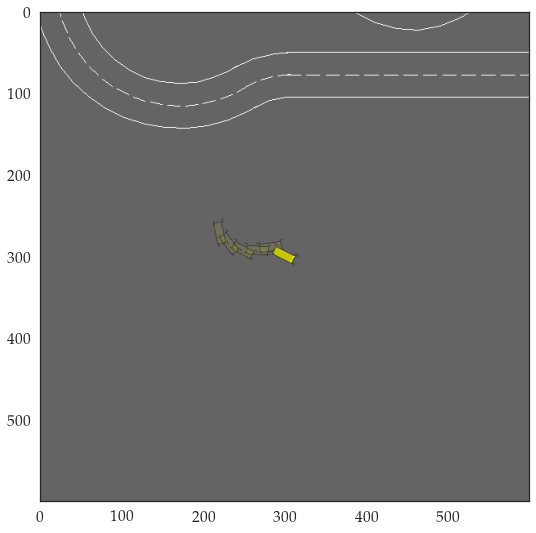

In [278]:
obs = env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array'))
for _ in range(300):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action, _ = model.predict(obs, deterministic=True)
    obs, _, _, _, = env.step(action)
env.close()

In [279]:
action

array([-0.7523715], dtype=float32)

In [280]:
# model.learn(total_timesteps=9e5)

In [281]:
# mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

In [282]:
# print(mean_reward, std_reward)

In [283]:
# obs = env.reset()
# plt.figure(figsize=(9,9))
# img = plt.imshow(env.render(mode='rgb_array'))
# for _ in range(300):
#     img.set_data(env.render(mode='rgb_array'))
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action, _ = model.predict(obs, deterministic=True)#np.random.normal(size=1)
#     obs, _, _, _, = env.step(action)
# env.close()

In [284]:
# model.save("./nr_expert_noisy_1")

In [285]:
# model.learn(total_timesteps=1e6)

In [286]:
# mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

In [287]:
# print(mean_reward, std_reward)

In [288]:
# obs = env.reset()
# plt.figure(figsize=(9,9))
# img = plt.imshow(env.render(mode='rgb_array'))
# for _ in range(300):
#     img.set_data(env.render(mode='rgb_array'))
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action, _ = model.predict(obs, deterministic=True)#np.random.normal(size=1)
#     obs, _, _, _, = env.step(action)
# env.close()

In [289]:
model.save("./nr_expert_rad")

## IL

In [290]:
import os

In [291]:
def gen_expert_demos(env, model, num_trajs):
    trajs = dict()
    rewards = []
    for traj in range(num_trajs):
        total_reward = 0
        obs = env.reset()
        done = False
        states = []
        actions = []
        while not done:
            states.append(obs)
            action, _state = model.predict(obs, deterministic=True)
            actions.append(action)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break
        trajs[str(traj)] = {'states': np.array(
            states), 'actions': np.array(actions)}
        rewards.append(total_reward)
    print("Avg Reward:", np.mean(rewards))
    np.savez('demos',
             num_trajs=num_trajs,
             mean_reward=np.mean(rewards),
             std_reward=np.std(rewards),
             **trajs)

In [292]:
gen_expert_demos(env, model, 25)

Avg Reward: 96.4374945373131


In [293]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from itertools import chain
from typing import Callable, Union, Type, Optional, Dict, Any

In [294]:
class SADataset(torch.utils.data.Dataset):
    def __init__(self, obs, acts, normalize):
        if normalize:
            obs = np.array(obs)
            self.mean = obs.mean(axis=0)
            self.std = obs.std(axis=0) + 1e-3
            obs = (obs - self.mean) / (self.std)
            self.is_normalized = True
        else:
            self.is_normalized = False
        self.obs = torch.tensor(obs)
        self.acts = torch.tensor(acts)

    def __len__(self):
        return len(self.obs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        obs = self.obs[idx]
        acts = self.acts[idx]
        sample = {'obs': obs, 'acts': acts}
        return sample
                          
def make_sa_dataloader(path, max_trajs=None, normalize=True, batch_size=32):
    demos = np.load("{0}.npz".format(path), allow_pickle=True)
    num_trajs = demos["num_trajs"]
    if max_trajs is None:
        max_trajs = num_trajs
    obs = []
    acts = []
    for traj in range(min(max_trajs, num_trajs)):
        obs.extend(demos[str(traj)].item()['states'])
        acts.extend(demos[str(traj)].item()['actions'])
    dataset = SADataset(obs, acts, normalize)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                             shuffle=True, num_workers=0)
    return dataloader

In [295]:
from imitation.algorithms import adversarial, bc
from stable_baselines3.common import policies
from stable_baselines3.common.evaluation import evaluate_policy

In [296]:
expert_data = make_sa_dataloader("demos", max_trajs=18, normalize=False)

In [297]:
bc_trainer = bc.BC(env.observation_space, env.action_space, expert_data=expert_data,
                   policy_class=policies.ActorCriticPolicy,
                   ent_weight=0., l2_weight=0., policy_kwargs=dict(net_arch=[256, 256]))

In [298]:
bc_trainer.train(n_batches=int(5e5))

---------------------------------------
| batch_num               | 1         |
| ent_loss                | -0        |
| entropy                 | 1.42      |
| epoch_num               | 0         |
| l2_loss                 | 0         |
| l2_norm                 | 513       |
| loss                    | 1.29      |
| neglogp                 | 1.29      |
| prob_true_act           | 0.279     |
| samples_so_far          | 32        |
| train/                  |           |
|    approx_kl            | 2.5253456 |
|    clip_fraction        | 0.703     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.45      |
|    explained_variance   | 0.641     |
|    learning_rate        | 0.0005    |
|    loss                 | 0.126     |
|    n_updates            | 2610      |
|    policy_gradient_loss | 0.0704    |
|    std                  | 0.0576    |
|    value_loss           | 0.42      |
---------------------------------------
-----------------------------
| batch_nu

-----------------------------
| batch_num      | 2201     |
| ent_loss       | 0        |
| entropy        | -0.651   |
| epoch_num      | 13       |
| l2_loss        | 0        |
| l2_norm        | 678      |
| loss           | -1.04    |
| neglogp        | -1.04    |
| prob_true_act  | 2.9      |
| samples_so_far | 70094    |
-----------------------------
-----------------------------
| batch_num      | 2301     |
| ent_loss       | 0        |
| entropy        | -0.731   |
| epoch_num      | 13       |
| l2_loss        | 0        |
| l2_norm        | 684      |
| loss           | -1.16    |
| neglogp        | -1.16    |
| prob_true_act  | 3.2      |
| samples_so_far | 73294    |
-----------------------------
-----------------------------
| batch_num      | 2401     |
| ent_loss       | 0        |
| entropy        | -0.807   |
| epoch_num      | 14       |
| l2_loss        | 0        |
| l2_norm        | 690      |
| loss           | -0.896   |
| neglogp        | -0.896   |
| prob_tru

-----------------------------
| batch_num      | 4501     |
| ent_loss       | 0        |
| entropy        | -1.6     |
| epoch_num      | 26       |
| l2_loss        | 0        |
| l2_norm        | 786      |
| loss           | -1.09    |
| neglogp        | -1.09    |
| prob_true_act  | 5.85     |
| samples_so_far | 143356   |
-----------------------------
-----------------------------
| batch_num      | 4601     |
| ent_loss       | 0        |
| entropy        | -1.63    |
| epoch_num      | 27       |
| l2_loss        | 0        |
| l2_norm        | 790      |
| loss           | -1.29    |
| neglogp        | -1.29    |
| prob_true_act  | 6.04     |
| samples_so_far | 146530   |
-----------------------------
-----------------------------
| batch_num      | 4701     |
| ent_loss       | 0        |
| entropy        | -1.64    |
| epoch_num      | 27       |
| l2_loss        | 0        |
| l2_norm        | 793      |
| loss           | -1.74    |
| neglogp        | -1.74    |
| prob_tru

-----------------------------
| batch_num      | 6801     |
| ent_loss       | 0        |
| entropy        | -1.92    |
| epoch_num      | 40       |
| l2_loss        | 0        |
| l2_norm        | 847      |
| loss           | -2       |
| neglogp        | -2       |
| prob_true_act  | 8.59     |
| samples_so_far | 216592   |
-----------------------------
-----------------------------
| batch_num      | 6901     |
| ent_loss       | 0        |
| entropy        | -1.9     |
| epoch_num      | 40       |
| l2_loss        | 0        |
| l2_norm        | 851      |
| loss           | -2.19    |
| neglogp        | -2.19    |
| prob_true_act  | 9.56     |
| samples_so_far | 219792   |
-----------------------------
-----------------------------
| batch_num      | 7001     |
| ent_loss       | 0        |
| entropy        | -1.95    |
| epoch_num      | 41       |
| l2_loss        | 0        |
| l2_norm        | 852      |
| loss           | -2.03    |
| neglogp        | -2.03    |
| prob_tru

-----------------------------
| batch_num      | 9101     |
| ent_loss       | 0        |
| entropy        | -2.13    |
| epoch_num      | 53       |
| l2_loss        | 0        |
| l2_norm        | 898      |
| loss           | -1.63    |
| neglogp        | -1.63    |
| prob_true_act  | 10.3     |
| samples_so_far | 289854   |
-----------------------------
-----------------------------
| batch_num      | 9201     |
| ent_loss       | 0        |
| entropy        | -2.13    |
| epoch_num      | 54       |
| l2_loss        | 0        |
| l2_norm        | 901      |
| loss           | -1.2     |
| neglogp        | -1.2     |
| prob_true_act  | 10.3     |
| samples_so_far | 293028   |
-----------------------------
-----------------------------
| batch_num      | 9301     |
| ent_loss       | 0        |
| entropy        | -2.16    |
| epoch_num      | 55       |
| l2_loss        | 0        |
| l2_norm        | 903      |
| loss           | -2.06    |
| neglogp        | -2.06    |
| prob_tru

-----------------------------
| batch_num      | 11401    |
| ent_loss       | 0        |
| entropy        | -2.24    |
| epoch_num      | 67       |
| l2_loss        | 0        |
| l2_norm        | 950      |
| loss           | -2.01    |
| neglogp        | -2.01    |
| prob_true_act  | 11.4     |
| samples_so_far | 363090   |
-----------------------------
-----------------------------
| batch_num      | 11501    |
| ent_loss       | 0        |
| entropy        | -2.25    |
| epoch_num      | 68       |
| l2_loss        | 0        |
| l2_norm        | 952      |
| loss           | -2.13    |
| neglogp        | -2.13    |
| prob_true_act  | 13.1     |
| samples_so_far | 366264   |
-----------------------------
-----------------------------
| batch_num      | 11601    |
| ent_loss       | 0        |
| entropy        | -2.28    |
| epoch_num      | 68       |
| l2_loss        | 0        |
| l2_norm        | 954      |
| loss           | -2.5     |
| neglogp        | -2.5     |
| prob_tru

-----------------------------
| batch_num      | 13701    |
| ent_loss       | 0        |
| entropy        | -2.39    |
| epoch_num      | 81       |
| l2_loss        | 0        |
| l2_norm        | 1e+03    |
| loss           | -2.3     |
| neglogp        | -2.3     |
| prob_true_act  | 12       |
| samples_so_far | 436326   |
-----------------------------
-----------------------------
| batch_num      | 13801    |
| ent_loss       | 0        |
| entropy        | -2.36    |
| epoch_num      | 81       |
| l2_loss        | 0        |
| l2_norm        | 1e+03    |
| loss           | -2.51    |
| neglogp        | -2.51    |
| prob_true_act  | 13.7     |
| samples_so_far | 439526   |
-----------------------------
-----------------------------
| batch_num      | 13901    |
| ent_loss       | 0        |
| entropy        | -2.38    |
| epoch_num      | 82       |
| l2_loss        | 0        |
| l2_norm        | 1.01e+03 |
| loss           | -2.16    |
| neglogp        | -2.16    |
| prob_tru

-----------------------------
| batch_num      | 16001    |
| ent_loss       | 0        |
| entropy        | -2.43    |
| epoch_num      | 94       |
| l2_loss        | 0        |
| l2_norm        | 1.06e+03 |
| loss           | -2.5     |
| neglogp        | -2.5     |
| prob_true_act  | 15.9     |
| samples_so_far | 509588   |
-----------------------------
-----------------------------
| batch_num      | 16101    |
| ent_loss       | 0        |
| entropy        | -2.44    |
| epoch_num      | 95       |
| l2_loss        | 0        |
| l2_norm        | 1.06e+03 |
| loss           | -2.64    |
| neglogp        | -2.64    |
| prob_true_act  | 15.4     |
| samples_so_far | 512762   |
-----------------------------
-----------------------------
| batch_num      | 16201    |
| ent_loss       | 0        |
| entropy        | -2.45    |
| epoch_num      | 95       |
| l2_loss        | 0        |
| l2_norm        | 1.06e+03 |
| loss           | -2.59    |
| neglogp        | -2.59    |
| prob_tru

-----------------------------
| batch_num      | 18301    |
| ent_loss       | 0        |
| entropy        | -2.57    |
| epoch_num      | 108      |
| l2_loss        | 0        |
| l2_norm        | 1.11e+03 |
| loss           | -2.57    |
| neglogp        | -2.57    |
| prob_true_act  | 16.5     |
| samples_so_far | 582824   |
-----------------------------
-----------------------------
| batch_num      | 18401    |
| ent_loss       | 0        |
| entropy        | -2.61    |
| epoch_num      | 108      |
| l2_loss        | 0        |
| l2_norm        | 1.11e+03 |
| loss           | -2.87    |
| neglogp        | -2.87    |
| prob_true_act  | 18.7     |
| samples_so_far | 586024   |
-----------------------------
-----------------------------
| batch_num      | 18501    |
| ent_loss       | 0        |
| entropy        | -2.61    |
| epoch_num      | 109      |
| l2_loss        | 0        |
| l2_norm        | 1.11e+03 |
| loss           | -2.08    |
| neglogp        | -2.08    |
| prob_tru

-----------------------------
| batch_num      | 20601    |
| ent_loss       | 0        |
| entropy        | -2.55    |
| epoch_num      | 121      |
| l2_loss        | 0        |
| l2_norm        | 1.17e+03 |
| loss           | -2.95    |
| neglogp        | -2.95    |
| prob_true_act  | 19.5     |
| samples_so_far | 656086   |
-----------------------------
-----------------------------
| batch_num      | 20701    |
| ent_loss       | 0        |
| entropy        | -2.61    |
| epoch_num      | 122      |
| l2_loss        | 0        |
| l2_norm        | 1.17e+03 |
| loss           | -2.65    |
| neglogp        | -2.65    |
| prob_true_act  | 17.7     |
| samples_so_far | 659260   |
-----------------------------
-----------------------------
| batch_num      | 20801    |
| ent_loss       | 0        |
| entropy        | -2.66    |
| epoch_num      | 123      |
| l2_loss        | 0        |
| l2_norm        | 1.17e+03 |
| loss           | -2.32    |
| neglogp        | -2.32    |
| prob_tru

-----------------------------
| batch_num      | 22901    |
| ent_loss       | 0        |
| entropy        | -2.64    |
| epoch_num      | 135      |
| l2_loss        | 0        |
| l2_norm        | 1.22e+03 |
| loss           | -2.85    |
| neglogp        | -2.85    |
| prob_true_act  | 18.6     |
| samples_so_far | 729322   |
-----------------------------
-----------------------------
| batch_num      | 23001    |
| ent_loss       | 0        |
| entropy        | -2.64    |
| epoch_num      | 136      |
| l2_loss        | 0        |
| l2_norm        | 1.23e+03 |
| loss           | -2.62    |
| neglogp        | -2.62    |
| prob_true_act  | 16.5     |
| samples_so_far | 732496   |
-----------------------------
-----------------------------
| batch_num      | 23101    |
| ent_loss       | 0        |
| entropy        | -2.68    |
| epoch_num      | 136      |
| l2_loss        | 0        |
| l2_norm        | 1.23e+03 |
| loss           | -2.79    |
| neglogp        | -2.79    |
| prob_tru

-----------------------------
| batch_num      | 25201    |
| ent_loss       | 0        |
| entropy        | -2.65    |
| epoch_num      | 149      |
| l2_loss        | 0        |
| l2_norm        | 1.28e+03 |
| loss           | -2.65    |
| neglogp        | -2.65    |
| prob_true_act  | 16.5     |
| samples_so_far | 802558   |
-----------------------------
-----------------------------
| batch_num      | 25301    |
| ent_loss       | 0        |
| entropy        | -2.68    |
| epoch_num      | 149      |
| l2_loss        | 0        |
| l2_norm        | 1.28e+03 |
| loss           | -2.61    |
| neglogp        | -2.61    |
| prob_true_act  | 18.8     |
| samples_so_far | 805758   |
-----------------------------
-----------------------------
| batch_num      | 25401    |
| ent_loss       | 0        |
| entropy        | -2.72    |
| epoch_num      | 150      |
| l2_loss        | 0        |
| l2_norm        | 1.28e+03 |
| loss           | -2.79    |
| neglogp        | -2.79    |
| prob_tru

-----------------------------
| batch_num      | 27501    |
| ent_loss       | 0        |
| entropy        | -2.73    |
| epoch_num      | 162      |
| l2_loss        | 0        |
| l2_norm        | 1.34e+03 |
| loss           | -2.69    |
| neglogp        | -2.69    |
| prob_true_act  | 17.8     |
| samples_so_far | 875820   |
-----------------------------
-----------------------------
| batch_num      | 27601    |
| ent_loss       | 0        |
| entropy        | -2.57    |
| epoch_num      | 163      |
| l2_loss        | 0        |
| l2_norm        | 1.35e+03 |
| loss           | -2.02    |
| neglogp        | -2.02    |
| prob_true_act  | 14.8     |
| samples_so_far | 878994   |
-----------------------------
-----------------------------
| batch_num      | 27701    |
| ent_loss       | 0        |
| entropy        | -2.54    |
| epoch_num      | 163      |
| l2_loss        | 0        |
| l2_norm        | 1.35e+03 |
| loss           | -2.29    |
| neglogp        | -2.29    |
| prob_tru

-----------------------------
| batch_num      | 29801    |
| ent_loss       | 0        |
| entropy        | -2.66    |
| epoch_num      | 176      |
| l2_loss        | 0        |
| l2_norm        | 1.4e+03  |
| loss           | -2.96    |
| neglogp        | -2.96    |
| prob_true_act  | 20.2     |
| samples_so_far | 949056   |
-----------------------------
-----------------------------
| batch_num      | 29901    |
| ent_loss       | 0        |
| entropy        | -2.72    |
| epoch_num      | 176      |
| l2_loss        | 0        |
| l2_norm        | 1.4e+03  |
| loss           | -3.07    |
| neglogp        | -3.07    |
| prob_true_act  | 22.6     |
| samples_so_far | 952256   |
-----------------------------
-----------------------------
| batch_num      | 30001    |
| ent_loss       | 0        |
| entropy        | -2.78    |
| epoch_num      | 177      |
| l2_loss        | 0        |
| l2_norm        | 1.4e+03  |
| loss           | -3.15    |
| neglogp        | -3.15    |
| prob_tru

-----------------------------
| batch_num      | 32101    |
| ent_loss       | 0        |
| entropy        | -2.74    |
| epoch_num      | 189      |
| l2_loss        | 0        |
| l2_norm        | 1.45e+03 |
| loss           | -3.09    |
| neglogp        | -3.09    |
| prob_true_act  | 23       |
| samples_so_far | 1022318  |
-----------------------------
-----------------------------
| batch_num      | 32201    |
| ent_loss       | 0        |
| entropy        | -2.79    |
| epoch_num      | 190      |
| l2_loss        | 0        |
| l2_norm        | 1.45e+03 |
| loss           | -3.14    |
| neglogp        | -3.14    |
| prob_true_act  | 23.8     |
| samples_so_far | 1025492  |
-----------------------------
-----------------------------
| batch_num      | 32301    |
| ent_loss       | 0        |
| entropy        | -2.83    |
| epoch_num      | 191      |
| l2_loss        | 0        |
| l2_norm        | 1.45e+03 |
| loss           | -3.2     |
| neglogp        | -3.2     |
| prob_tru

-----------------------------
| batch_num      | 34401    |
| ent_loss       | 0        |
| entropy        | -2.82    |
| epoch_num      | 203      |
| l2_loss        | 0        |
| l2_norm        | 1.5e+03  |
| loss           | -2.73    |
| neglogp        | -2.73    |
| prob_true_act  | 20       |
| samples_so_far | 1095554  |
-----------------------------
-----------------------------
| batch_num      | 34501    |
| ent_loss       | 0        |
| entropy        | -2.82    |
| epoch_num      | 204      |
| l2_loss        | 0        |
| l2_norm        | 1.5e+03  |
| loss           | -3.04    |
| neglogp        | -3.04    |
| prob_true_act  | 24.3     |
| samples_so_far | 1098728  |
-----------------------------
-----------------------------
| batch_num      | 34601    |
| ent_loss       | 0        |
| entropy        | -2.84    |
| epoch_num      | 204      |
| l2_loss        | 0        |
| l2_norm        | 1.51e+03 |
| loss           | -3.01    |
| neglogp        | -3.01    |
| prob_tru

-----------------------------
| batch_num      | 36701    |
| ent_loss       | 0        |
| entropy        | -2.95    |
| epoch_num      | 217      |
| l2_loss        | 0        |
| l2_norm        | 1.55e+03 |
| loss           | -2.54    |
| neglogp        | -2.54    |
| prob_true_act  | 25.3     |
| samples_so_far | 1168790  |
-----------------------------
-----------------------------
| batch_num      | 36801    |
| ent_loss       | 0        |
| entropy        | -2.93    |
| epoch_num      | 217      |
| l2_loss        | 0        |
| l2_norm        | 1.55e+03 |
| loss           | -3.18    |
| neglogp        | -3.18    |
| prob_true_act  | 26.1     |
| samples_so_far | 1171990  |
-----------------------------
-----------------------------
| batch_num      | 36901    |
| ent_loss       | 0        |
| entropy        | -2.88    |
| epoch_num      | 218      |
| l2_loss        | 0        |
| l2_norm        | 1.55e+03 |
| loss           | -2.43    |
| neglogp        | -2.43    |
| prob_tru

-----------------------------
| batch_num      | 39001    |
| ent_loss       | 0        |
| entropy        | -2.9     |
| epoch_num      | 230      |
| l2_loss        | 0        |
| l2_norm        | 1.6e+03  |
| loss           | -2.87    |
| neglogp        | -2.87    |
| prob_true_act  | 24.8     |
| samples_so_far | 1242052  |
-----------------------------
-----------------------------
| batch_num      | 39101    |
| ent_loss       | 0        |
| entropy        | -2.84    |
| epoch_num      | 231      |
| l2_loss        | 0        |
| l2_norm        | 1.61e+03 |
| loss           | -2.05    |
| neglogp        | -2.05    |
| prob_true_act  | 17.3     |
| samples_so_far | 1245226  |
-----------------------------
-----------------------------
| batch_num      | 39201    |
| ent_loss       | 0        |
| entropy        | -2.73    |
| epoch_num      | 231      |
| l2_loss        | 0        |
| l2_norm        | 1.62e+03 |
| loss           | -2.62    |
| neglogp        | -2.62    |
| prob_tru

-----------------------------
| batch_num      | 41301    |
| ent_loss       | 0        |
| entropy        | -2.83    |
| epoch_num      | 244      |
| l2_loss        | 0        |
| l2_norm        | 1.66e+03 |
| loss           | -2.75    |
| neglogp        | -2.75    |
| prob_true_act  | 21.2     |
| samples_so_far | 1315288  |
-----------------------------
-----------------------------
| batch_num      | 41401    |
| ent_loss       | 0        |
| entropy        | -2.86    |
| epoch_num      | 244      |
| l2_loss        | 0        |
| l2_norm        | 1.66e+03 |
| loss           | -3.06    |
| neglogp        | -3.06    |
| prob_true_act  | 24.4     |
| samples_so_far | 1318488  |
-----------------------------
-----------------------------
| batch_num      | 41501    |
| ent_loss       | 0        |
| entropy        | -2.93    |
| epoch_num      | 245      |
| l2_loss        | 0        |
| l2_norm        | 1.66e+03 |
| loss           | -3.12    |
| neglogp        | -3.12    |
| prob_tru

-----------------------------
| batch_num      | 43601    |
| ent_loss       | 0        |
| entropy        | -2.91    |
| epoch_num      | 257      |
| l2_loss        | 0        |
| l2_norm        | 1.71e+03 |
| loss           | -2.82    |
| neglogp        | -2.82    |
| prob_true_act  | 22.5     |
| samples_so_far | 1388550  |
-----------------------------
-----------------------------
| batch_num      | 43701    |
| ent_loss       | 0        |
| entropy        | -2.94    |
| epoch_num      | 258      |
| l2_loss        | 0        |
| l2_norm        | 1.71e+03 |
| loss           | -2.98    |
| neglogp        | -2.98    |
| prob_true_act  | 24.5     |
| samples_so_far | 1391724  |
-----------------------------
-----------------------------
| batch_num      | 43801    |
| ent_loss       | 0        |
| entropy        | -2.99    |
| epoch_num      | 259      |
| l2_loss        | 0        |
| l2_norm        | 1.71e+03 |
| loss           | -3.12    |
| neglogp        | -3.12    |
| prob_tru

-----------------------------
| batch_num      | 45901    |
| ent_loss       | 0        |
| entropy        | -3.08    |
| epoch_num      | 271      |
| l2_loss        | 0        |
| l2_norm        | 1.76e+03 |
| loss           | -3.33    |
| neglogp        | -3.33    |
| prob_true_act  | 31.1     |
| samples_so_far | 1461786  |
-----------------------------
-----------------------------
| batch_num      | 46001    |
| ent_loss       | 0        |
| entropy        | -3.12    |
| epoch_num      | 272      |
| l2_loss        | 0        |
| l2_norm        | 1.76e+03 |
| loss           | -3.29    |
| neglogp        | -3.29    |
| prob_true_act  | 30       |
| samples_so_far | 1464960  |
-----------------------------
-----------------------------
| batch_num      | 46101    |
| ent_loss       | 0        |
| entropy        | -3.12    |
| epoch_num      | 272      |
| l2_loss        | 0        |
| l2_norm        | 1.76e+03 |
| loss           | -1.67    |
| neglogp        | -1.67    |
| prob_tru

-----------------------------
| batch_num      | 48201    |
| ent_loss       | 0        |
| entropy        | -2.93    |
| epoch_num      | 285      |
| l2_loss        | 0        |
| l2_norm        | 1.82e+03 |
| loss           | -2.94    |
| neglogp        | -2.94    |
| prob_true_act  | 23.1     |
| samples_so_far | 1535022  |
-----------------------------
-----------------------------
| batch_num      | 48301    |
| ent_loss       | 0        |
| entropy        | -2.95    |
| epoch_num      | 285      |
| l2_loss        | 0        |
| l2_norm        | 1.82e+03 |
| loss           | -3.26    |
| neglogp        | -3.26    |
| prob_true_act  | 26.5     |
| samples_so_far | 1538222  |
-----------------------------
-----------------------------
| batch_num      | 48401    |
| ent_loss       | 0        |
| entropy        | -3.01    |
| epoch_num      | 286      |
| l2_loss        | 0        |
| l2_norm        | 1.82e+03 |
| loss           | -3.38    |
| neglogp        | -3.38    |
| prob_tru

-----------------------------
| batch_num      | 50501    |
| ent_loss       | 0        |
| entropy        | -2.73    |
| epoch_num      | 298      |
| l2_loss        | 0        |
| l2_norm        | 1.9e+03  |
| loss           | -3.17    |
| neglogp        | -3.17    |
| prob_true_act  | 23.8     |
| samples_so_far | 1608284  |
-----------------------------
-----------------------------
| batch_num      | 50601    |
| ent_loss       | 0        |
| entropy        | -2.75    |
| epoch_num      | 299      |
| l2_loss        | 0        |
| l2_norm        | 1.9e+03  |
| loss           | -3.2     |
| neglogp        | -3.2     |
| prob_true_act  | 24.7     |
| samples_so_far | 1611458  |
-----------------------------
-----------------------------
| batch_num      | 50701    |
| ent_loss       | 0        |
| entropy        | -2.77    |
| epoch_num      | 300      |
| l2_loss        | 0        |
| l2_norm        | 1.9e+03  |
| loss           | -3.19    |
| neglogp        | -3.19    |
| prob_tru

-----------------------------
| batch_num      | 52801    |
| ent_loss       | 0        |
| entropy        | -3.09    |
| epoch_num      | 312      |
| l2_loss        | 0        |
| l2_norm        | 1.91e+03 |
| loss           | -1.27    |
| neglogp        | -1.27    |
| prob_true_act  | 30.5     |
| samples_so_far | 1681520  |
-----------------------------
-----------------------------
| batch_num      | 52901    |
| ent_loss       | 0        |
| entropy        | -3.07    |
| epoch_num      | 313      |
| l2_loss        | 0        |
| l2_norm        | 1.92e+03 |
| loss           | -2.86    |
| neglogp        | -2.86    |
| prob_true_act  | 29.6     |
| samples_so_far | 1684694  |
-----------------------------
-----------------------------
| batch_num      | 53001    |
| ent_loss       | 0        |
| entropy        | -3.08    |
| epoch_num      | 313      |
| l2_loss        | 0        |
| l2_norm        | 1.92e+03 |
| loss           | -3.18    |
| neglogp        | -3.18    |
| prob_tru

-----------------------------
| batch_num      | 55101    |
| ent_loss       | 0        |
| entropy        | -3.14    |
| epoch_num      | 326      |
| l2_loss        | 0        |
| l2_norm        | 1.97e+03 |
| loss           | -3.36    |
| neglogp        | -3.36    |
| prob_true_act  | 34       |
| samples_so_far | 1754756  |
-----------------------------
-----------------------------
| batch_num      | 55201    |
| ent_loss       | 0        |
| entropy        | -3.18    |
| epoch_num      | 326      |
| l2_loss        | 0        |
| l2_norm        | 1.97e+03 |
| loss           | -3.3     |
| neglogp        | -3.3     |
| prob_true_act  | 31.3     |
| samples_so_far | 1757956  |
-----------------------------
-----------------------------
| batch_num      | 55301    |
| ent_loss       | 0        |
| entropy        | -3.18    |
| epoch_num      | 327      |
| l2_loss        | 0        |
| l2_norm        | 1.97e+03 |
| loss           | -3.38    |
| neglogp        | -3.38    |
| prob_tru

-----------------------------
| batch_num      | 57401    |
| ent_loss       | 0        |
| entropy        | -2.8     |
| epoch_num      | 339      |
| l2_loss        | 0        |
| l2_norm        | 2.04e+03 |
| loss           | -3.2     |
| neglogp        | -3.2     |
| prob_true_act  | 25.4     |
| samples_so_far | 1828018  |
-----------------------------
-----------------------------
| batch_num      | 57501    |
| ent_loss       | 0        |
| entropy        | -2.83    |
| epoch_num      | 340      |
| l2_loss        | 0        |
| l2_norm        | 2.04e+03 |
| loss           | -3.15    |
| neglogp        | -3.15    |
| prob_true_act  | 25.3     |
| samples_so_far | 1831192  |
-----------------------------
-----------------------------
| batch_num      | 57601    |
| ent_loss       | 0        |
| entropy        | -2.86    |
| epoch_num      | 340      |
| l2_loss        | 0        |
| l2_norm        | 2.04e+03 |
| loss           | -3.3     |
| neglogp        | -3.3     |
| prob_tru

-----------------------------
| batch_num      | 59701    |
| ent_loss       | 0        |
| entropy        | -3.16    |
| epoch_num      | 353      |
| l2_loss        | 0        |
| l2_norm        | 2.07e+03 |
| loss           | -3.44    |
| neglogp        | -3.44    |
| prob_true_act  | 34       |
| samples_so_far | 1901254  |
-----------------------------
-----------------------------
| batch_num      | 59801    |
| ent_loss       | 0        |
| entropy        | -3.19    |
| epoch_num      | 353      |
| l2_loss        | 0        |
| l2_norm        | 2.07e+03 |
| loss           | -3.52    |
| neglogp        | -3.52    |
| prob_true_act  | 35.7     |
| samples_so_far | 1904454  |
-----------------------------
-----------------------------
| batch_num      | 59901    |
| ent_loss       | 0        |
| entropy        | -3.21    |
| epoch_num      | 354      |
| l2_loss        | 0        |
| l2_norm        | 2.07e+03 |
| loss           | -3.51    |
| neglogp        | -3.51    |
| prob_tru

-----------------------------
| batch_num      | 62001    |
| ent_loss       | 0        |
| entropy        | -3.14    |
| epoch_num      | 366      |
| l2_loss        | 0        |
| l2_norm        | 2.13e+03 |
| loss           | -2.49    |
| neglogp        | -2.49    |
| prob_true_act  | 27.8     |
| samples_so_far | 1974516  |
-----------------------------
-----------------------------
| batch_num      | 62101    |
| ent_loss       | 0        |
| entropy        | -3.13    |
| epoch_num      | 367      |
| l2_loss        | 0        |
| l2_norm        | 2.13e+03 |
| loss           | -2.93    |
| neglogp        | -2.93    |
| prob_true_act  | 24.9     |
| samples_so_far | 1977690  |
-----------------------------
-----------------------------
| batch_num      | 62201    |
| ent_loss       | 0        |
| entropy        | -3.07    |
| epoch_num      | 368      |
| l2_loss        | 0        |
| l2_norm        | 2.13e+03 |
| loss           | -2.71    |
| neglogp        | -2.71    |
| prob_tru

-----------------------------
| batch_num      | 64301    |
| ent_loss       | 0        |
| entropy        | -3.1     |
| epoch_num      | 380      |
| l2_loss        | 0        |
| l2_norm        | 2.18e+03 |
| loss           | -3.39    |
| neglogp        | -3.39    |
| prob_true_act  | 31.3     |
| samples_so_far | 2047752  |
-----------------------------
-----------------------------
| batch_num      | 64401    |
| ent_loss       | 0        |
| entropy        | -3.13    |
| epoch_num      | 381      |
| l2_loss        | 0        |
| l2_norm        | 2.18e+03 |
| loss           | -3.56    |
| neglogp        | -3.56    |
| prob_true_act  | 35.5     |
| samples_so_far | 2050926  |
-----------------------------
-----------------------------
| batch_num      | 64501    |
| ent_loss       | 0        |
| entropy        | -3.15    |
| epoch_num      | 381      |
| l2_loss        | 0        |
| l2_norm        | 2.18e+03 |
| loss           | -3.35    |
| neglogp        | -3.35    |
| prob_tru

-----------------------------
| batch_num      | 66601    |
| ent_loss       | 0        |
| entropy        | -3.1     |
| epoch_num      | 394      |
| l2_loss        | 0        |
| l2_norm        | 2.23e+03 |
| loss           | -3.48    |
| neglogp        | -3.48    |
| prob_true_act  | 33       |
| samples_so_far | 2120988  |
-----------------------------
-----------------------------
| batch_num      | 66701    |
| ent_loss       | 0        |
| entropy        | -3.13    |
| epoch_num      | 394      |
| l2_loss        | 0        |
| l2_norm        | 2.23e+03 |
| loss           | -3.43    |
| neglogp        | -3.43    |
| prob_true_act  | 34.3     |
| samples_so_far | 2124188  |
-----------------------------
-----------------------------
| batch_num      | 66801    |
| ent_loss       | 0        |
| entropy        | -3.14    |
| epoch_num      | 395      |
| l2_loss        | 0        |
| l2_norm        | 2.23e+03 |
| loss           | -3.29    |
| neglogp        | -3.29    |
| prob_tru

-----------------------------
| batch_num      | 68901    |
| ent_loss       | 0        |
| entropy        | -2.9     |
| epoch_num      | 407      |
| l2_loss        | 0        |
| l2_norm        | 2.3e+03  |
| loss           | -3.37    |
| neglogp        | -3.37    |
| prob_true_act  | 29.2     |
| samples_so_far | 2194250  |
-----------------------------
-----------------------------
| batch_num      | 69001    |
| ent_loss       | 0        |
| entropy        | -2.94    |
| epoch_num      | 408      |
| l2_loss        | 0        |
| l2_norm        | 2.3e+03  |
| loss           | -3.37    |
| neglogp        | -3.37    |
| prob_true_act  | 29.4     |
| samples_so_far | 2197424  |
-----------------------------
-----------------------------
| batch_num      | 69101    |
| ent_loss       | 0        |
| entropy        | -2.98    |
| epoch_num      | 408      |
| l2_loss        | 0        |
| l2_norm        | 2.3e+03  |
| loss           | -3.37    |
| neglogp        | -3.37    |
| prob_tru

-----------------------------
| batch_num      | 71201    |
| ent_loss       | 0        |
| entropy        | -2.9     |
| epoch_num      | 421      |
| l2_loss        | 0        |
| l2_norm        | 2.34e+03 |
| loss           | -3.26    |
| neglogp        | -3.26    |
| prob_true_act  | 26.9     |
| samples_so_far | 2267486  |
-----------------------------
-----------------------------
| batch_num      | 71301    |
| ent_loss       | 0        |
| entropy        | -2.94    |
| epoch_num      | 421      |
| l2_loss        | 0        |
| l2_norm        | 2.34e+03 |
| loss           | -3.29    |
| neglogp        | -3.29    |
| prob_true_act  | 28.2     |
| samples_so_far | 2270686  |
-----------------------------
-----------------------------
| batch_num      | 71401    |
| ent_loss       | 0        |
| entropy        | -2.98    |
| epoch_num      | 422      |
| l2_loss        | 0        |
| l2_norm        | 2.34e+03 |
| loss           | -3.26    |
| neglogp        | -3.26    |
| prob_tru

-----------------------------
| batch_num      | 73501    |
| ent_loss       | 0        |
| entropy        | -2.99    |
| epoch_num      | 434      |
| l2_loss        | 0        |
| l2_norm        | 2.38e+03 |
| loss           | -3.46    |
| neglogp        | -3.46    |
| prob_true_act  | 31.8     |
| samples_so_far | 2340748  |
-----------------------------
-----------------------------
| batch_num      | 73601    |
| ent_loss       | 0        |
| entropy        | -3.02    |
| epoch_num      | 435      |
| l2_loss        | 0        |
| l2_norm        | 2.38e+03 |
| loss           | -3.49    |
| neglogp        | -3.49    |
| prob_true_act  | 33       |
| samples_so_far | 2343922  |
-----------------------------
-----------------------------
| batch_num      | 73701    |
| ent_loss       | 0        |
| entropy        | -3.05    |
| epoch_num      | 436      |
| l2_loss        | 0        |
| l2_norm        | 2.38e+03 |
| loss           | -3.48    |
| neglogp        | -3.48    |
| prob_tru

-----------------------------
| batch_num      | 75801    |
| ent_loss       | 0        |
| entropy        | -3.29    |
| epoch_num      | 448      |
| l2_loss        | 0        |
| l2_norm        | 2.41e+03 |
| loss           | -3.61    |
| neglogp        | -3.61    |
| prob_true_act  | 38.4     |
| samples_so_far | 2413984  |
-----------------------------
-----------------------------
| batch_num      | 75901    |
| ent_loss       | 0        |
| entropy        | -3.31    |
| epoch_num      | 449      |
| l2_loss        | 0        |
| l2_norm        | 2.41e+03 |
| loss           | -2.97    |
| neglogp        | -2.97    |
| prob_true_act  | 28.3     |
| samples_so_far | 2417158  |
-----------------------------
-----------------------------
| batch_num      | 76001    |
| ent_loss       | 0        |
| entropy        | -3.2     |
| epoch_num      | 449      |
| l2_loss        | 0        |
| l2_norm        | 2.42e+03 |
| loss           | 0.443    |
| neglogp        | 0.443    |
| prob_tru

-----------------------------
| batch_num      | 78101    |
| ent_loss       | 0        |
| entropy        | -3.01    |
| epoch_num      | 462      |
| l2_loss        | 0        |
| l2_norm        | 2.48e+03 |
| loss           | -3.43    |
| neglogp        | -3.43    |
| prob_true_act  | 31.8     |
| samples_so_far | 2487220  |
-----------------------------
-----------------------------
| batch_num      | 78201    |
| ent_loss       | 0        |
| entropy        | -3.06    |
| epoch_num      | 462      |
| l2_loss        | 0        |
| l2_norm        | 2.48e+03 |
| loss           | -3.49    |
| neglogp        | -3.49    |
| prob_true_act  | 32.9     |
| samples_so_far | 2490420  |
-----------------------------
-----------------------------
| batch_num      | 78301    |
| ent_loss       | 0        |
| entropy        | -3.1     |
| epoch_num      | 463      |
| l2_loss        | 0        |
| l2_norm        | 2.48e+03 |
| loss           | -3.56    |
| neglogp        | -3.56    |
| prob_tru

-----------------------------
| batch_num      | 80401    |
| ent_loss       | 0        |
| entropy        | -3.24    |
| epoch_num      | 475      |
| l2_loss        | 0        |
| l2_norm        | 2.52e+03 |
| loss           | -3.55    |
| neglogp        | -3.55    |
| prob_true_act  | 35.6     |
| samples_so_far | 2560482  |
-----------------------------
-----------------------------
| batch_num      | 80501    |
| ent_loss       | 0        |
| entropy        | -3.23    |
| epoch_num      | 476      |
| l2_loss        | 0        |
| l2_norm        | 2.52e+03 |
| loss           | -3.34    |
| neglogp        | -3.34    |
| prob_true_act  | 30.5     |
| samples_so_far | 2563656  |
-----------------------------
-----------------------------
| batch_num      | 80601    |
| ent_loss       | 0        |
| entropy        | -3.27    |
| epoch_num      | 476      |
| l2_loss        | 0        |
| l2_norm        | 2.52e+03 |
| loss           | -3.62    |
| neglogp        | -3.62    |
| prob_tru

-----------------------------
| batch_num      | 82701    |
| ent_loss       | 0        |
| entropy        | -3.17    |
| epoch_num      | 489      |
| l2_loss        | 0        |
| l2_norm        | 2.57e+03 |
| loss           | -3.49    |
| neglogp        | -3.49    |
| prob_true_act  | 35.3     |
| samples_so_far | 2633718  |
-----------------------------
-----------------------------
| batch_num      | 82801    |
| ent_loss       | 0        |
| entropy        | -3.22    |
| epoch_num      | 489      |
| l2_loss        | 0        |
| l2_norm        | 2.57e+03 |
| loss           | -3.06    |
| neglogp        | -3.06    |
| prob_true_act  | 36.6     |
| samples_so_far | 2636918  |
-----------------------------
-----------------------------
| batch_num      | 82901    |
| ent_loss       | 0        |
| entropy        | -3.26    |
| epoch_num      | 490      |
| l2_loss        | 0        |
| l2_norm        | 2.57e+03 |
| loss           | -3.53    |
| neglogp        | -3.53    |
| prob_tru

-----------------------------
| batch_num      | 85001    |
| ent_loss       | 0        |
| entropy        | -3.07    |
| epoch_num      | 502      |
| l2_loss        | 0        |
| l2_norm        | 2.63e+03 |
| loss           | -2.48    |
| neglogp        | -2.48    |
| prob_true_act  | 18       |
| samples_so_far | 2706980  |
-----------------------------
-----------------------------
| batch_num      | 85101    |
| ent_loss       | 0        |
| entropy        | -3.06    |
| epoch_num      | 503      |
| l2_loss        | 0        |
| l2_norm        | 2.63e+03 |
| loss           | -3.4     |
| neglogp        | -3.4     |
| prob_true_act  | 31.4     |
| samples_so_far | 2710154  |
-----------------------------
-----------------------------
| batch_num      | 85201    |
| ent_loss       | 0        |
| entropy        | -3.07    |
| epoch_num      | 504      |
| l2_loss        | 0        |
| l2_norm        | 2.63e+03 |
| loss           | -3.33    |
| neglogp        | -3.33    |
| prob_tru

-----------------------------
| batch_num      | 87301    |
| ent_loss       | 0        |
| entropy        | -3.28    |
| epoch_num      | 516      |
| l2_loss        | 0        |
| l2_norm        | 2.67e+03 |
| loss           | -3.71    |
| neglogp        | -3.71    |
| prob_true_act  | 41       |
| samples_so_far | 2780216  |
-----------------------------
-----------------------------
| batch_num      | 87401    |
| ent_loss       | 0        |
| entropy        | -3.31    |
| epoch_num      | 517      |
| l2_loss        | 0        |
| l2_norm        | 2.67e+03 |
| loss           | -3.57    |
| neglogp        | -3.57    |
| prob_true_act  | 38.6     |
| samples_so_far | 2783390  |
-----------------------------
-----------------------------
| batch_num      | 87501    |
| ent_loss       | 0        |
| entropy        | -3.34    |
| epoch_num      | 517      |
| l2_loss        | 0        |
| l2_norm        | 2.67e+03 |
| loss           | -3.26    |
| neglogp        | -3.26    |
| prob_tru

-----------------------------
| batch_num      | 89601    |
| ent_loss       | 0        |
| entropy        | -3.36    |
| epoch_num      | 530      |
| l2_loss        | 0        |
| l2_norm        | 2.71e+03 |
| loss           | -3.39    |
| neglogp        | -3.39    |
| prob_true_act  | 32.9     |
| samples_so_far | 2853452  |
-----------------------------
-----------------------------
| batch_num      | 89701    |
| ent_loss       | 0        |
| entropy        | -3.34    |
| epoch_num      | 530      |
| l2_loss        | 0        |
| l2_norm        | 2.71e+03 |
| loss           | -3.64    |
| neglogp        | -3.64    |
| prob_true_act  | 40       |
| samples_so_far | 2856652  |
-----------------------------
-----------------------------
| batch_num      | 89801    |
| ent_loss       | 0        |
| entropy        | -3.35    |
| epoch_num      | 531      |
| l2_loss        | 0        |
| l2_norm        | 2.71e+03 |
| loss           | -3.56    |
| neglogp        | -3.56    |
| prob_tru

-----------------------------
| batch_num      | 91901    |
| ent_loss       | 0        |
| entropy        | -3       |
| epoch_num      | 543      |
| l2_loss        | 0        |
| l2_norm        | 2.78e+03 |
| loss           | -3.41    |
| neglogp        | -3.41    |
| prob_true_act  | 30.6     |
| samples_so_far | 2926714  |
-----------------------------
-----------------------------
| batch_num      | 92001    |
| ent_loss       | 0        |
| entropy        | -3.03    |
| epoch_num      | 544      |
| l2_loss        | 0        |
| l2_norm        | 2.79e+03 |
| loss           | -3.48    |
| neglogp        | -3.48    |
| prob_true_act  | 32.7     |
| samples_so_far | 2929888  |
-----------------------------
-----------------------------
| batch_num      | 92101    |
| ent_loss       | 0        |
| entropy        | -3.06    |
| epoch_num      | 544      |
| l2_loss        | 0        |
| l2_norm        | 2.79e+03 |
| loss           | -2.88    |
| neglogp        | -2.88    |
| prob_tru

-----------------------------
| batch_num      | 94201    |
| ent_loss       | 0        |
| entropy        | -3.26    |
| epoch_num      | 557      |
| l2_loss        | 0        |
| l2_norm        | 2.82e+03 |
| loss           | -3.61    |
| neglogp        | -3.61    |
| prob_true_act  | 37.6     |
| samples_so_far | 2999950  |
-----------------------------
-----------------------------
| batch_num      | 94301    |
| ent_loss       | 0        |
| entropy        | -3.3     |
| epoch_num      | 557      |
| l2_loss        | 0        |
| l2_norm        | 2.82e+03 |
| loss           | -3.65    |
| neglogp        | -3.65    |
| prob_true_act  | 41.4     |
| samples_so_far | 3003150  |
-----------------------------
-----------------------------
| batch_num      | 94401    |
| ent_loss       | 0        |
| entropy        | -3.34    |
| epoch_num      | 558      |
| l2_loss        | 0        |
| l2_norm        | 2.82e+03 |
| loss           | -3.47    |
| neglogp        | -3.47    |
| prob_tru

-----------------------------
| batch_num      | 96501    |
| ent_loss       | 0        |
| entropy        | -3.36    |
| epoch_num      | 571      |
| l2_loss        | 0        |
| l2_norm        | 2.86e+03 |
| loss           | -3.21    |
| neglogp        | -3.21    |
| prob_true_act  | 33.9     |
| samples_so_far | 3073186  |
-----------------------------
-----------------------------
| batch_num      | 96601    |
| ent_loss       | 0        |
| entropy        | -3.29    |
| epoch_num      | 571      |
| l2_loss        | 0        |
| l2_norm        | 2.87e+03 |
| loss           | -1.77    |
| neglogp        | -1.77    |
| prob_true_act  | 20.4     |
| samples_so_far | 3076386  |
-----------------------------
-----------------------------
| batch_num      | 96701    |
| ent_loss       | 0        |
| entropy        | -3.12    |
| epoch_num      | 572      |
| l2_loss        | 0        |
| l2_norm        | 2.88e+03 |
| loss           | -2.7     |
| neglogp        | -2.7     |
| prob_tru

-----------------------------
| batch_num      | 98801    |
| ent_loss       | 0        |
| entropy        | -3.23    |
| epoch_num      | 584      |
| l2_loss        | 0        |
| l2_norm        | 2.92e+03 |
| loss           | -3.51    |
| neglogp        | -3.51    |
| prob_true_act  | 35       |
| samples_so_far | 3146448  |
-----------------------------
-----------------------------
| batch_num      | 98901    |
| ent_loss       | 0        |
| entropy        | -3.23    |
| epoch_num      | 585      |
| l2_loss        | 0        |
| l2_norm        | 2.92e+03 |
| loss           | -3.44    |
| neglogp        | -3.44    |
| prob_true_act  | 33.5     |
| samples_so_far | 3149622  |
-----------------------------
-----------------------------
| batch_num      | 99001    |
| ent_loss       | 0        |
| entropy        | -3.24    |
| epoch_num      | 585      |
| l2_loss        | 0        |
| l2_norm        | 2.93e+03 |
| loss           | -3.49    |
| neglogp        | -3.49    |
| prob_tru

-----------------------------
| batch_num      | 101101   |
| ent_loss       | 0        |
| entropy        | -3.34    |
| epoch_num      | 598      |
| l2_loss        | 0        |
| l2_norm        | 2.96e+03 |
| loss           | -3.51    |
| neglogp        | -3.51    |
| prob_true_act  | 37.3     |
| samples_so_far | 3219684  |
-----------------------------
-----------------------------
| batch_num      | 101201   |
| ent_loss       | 0        |
| entropy        | -3.36    |
| epoch_num      | 598      |
| l2_loss        | 0        |
| l2_norm        | 2.97e+03 |
| loss           | -3.62    |
| neglogp        | -3.62    |
| prob_true_act  | 40       |
| samples_so_far | 3222884  |
-----------------------------
-----------------------------
| batch_num      | 101301   |
| ent_loss       | 0        |
| entropy        | -3.39    |
| epoch_num      | 599      |
| l2_loss        | 0        |
| l2_norm        | 2.97e+03 |
| loss           | -3.61    |
| neglogp        | -3.61    |
| prob_tru

-----------------------------
| batch_num      | 103401   |
| ent_loss       | 0        |
| entropy        | -3.13    |
| epoch_num      | 611      |
| l2_loss        | 0        |
| l2_norm        | 3.04e+03 |
| loss           | -2.93    |
| neglogp        | -2.93    |
| prob_true_act  | 30       |
| samples_so_far | 3292946  |
-----------------------------
-----------------------------
| batch_num      | 103501   |
| ent_loss       | 0        |
| entropy        | -3.13    |
| epoch_num      | 612      |
| l2_loss        | 0        |
| l2_norm        | 3.04e+03 |
| loss           | -3.17    |
| neglogp        | -3.17    |
| prob_true_act  | 32.1     |
| samples_so_far | 3296120  |
-----------------------------
-----------------------------
| batch_num      | 103601   |
| ent_loss       | 0        |
| entropy        | -3.14    |
| epoch_num      | 613      |
| l2_loss        | 0        |
| l2_norm        | 3.04e+03 |
| loss           | -3.55    |
| neglogp        | -3.55    |
| prob_tru

-----------------------------
| batch_num      | 105701   |
| ent_loss       | 0        |
| entropy        | -3.42    |
| epoch_num      | 625      |
| l2_loss        | 0        |
| l2_norm        | 3.05e+03 |
| loss           | -3.01    |
| neglogp        | -3.01    |
| prob_true_act  | 42.6     |
| samples_so_far | 3366182  |
-----------------------------
-----------------------------
| batch_num      | 105801   |
| ent_loss       | 0        |
| entropy        | -3.41    |
| epoch_num      | 626      |
| l2_loss        | 0        |
| l2_norm        | 3.05e+03 |
| loss           | -2.74    |
| neglogp        | -2.74    |
| prob_true_act  | 38.5     |
| samples_so_far | 3369356  |
-----------------------------
-----------------------------
| batch_num      | 105901   |
| ent_loss       | 0        |
| entropy        | -3.36    |
| epoch_num      | 626      |
| l2_loss        | 0        |
| l2_norm        | 3.06e+03 |
| loss           | 0.696    |
| neglogp        | 0.696    |
| prob_tru

-----------------------------
| batch_num      | 108001   |
| ent_loss       | 0        |
| entropy        | -3.38    |
| epoch_num      | 639      |
| l2_loss        | 0        |
| l2_norm        | 3.1e+03  |
| loss           | -3.2     |
| neglogp        | -3.2     |
| prob_true_act  | 30       |
| samples_so_far | 3439418  |
-----------------------------
-----------------------------
| batch_num      | 108101   |
| ent_loss       | 0        |
| entropy        | -3.4     |
| epoch_num      | 639      |
| l2_loss        | 0        |
| l2_norm        | 3.1e+03  |
| loss           | -3.76    |
| neglogp        | -3.76    |
| prob_true_act  | 43.7     |
| samples_so_far | 3442618  |
-----------------------------
-----------------------------
| batch_num      | 108201   |
| ent_loss       | 0        |
| entropy        | -3.43    |
| epoch_num      | 640      |
| l2_loss        | 0        |
| l2_norm        | 3.1e+03  |
| loss           | -3.52    |
| neglogp        | -3.52    |
| prob_tru

-----------------------------
| batch_num      | 110301   |
| ent_loss       | 0        |
| entropy        | -3.29    |
| epoch_num      | 652      |
| l2_loss        | 0        |
| l2_norm        | 3.15e+03 |
| loss           | -3.76    |
| neglogp        | -3.76    |
| prob_true_act  | 43.2     |
| samples_so_far | 3512680  |
-----------------------------
-----------------------------
| batch_num      | 110401   |
| ent_loss       | 0        |
| entropy        | -3.33    |
| epoch_num      | 653      |
| l2_loss        | 0        |
| l2_norm        | 3.15e+03 |
| loss           | -3.75    |
| neglogp        | -3.75    |
| prob_true_act  | 42.8     |
| samples_so_far | 3515854  |
-----------------------------
-----------------------------
| batch_num      | 110501   |
| ent_loss       | 0        |
| entropy        | -3.35    |
| epoch_num      | 653      |
| l2_loss        | 0        |
| l2_norm        | 3.15e+03 |
| loss           | -3.69    |
| neglogp        | -3.69    |
| prob_tru

-----------------------------
| batch_num      | 112601   |
| ent_loss       | 0        |
| entropy        | -3.18    |
| epoch_num      | 666      |
| l2_loss        | 0        |
| l2_norm        | 3.2e+03  |
| loss           | -3.53    |
| neglogp        | -3.53    |
| prob_true_act  | 34.8     |
| samples_so_far | 3585916  |
-----------------------------
-----------------------------
| batch_num      | 112701   |
| ent_loss       | 0        |
| entropy        | -3.21    |
| epoch_num      | 666      |
| l2_loss        | 0        |
| l2_norm        | 3.2e+03  |
| loss           | -3.52    |
| neglogp        | -3.52    |
| prob_true_act  | 34.7     |
| samples_so_far | 3589116  |
-----------------------------
-----------------------------
| batch_num      | 112801   |
| ent_loss       | 0        |
| entropy        | -3.25    |
| epoch_num      | 667      |
| l2_loss        | 0        |
| l2_norm        | 3.2e+03  |
| loss           | -3.67    |
| neglogp        | -3.67    |
| prob_tru

-----------------------------
| batch_num      | 114901   |
| ent_loss       | 0        |
| entropy        | -3.44    |
| epoch_num      | 679      |
| l2_loss        | 0        |
| l2_norm        | 3.23e+03 |
| loss           | -3.7     |
| neglogp        | -3.7     |
| prob_true_act  | 43.8     |
| samples_so_far | 3659178  |
-----------------------------
-----------------------------
| batch_num      | 115001   |
| ent_loss       | 0        |
| entropy        | -3.45    |
| epoch_num      | 680      |
| l2_loss        | 0        |
| l2_norm        | 3.23e+03 |
| loss           | -3.43    |
| neglogp        | -3.43    |
| prob_true_act  | 33.3     |
| samples_so_far | 3662352  |
-----------------------------
-----------------------------
| batch_num      | 115101   |
| ent_loss       | 0        |
| entropy        | -3.43    |
| epoch_num      | 681      |
| l2_loss        | 0        |
| l2_norm        | 3.23e+03 |
| loss           | -2.55    |
| neglogp        | -2.55    |
| prob_tru

-----------------------------
| batch_num      | 117201   |
| ent_loss       | 0        |
| entropy        | -3.24    |
| epoch_num      | 693      |
| l2_loss        | 0        |
| l2_norm        | 3.29e+03 |
| loss           | -3.63    |
| neglogp        | -3.63    |
| prob_true_act  | 38       |
| samples_so_far | 3732414  |
-----------------------------
-----------------------------
| batch_num      | 117301   |
| ent_loss       | 0        |
| entropy        | -3.27    |
| epoch_num      | 694      |
| l2_loss        | 0        |
| l2_norm        | 3.29e+03 |
| loss           | -3.44    |
| neglogp        | -3.44    |
| prob_true_act  | 34.6     |
| samples_so_far | 3735588  |
-----------------------------
-----------------------------
| batch_num      | 117401   |
| ent_loss       | 0        |
| entropy        | -3.32    |
| epoch_num      | 694      |
| l2_loss        | 0        |
| l2_norm        | 3.29e+03 |
| loss           | -3.7     |
| neglogp        | -3.7     |
| prob_tru

-----------------------------
| batch_num      | 119501   |
| ent_loss       | 0        |
| entropy        | -3.38    |
| epoch_num      | 707      |
| l2_loss        | 0        |
| l2_norm        | 3.33e+03 |
| loss           | -3.54    |
| neglogp        | -3.54    |
| prob_true_act  | 41       |
| samples_so_far | 3805650  |
-----------------------------
-----------------------------
| batch_num      | 119601   |
| ent_loss       | 0        |
| entropy        | -3.36    |
| epoch_num      | 707      |
| l2_loss        | 0        |
| l2_norm        | 3.34e+03 |
| loss           | -3.65    |
| neglogp        | -3.65    |
| prob_true_act  | 41.7     |
| samples_so_far | 3808850  |
-----------------------------
-----------------------------
| batch_num      | 119701   |
| ent_loss       | 0        |
| entropy        | -3.37    |
| epoch_num      | 708      |
| l2_loss        | 0        |
| l2_norm        | 3.34e+03 |
| loss           | -3.54    |
| neglogp        | -3.54    |
| prob_tru

-----------------------------
| batch_num      | 121801   |
| ent_loss       | 0        |
| entropy        | -3.36    |
| epoch_num      | 720      |
| l2_loss        | 0        |
| l2_norm        | 3.39e+03 |
| loss           | -3.74    |
| neglogp        | -3.74    |
| prob_true_act  | 42.6     |
| samples_so_far | 3878912  |
-----------------------------
-----------------------------
| batch_num      | 121901   |
| ent_loss       | 0        |
| entropy        | -3.39    |
| epoch_num      | 721      |
| l2_loss        | 0        |
| l2_norm        | 3.39e+03 |
| loss           | -3.48    |
| neglogp        | -3.48    |
| prob_true_act  | 40.3     |
| samples_so_far | 3882086  |
-----------------------------
-----------------------------
| batch_num      | 122001   |
| ent_loss       | 0        |
| entropy        | -3.42    |
| epoch_num      | 721      |
| l2_loss        | 0        |
| l2_norm        | 3.39e+03 |
| loss           | -3.76    |
| neglogp        | -3.76    |
| prob_tru

-----------------------------
| batch_num      | 124101   |
| ent_loss       | 0        |
| entropy        | -3.36    |
| epoch_num      | 734      |
| l2_loss        | 0        |
| l2_norm        | 3.43e+03 |
| loss           | -3.73    |
| neglogp        | -3.73    |
| prob_true_act  | 42.7     |
| samples_so_far | 3952148  |
-----------------------------
-----------------------------
| batch_num      | 124201   |
| ent_loss       | 0        |
| entropy        | -3.39    |
| epoch_num      | 734      |
| l2_loss        | 0        |
| l2_norm        | 3.43e+03 |
| loss           | -3.76    |
| neglogp        | -3.76    |
| prob_true_act  | 43.8     |
| samples_so_far | 3955348  |
-----------------------------
-----------------------------
| batch_num      | 124301   |
| ent_loss       | 0        |
| entropy        | -3.4     |
| epoch_num      | 735      |
| l2_loss        | 0        |
| l2_norm        | 3.43e+03 |
| loss           | -3.72    |
| neglogp        | -3.72    |
| prob_tru

-----------------------------
| batch_num      | 126401   |
| ent_loss       | 0        |
| entropy        | -3.48    |
| epoch_num      | 747      |
| l2_loss        | 0        |
| l2_norm        | 3.47e+03 |
| loss           | -3.74    |
| neglogp        | -3.74    |
| prob_true_act  | 44.4     |
| samples_so_far | 4025410  |
-----------------------------
-----------------------------
| batch_num      | 126501   |
| ent_loss       | 0        |
| entropy        | -3.49    |
| epoch_num      | 748      |
| l2_loss        | 0        |
| l2_norm        | 3.47e+03 |
| loss           | -3.72    |
| neglogp        | -3.72    |
| prob_true_act  | 45       |
| samples_so_far | 4028584  |
-----------------------------
-----------------------------
| batch_num      | 126601   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 749      |
| l2_loss        | 0        |
| l2_norm        | 3.47e+03 |
| loss           | -2.99    |
| neglogp        | -2.99    |
| prob_tru

-----------------------------
| batch_num      | 128701   |
| ent_loss       | 0        |
| entropy        | -3.47    |
| epoch_num      | 761      |
| l2_loss        | 0        |
| l2_norm        | 3.52e+03 |
| loss           | -3.1     |
| neglogp        | -3.1     |
| prob_true_act  | 33.6     |
| samples_so_far | 4098646  |
-----------------------------
-----------------------------
| batch_num      | 128801   |
| ent_loss       | 0        |
| entropy        | -3.52    |
| epoch_num      | 762      |
| l2_loss        | 0        |
| l2_norm        | 3.52e+03 |
| loss           | -3.48    |
| neglogp        | -3.48    |
| prob_true_act  | 40.5     |
| samples_so_far | 4101820  |
-----------------------------
-----------------------------
| batch_num      | 128901   |
| ent_loss       | 0        |
| entropy        | -3.5     |
| epoch_num      | 762      |
| l2_loss        | 0        |
| l2_norm        | 3.52e+03 |
| loss           | -3.29    |
| neglogp        | -3.29    |
| prob_tru

-----------------------------
| batch_num      | 131001   |
| ent_loss       | 0        |
| entropy        | -3.35    |
| epoch_num      | 775      |
| l2_loss        | 0        |
| l2_norm        | 3.57e+03 |
| loss           | -3.71    |
| neglogp        | -3.71    |
| prob_true_act  | 41.8     |
| samples_so_far | 4171882  |
-----------------------------
-----------------------------
| batch_num      | 131101   |
| ent_loss       | 0        |
| entropy        | -3.39    |
| epoch_num      | 775      |
| l2_loss        | 0        |
| l2_norm        | 3.57e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_true_act  | 45.8     |
| samples_so_far | 4175082  |
-----------------------------
-----------------------------
| batch_num      | 131201   |
| ent_loss       | 0        |
| entropy        | -3.42    |
| epoch_num      | 776      |
| l2_loss        | 0        |
| l2_norm        | 3.57e+03 |
| loss           | -3.41    |
| neglogp        | -3.41    |
| prob_tru

-----------------------------
| batch_num      | 133301   |
| ent_loss       | 0        |
| entropy        | -3.44    |
| epoch_num      | 788      |
| l2_loss        | 0        |
| l2_norm        | 3.62e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_true_act  | 46.7     |
| samples_so_far | 4245144  |
-----------------------------
-----------------------------
| batch_num      | 133401   |
| ent_loss       | 0        |
| entropy        | -3.47    |
| epoch_num      | 789      |
| l2_loss        | 0        |
| l2_norm        | 3.62e+03 |
| loss           | -3.77    |
| neglogp        | -3.77    |
| prob_true_act  | 45.6     |
| samples_so_far | 4248318  |
-----------------------------
-----------------------------
| batch_num      | 133501   |
| ent_loss       | 0        |
| entropy        | -3.49    |
| epoch_num      | 789      |
| l2_loss        | 0        |
| l2_norm        | 3.62e+03 |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_tru

-----------------------------
| batch_num      | 135601   |
| ent_loss       | 0        |
| entropy        | -3.53    |
| epoch_num      | 802      |
| l2_loss        | 0        |
| l2_norm        | 3.66e+03 |
| loss           | -3.54    |
| neglogp        | -3.54    |
| prob_true_act  | 41.1     |
| samples_so_far | 4318380  |
-----------------------------
-----------------------------
| batch_num      | 135701   |
| ent_loss       | 0        |
| entropy        | -3.54    |
| epoch_num      | 802      |
| l2_loss        | 0        |
| l2_norm        | 3.66e+03 |
| loss           | -2.73    |
| neglogp        | -2.73    |
| prob_true_act  | 36.1     |
| samples_so_far | 4321580  |
-----------------------------
-----------------------------
| batch_num      | 135801   |
| ent_loss       | 0        |
| entropy        | -3.46    |
| epoch_num      | 803      |
| l2_loss        | 0        |
| l2_norm        | 3.67e+03 |
| loss           | -3.66    |
| neglogp        | -3.66    |
| prob_tru

-----------------------------
| batch_num      | 137901   |
| ent_loss       | 0        |
| entropy        | -3.46    |
| epoch_num      | 815      |
| l2_loss        | 0        |
| l2_norm        | 3.71e+03 |
| loss           | -3.58    |
| neglogp        | -3.58    |
| prob_true_act  | 38.7     |
| samples_so_far | 4391642  |
-----------------------------
-----------------------------
| batch_num      | 138001   |
| ent_loss       | 0        |
| entropy        | -3.5     |
| epoch_num      | 816      |
| l2_loss        | 0        |
| l2_norm        | 3.71e+03 |
| loss           | -3.71    |
| neglogp        | -3.71    |
| prob_true_act  | 45.5     |
| samples_so_far | 4394816  |
-----------------------------
-----------------------------
| batch_num      | 138101   |
| ent_loss       | 0        |
| entropy        | -3.53    |
| epoch_num      | 817      |
| l2_loss        | 0        |
| l2_norm        | 3.71e+03 |
| loss           | -3.71    |
| neglogp        | -3.71    |
| prob_tru

-----------------------------
| batch_num      | 140201   |
| ent_loss       | 0        |
| entropy        | -3.41    |
| epoch_num      | 829      |
| l2_loss        | 0        |
| l2_norm        | 3.76e+03 |
| loss           | -3.34    |
| neglogp        | -3.34    |
| prob_true_act  | 33.3     |
| samples_so_far | 4464878  |
-----------------------------
-----------------------------
| batch_num      | 140301   |
| ent_loss       | 0        |
| entropy        | -3.34    |
| epoch_num      | 830      |
| l2_loss        | 0        |
| l2_norm        | 3.77e+03 |
| loss           | -3.1     |
| neglogp        | -3.1     |
| prob_true_act  | 34.5     |
| samples_so_far | 4468052  |
-----------------------------
-----------------------------
| batch_num      | 140401   |
| ent_loss       | 0        |
| entropy        | -3.31    |
| epoch_num      | 830      |
| l2_loss        | 0        |
| l2_norm        | 3.77e+03 |
| loss           | -3.41    |
| neglogp        | -3.41    |
| prob_tru

-----------------------------
| batch_num      | 142501   |
| ent_loss       | 0        |
| entropy        | -3.44    |
| epoch_num      | 843      |
| l2_loss        | 0        |
| l2_norm        | 3.8e+03  |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_true_act  | 45.1     |
| samples_so_far | 4538114  |
-----------------------------
-----------------------------
| batch_num      | 142601   |
| ent_loss       | 0        |
| entropy        | -3.43    |
| epoch_num      | 843      |
| l2_loss        | 0        |
| l2_norm        | 3.81e+03 |
| loss           | -3.63    |
| neglogp        | -3.63    |
| prob_true_act  | 41.6     |
| samples_so_far | 4541314  |
-----------------------------
-----------------------------
| batch_num      | 142701   |
| ent_loss       | 0        |
| entropy        | -3.32    |
| epoch_num      | 844      |
| l2_loss        | 0        |
| l2_norm        | 3.82e+03 |
| loss           | -3.17    |
| neglogp        | -3.17    |
| prob_tru

-----------------------------
| batch_num      | 144801   |
| ent_loss       | 0        |
| entropy        | -3.34    |
| epoch_num      | 856      |
| l2_loss        | 0        |
| l2_norm        | 3.86e+03 |
| loss           | -3.55    |
| neglogp        | -3.55    |
| prob_true_act  | 36.7     |
| samples_so_far | 4611376  |
-----------------------------
-----------------------------
| batch_num      | 144901   |
| ent_loss       | 0        |
| entropy        | -3.34    |
| epoch_num      | 857      |
| l2_loss        | 0        |
| l2_norm        | 3.86e+03 |
| loss           | -3.76    |
| neglogp        | -3.76    |
| prob_true_act  | 43.1     |
| samples_so_far | 4614550  |
-----------------------------
-----------------------------
| batch_num      | 145001   |
| ent_loss       | 0        |
| entropy        | -3.36    |
| epoch_num      | 857      |
| l2_loss        | 0        |
| l2_norm        | 3.87e+03 |
| loss           | -3.72    |
| neglogp        | -3.72    |
| prob_tru

-----------------------------
| batch_num      | 147101   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 870      |
| l2_loss        | 0        |
| l2_norm        | 3.89e+03 |
| loss           | -3.77    |
| neglogp        | -3.77    |
| prob_true_act  | 44.8     |
| samples_so_far | 4684612  |
-----------------------------
-----------------------------
| batch_num      | 147201   |
| ent_loss       | 0        |
| entropy        | -3.52    |
| epoch_num      | 871      |
| l2_loss        | 0        |
| l2_norm        | 3.89e+03 |
| loss           | -3.44    |
| neglogp        | -3.44    |
| prob_true_act  | 42.3     |
| samples_so_far | 4687786  |
-----------------------------
-----------------------------
| batch_num      | 147301   |
| ent_loss       | 0        |
| entropy        | -3.47    |
| epoch_num      | 871      |
| l2_loss        | 0        |
| l2_norm        | 3.9e+03  |
| loss           | -0.858   |
| neglogp        | -0.858   |
| prob_tru

-----------------------------
| batch_num      | 149401   |
| ent_loss       | 0        |
| entropy        | -3.37    |
| epoch_num      | 884      |
| l2_loss        | 0        |
| l2_norm        | 3.95e+03 |
| loss           | -3.28    |
| neglogp        | -3.28    |
| prob_true_act  | 33.1     |
| samples_so_far | 4757848  |
-----------------------------
-----------------------------
| batch_num      | 149501   |
| ent_loss       | 0        |
| entropy        | -3.37    |
| epoch_num      | 884      |
| l2_loss        | 0        |
| l2_norm        | 3.95e+03 |
| loss           | -3.21    |
| neglogp        | -3.21    |
| prob_true_act  | 33.1     |
| samples_so_far | 4761048  |
-----------------------------
-----------------------------
| batch_num      | 149601   |
| ent_loss       | 0        |
| entropy        | -3.38    |
| epoch_num      | 885      |
| l2_loss        | 0        |
| l2_norm        | 3.95e+03 |
| loss           | -3.73    |
| neglogp        | -3.73    |
| prob_tru

-----------------------------
| batch_num      | 151701   |
| ent_loss       | 0        |
| entropy        | -3.35    |
| epoch_num      | 897      |
| l2_loss        | 0        |
| l2_norm        | 3.99e+03 |
| loss           | -2.08    |
| neglogp        | -2.08    |
| prob_true_act  | 29.5     |
| samples_so_far | 4831110  |
-----------------------------
-----------------------------
| batch_num      | 151801   |
| ent_loss       | 0        |
| entropy        | -3.32    |
| epoch_num      | 898      |
| l2_loss        | 0        |
| l2_norm        | 4e+03    |
| loss           | -2.24    |
| neglogp        | -2.24    |
| prob_true_act  | 37.2     |
| samples_so_far | 4834284  |
-----------------------------
-----------------------------
| batch_num      | 151901   |
| ent_loss       | 0        |
| entropy        | -3.34    |
| epoch_num      | 898      |
| l2_loss        | 0        |
| l2_norm        | 4e+03    |
| loss           | -3.48    |
| neglogp        | -3.48    |
| prob_tru

-----------------------------
| batch_num      | 154001   |
| ent_loss       | 0        |
| entropy        | -3.52    |
| epoch_num      | 911      |
| l2_loss        | 0        |
| l2_norm        | 4.03e+03 |
| loss           | -3.83    |
| neglogp        | -3.83    |
| prob_true_act  | 46.9     |
| samples_so_far | 4904346  |
-----------------------------
-----------------------------
| batch_num      | 154101   |
| ent_loss       | 0        |
| entropy        | -3.55    |
| epoch_num      | 911      |
| l2_loss        | 0        |
| l2_norm        | 4.03e+03 |
| loss           | -3.78    |
| neglogp        | -3.78    |
| prob_true_act  | 46.5     |
| samples_so_far | 4907546  |
-----------------------------
-----------------------------
| batch_num      | 154201   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 912      |
| l2_loss        | 0        |
| l2_norm        | 4.03e+03 |
| loss           | -3.95    |
| neglogp        | -3.95    |
| prob_tru

-----------------------------
| batch_num      | 156301   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 924      |
| l2_loss        | 0        |
| l2_norm        | 4.08e+03 |
| loss           | -3.13    |
| neglogp        | -3.13    |
| prob_true_act  | 42.5     |
| samples_so_far | 4977608  |
-----------------------------
-----------------------------
| batch_num      | 156401   |
| ent_loss       | 0        |
| entropy        | -3.49    |
| epoch_num      | 925      |
| l2_loss        | 0        |
| l2_norm        | 4.08e+03 |
| loss           | -2.67    |
| neglogp        | -2.67    |
| prob_true_act  | 35.3     |
| samples_so_far | 4980782  |
-----------------------------
-----------------------------
| batch_num      | 156501   |
| ent_loss       | 0        |
| entropy        | -3.46    |
| epoch_num      | 926      |
| l2_loss        | 0        |
| l2_norm        | 4.09e+03 |
| loss           | -3.77    |
| neglogp        | -3.77    |
| prob_tru

-----------------------------
| batch_num      | 158601   |
| ent_loss       | 0        |
| entropy        | -3.28    |
| epoch_num      | 938      |
| l2_loss        | 0        |
| l2_norm        | 4.13e+03 |
| loss           | -3.36    |
| neglogp        | -3.36    |
| prob_true_act  | 34       |
| samples_so_far | 5050844  |
-----------------------------
-----------------------------
| batch_num      | 158701   |
| ent_loss       | 0        |
| entropy        | -3.27    |
| epoch_num      | 939      |
| l2_loss        | 0        |
| l2_norm        | 4.13e+03 |
| loss           | -3.65    |
| neglogp        | -3.65    |
| prob_true_act  | 39.2     |
| samples_so_far | 5054018  |
-----------------------------
-----------------------------
| batch_num      | 158801   |
| ent_loss       | 0        |
| entropy        | -3.29    |
| epoch_num      | 939      |
| l2_loss        | 0        |
| l2_norm        | 4.13e+03 |
| loss           | -3.48    |
| neglogp        | -3.48    |
| prob_tru

-----------------------------
| batch_num      | 160901   |
| ent_loss       | 0        |
| entropy        | -3.43    |
| epoch_num      | 952      |
| l2_loss        | 0        |
| l2_norm        | 4.17e+03 |
| loss           | -3.35    |
| neglogp        | -3.35    |
| prob_true_act  | 34.5     |
| samples_so_far | 5124080  |
-----------------------------
-----------------------------
| batch_num      | 161001   |
| ent_loss       | 0        |
| entropy        | -3.46    |
| epoch_num      | 952      |
| l2_loss        | 0        |
| l2_norm        | 4.17e+03 |
| loss           | -3.57    |
| neglogp        | -3.57    |
| prob_true_act  | 38.6     |
| samples_so_far | 5127280  |
-----------------------------
-----------------------------
| batch_num      | 161101   |
| ent_loss       | 0        |
| entropy        | -3.46    |
| epoch_num      | 953      |
| l2_loss        | 0        |
| l2_norm        | 4.18e+03 |
| loss           | -3.63    |
| neglogp        | -3.63    |
| prob_tru

-----------------------------
| batch_num      | 163201   |
| ent_loss       | 0        |
| entropy        | -3.27    |
| epoch_num      | 965      |
| l2_loss        | 0        |
| l2_norm        | 4.24e+03 |
| loss           | -3.71    |
| neglogp        | -3.71    |
| prob_true_act  | 41       |
| samples_so_far | 5197342  |
-----------------------------
-----------------------------
| batch_num      | 163301   |
| ent_loss       | 0        |
| entropy        | -3.29    |
| epoch_num      | 966      |
| l2_loss        | 0        |
| l2_norm        | 4.24e+03 |
| loss           | -3.76    |
| neglogp        | -3.76    |
| prob_true_act  | 42.9     |
| samples_so_far | 5200516  |
-----------------------------
-----------------------------
| batch_num      | 163401   |
| ent_loss       | 0        |
| entropy        | -3.3     |
| epoch_num      | 966      |
| l2_loss        | 0        |
| l2_norm        | 4.24e+03 |
| loss           | -3.69    |
| neglogp        | -3.69    |
| prob_tru

-----------------------------
| batch_num      | 165501   |
| ent_loss       | 0        |
| entropy        | -3.53    |
| epoch_num      | 979      |
| l2_loss        | 0        |
| l2_norm        | 4.26e+03 |
| loss           | -3.6     |
| neglogp        | -3.6     |
| prob_true_act  | 43.7     |
| samples_so_far | 5270578  |
-----------------------------
-----------------------------
| batch_num      | 165601   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 979      |
| l2_loss        | 0        |
| l2_norm        | 4.27e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_true_act  | 48.4     |
| samples_so_far | 5273778  |
-----------------------------
-----------------------------
| batch_num      | 165701   |
| ent_loss       | 0        |
| entropy        | -3.47    |
| epoch_num      | 980      |
| l2_loss        | 0        |
| l2_norm        | 4.27e+03 |
| loss           | -3.15    |
| neglogp        | -3.15    |
| prob_tru

-----------------------------
| batch_num      | 167801   |
| ent_loss       | 0        |
| entropy        | -3.38    |
| epoch_num      | 992      |
| l2_loss        | 0        |
| l2_norm        | 4.31e+03 |
| loss           | -3.52    |
| neglogp        | -3.52    |
| prob_true_act  | 34.6     |
| samples_so_far | 5343840  |
-----------------------------
-----------------------------
| batch_num      | 167901   |
| ent_loss       | 0        |
| entropy        | -3.41    |
| epoch_num      | 993      |
| l2_loss        | 0        |
| l2_norm        | 4.31e+03 |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_true_act  | 46.3     |
| samples_so_far | 5347014  |
-----------------------------
-----------------------------
| batch_num      | 168001   |
| ent_loss       | 0        |
| entropy        | -3.45    |
| epoch_num      | 994      |
| l2_loss        | 0        |
| l2_norm        | 4.31e+03 |
| loss           | -3.86    |
| neglogp        | -3.86    |
| prob_tru

-----------------------------
| batch_num      | 170101   |
| ent_loss       | 0        |
| entropy        | -3.39    |
| epoch_num      | 1006     |
| l2_loss        | 0        |
| l2_norm        | 4.36e+03 |
| loss           | -2.44    |
| neglogp        | -2.44    |
| prob_true_act  | 39.6     |
| samples_so_far | 5417076  |
-----------------------------
-----------------------------
| batch_num      | 170201   |
| ent_loss       | 0        |
| entropy        | -3.4     |
| epoch_num      | 1007     |
| l2_loss        | 0        |
| l2_norm        | 4.37e+03 |
| loss           | -3.71    |
| neglogp        | -3.71    |
| prob_true_act  | 42.2     |
| samples_so_far | 5420250  |
-----------------------------
-----------------------------
| batch_num      | 170301   |
| ent_loss       | 0        |
| entropy        | -3.4     |
| epoch_num      | 1007     |
| l2_loss        | 0        |
| l2_norm        | 4.37e+03 |
| loss           | -3.67    |
| neglogp        | -3.67    |
| prob_tru

-----------------------------
| batch_num      | 172401   |
| ent_loss       | 0        |
| entropy        | -3.43    |
| epoch_num      | 1020     |
| l2_loss        | 0        |
| l2_norm        | 4.4e+03  |
| loss           | -3.87    |
| neglogp        | -3.87    |
| prob_true_act  | 48.2     |
| samples_so_far | 5490312  |
-----------------------------
-----------------------------
| batch_num      | 172501   |
| ent_loss       | 0        |
| entropy        | -3.46    |
| epoch_num      | 1020     |
| l2_loss        | 0        |
| l2_norm        | 4.4e+03  |
| loss           | -3.86    |
| neglogp        | -3.86    |
| prob_true_act  | 47.6     |
| samples_so_far | 5493512  |
-----------------------------
-----------------------------
| batch_num      | 172601   |
| ent_loss       | 0        |
| entropy        | -3.48    |
| epoch_num      | 1021     |
| l2_loss        | 0        |
| l2_norm        | 4.4e+03  |
| loss           | -3.83    |
| neglogp        | -3.83    |
| prob_tru

-----------------------------
| batch_num      | 174701   |
| ent_loss       | 0        |
| entropy        | -3.56    |
| epoch_num      | 1033     |
| l2_loss        | 0        |
| l2_norm        | 4.44e+03 |
| loss           | -3.8     |
| neglogp        | -3.8     |
| prob_true_act  | 47.9     |
| samples_so_far | 5563574  |
-----------------------------
-----------------------------
| batch_num      | 174801   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 1034     |
| l2_loss        | 0        |
| l2_norm        | 4.44e+03 |
| loss           | -3.48    |
| neglogp        | -3.48    |
| prob_true_act  | 39       |
| samples_so_far | 5566748  |
-----------------------------
-----------------------------
| batch_num      | 174901   |
| ent_loss       | 0        |
| entropy        | -3.58    |
| epoch_num      | 1034     |
| l2_loss        | 0        |
| l2_norm        | 4.44e+03 |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_tru

-----------------------------
| batch_num      | 177001   |
| ent_loss       | 0        |
| entropy        | -3.44    |
| epoch_num      | 1047     |
| l2_loss        | 0        |
| l2_norm        | 4.49e+03 |
| loss           | 0.346    |
| neglogp        | 0.346    |
| prob_true_act  | 45.5     |
| samples_so_far | 5636810  |
-----------------------------
-----------------------------
| batch_num      | 177101   |
| ent_loss       | 0        |
| entropy        | -3.44    |
| epoch_num      | 1047     |
| l2_loss        | 0        |
| l2_norm        | 4.49e+03 |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_true_act  | 46.1     |
| samples_so_far | 5640010  |
-----------------------------
-----------------------------
| batch_num      | 177201   |
| ent_loss       | 0        |
| entropy        | -3.46    |
| epoch_num      | 1048     |
| l2_loss        | 0        |
| l2_norm        | 4.49e+03 |
| loss           | -3.78    |
| neglogp        | -3.78    |
| prob_tru

-----------------------------
| batch_num      | 179301   |
| ent_loss       | 0        |
| entropy        | -3.52    |
| epoch_num      | 1060     |
| l2_loss        | 0        |
| l2_norm        | 4.53e+03 |
| loss           | -3.64    |
| neglogp        | -3.64    |
| prob_true_act  | 41.5     |
| samples_so_far | 5710072  |
-----------------------------
-----------------------------
| batch_num      | 179401   |
| ent_loss       | 0        |
| entropy        | -3.54    |
| epoch_num      | 1061     |
| l2_loss        | 0        |
| l2_norm        | 4.53e+03 |
| loss           | -3.83    |
| neglogp        | -3.83    |
| prob_true_act  | 48.4     |
| samples_so_far | 5713246  |
-----------------------------
-----------------------------
| batch_num      | 179501   |
| ent_loss       | 0        |
| entropy        | -3.55    |
| epoch_num      | 1062     |
| l2_loss        | 0        |
| l2_norm        | 4.53e+03 |
| loss           | -3.8     |
| neglogp        | -3.8     |
| prob_tru

-----------------------------
| batch_num      | 181601   |
| ent_loss       | 0        |
| entropy        | -3.48    |
| epoch_num      | 1074     |
| l2_loss        | 0        |
| l2_norm        | 4.59e+03 |
| loss           | -3.73    |
| neglogp        | -3.73    |
| prob_true_act  | 45.7     |
| samples_so_far | 5783308  |
-----------------------------
-----------------------------
| batch_num      | 181701   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 1075     |
| l2_loss        | 0        |
| l2_norm        | 4.59e+03 |
| loss           | -3.74    |
| neglogp        | -3.74    |
| prob_true_act  | 43.9     |
| samples_so_far | 5786482  |
-----------------------------
-----------------------------
| batch_num      | 181801   |
| ent_loss       | 0        |
| entropy        | -3.44    |
| epoch_num      | 1075     |
| l2_loss        | 0        |
| l2_norm        | 4.6e+03  |
| loss           | -3.38    |
| neglogp        | -3.38    |
| prob_tru

-----------------------------
| batch_num      | 183901   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1088     |
| l2_loss        | 0        |
| l2_norm        | 4.62e+03 |
| loss           | -3.95    |
| neglogp        | -3.95    |
| prob_true_act  | 53.8     |
| samples_so_far | 5856544  |
-----------------------------
-----------------------------
| batch_num      | 184001   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 1088     |
| l2_loss        | 0        |
| l2_norm        | 4.62e+03 |
| loss           | -3.7     |
| neglogp        | -3.7     |
| prob_true_act  | 44.8     |
| samples_so_far | 5859744  |
-----------------------------
-----------------------------
| batch_num      | 184101   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 1089     |
| l2_loss        | 0        |
| l2_norm        | 4.63e+03 |
| loss           | -3.62    |
| neglogp        | -3.62    |
| prob_tru

-----------------------------
| batch_num      | 186201   |
| ent_loss       | 0        |
| entropy        | -3.58    |
| epoch_num      | 1101     |
| l2_loss        | 0        |
| l2_norm        | 4.68e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_true_act  | 53.8     |
| samples_so_far | 5929806  |
-----------------------------
-----------------------------
| batch_num      | 186301   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 1102     |
| l2_loss        | 0        |
| l2_norm        | 4.68e+03 |
| loss           | -3.99    |
| neglogp        | -3.99    |
| prob_true_act  | 54.5     |
| samples_so_far | 5932980  |
-----------------------------
-----------------------------
| batch_num      | 186401   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 1102     |
| l2_loss        | 0        |
| l2_norm        | 4.68e+03 |
| loss           | -2.95    |
| neglogp        | -2.95    |
| prob_tru

-----------------------------
| batch_num      | 188501   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 1115     |
| l2_loss        | 0        |
| l2_norm        | 4.72e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_true_act  | 51.5     |
| samples_so_far | 6003042  |
-----------------------------
-----------------------------
| batch_num      | 188601   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 1115     |
| l2_loss        | 0        |
| l2_norm        | 4.72e+03 |
| loss           | -3.98    |
| neglogp        | -3.98    |
| prob_true_act  | 55.5     |
| samples_so_far | 6006242  |
-----------------------------
-----------------------------
| batch_num      | 188701   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1116     |
| l2_loss        | 0        |
| l2_norm        | 4.72e+03 |
| loss           | -3.74    |
| neglogp        | -3.74    |
| prob_tru

-----------------------------
| batch_num      | 190801   |
| ent_loss       | 0        |
| entropy        | -3.46    |
| epoch_num      | 1128     |
| l2_loss        | 0        |
| l2_norm        | 4.77e+03 |
| loss           | -3.84    |
| neglogp        | -3.84    |
| prob_true_act  | 47.7     |
| samples_so_far | 6076278  |
-----------------------------
-----------------------------
| batch_num      | 190901   |
| ent_loss       | 0        |
| entropy        | -3.48    |
| epoch_num      | 1129     |
| l2_loss        | 0        |
| l2_norm        | 4.77e+03 |
| loss           | -3.92    |
| neglogp        | -3.92    |
| prob_true_act  | 50.5     |
| samples_so_far | 6079478  |
-----------------------------
-----------------------------
| batch_num      | 191001   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 1130     |
| l2_loss        | 0        |
| l2_norm        | 4.77e+03 |
| loss           | -3.92    |
| neglogp        | -3.92    |
| prob_tru

-----------------------------
| batch_num      | 193101   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 1142     |
| l2_loss        | 0        |
| l2_norm        | 4.81e+03 |
| loss           | -3.71    |
| neglogp        | -3.71    |
| prob_true_act  | 44.8     |
| samples_so_far | 6149540  |
-----------------------------
-----------------------------
| batch_num      | 193201   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 1143     |
| l2_loss        | 0        |
| l2_norm        | 4.81e+03 |
| loss           | -3.55    |
| neglogp        | -3.55    |
| prob_true_act  | 44       |
| samples_so_far | 6152714  |
-----------------------------
-----------------------------
| batch_num      | 193301   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 1143     |
| l2_loss        | 0        |
| l2_norm        | 4.81e+03 |
| loss           | -3.86    |
| neglogp        | -3.86    |
| prob_tru

-----------------------------
| batch_num      | 195401   |
| ent_loss       | 0        |
| entropy        | -3.47    |
| epoch_num      | 1156     |
| l2_loss        | 0        |
| l2_norm        | 4.87e+03 |
| loss           | -3.85    |
| neglogp        | -3.85    |
| prob_true_act  | 47.3     |
| samples_so_far | 6222776  |
-----------------------------
-----------------------------
| batch_num      | 195501   |
| ent_loss       | 0        |
| entropy        | -3.5     |
| epoch_num      | 1156     |
| l2_loss        | 0        |
| l2_norm        | 4.87e+03 |
| loss           | -3.88    |
| neglogp        | -3.88    |
| prob_true_act  | 49       |
| samples_so_far | 6225976  |
-----------------------------
-----------------------------
| batch_num      | 195601   |
| ent_loss       | 0        |
| entropy        | -3.54    |
| epoch_num      | 1157     |
| l2_loss        | 0        |
| l2_norm        | 4.87e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_tru

-----------------------------
| batch_num      | 197701   |
| ent_loss       | 0        |
| entropy        | -3.48    |
| epoch_num      | 1169     |
| l2_loss        | 0        |
| l2_norm        | 4.91e+03 |
| loss           | -3.78    |
| neglogp        | -3.78    |
| prob_true_act  | 45.4     |
| samples_so_far | 6296038  |
-----------------------------
-----------------------------
| batch_num      | 197801   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 1170     |
| l2_loss        | 0        |
| l2_norm        | 4.91e+03 |
| loss           | -3.96    |
| neglogp        | -3.96    |
| prob_true_act  | 52.5     |
| samples_so_far | 6299212  |
-----------------------------
-----------------------------
| batch_num      | 197901   |
| ent_loss       | 0        |
| entropy        | -3.53    |
| epoch_num      | 1171     |
| l2_loss        | 0        |
| l2_norm        | 4.92e+03 |
| loss           | -3.54    |
| neglogp        | -3.54    |
| prob_tru

-----------------------------
| batch_num      | 200001   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 1183     |
| l2_loss        | 0        |
| l2_norm        | 4.96e+03 |
| loss           | -3.61    |
| neglogp        | -3.61    |
| prob_true_act  | 45.2     |
| samples_so_far | 6369274  |
-----------------------------
-----------------------------
| batch_num      | 200101   |
| ent_loss       | 0        |
| entropy        | -3.58    |
| epoch_num      | 1184     |
| l2_loss        | 0        |
| l2_norm        | 4.96e+03 |
| loss           | -3.41    |
| neglogp        | -3.41    |
| prob_true_act  | 38.4     |
| samples_so_far | 6372448  |
-----------------------------
-----------------------------
| batch_num      | 200201   |
| ent_loss       | 0        |
| entropy        | -3.55    |
| epoch_num      | 1184     |
| l2_loss        | 0        |
| l2_norm        | 4.97e+03 |
| loss           | -3.4     |
| neglogp        | -3.4     |
| prob_tru

-----------------------------
| batch_num      | 202301   |
| ent_loss       | 0        |
| entropy        | -3.45    |
| epoch_num      | 1197     |
| l2_loss        | 0        |
| l2_norm        | 5.01e+03 |
| loss           | -3.06    |
| neglogp        | -3.06    |
| prob_true_act  | 39.5     |
| samples_so_far | 6442510  |
-----------------------------
-----------------------------
| batch_num      | 202401   |
| ent_loss       | 0        |
| entropy        | -3.47    |
| epoch_num      | 1197     |
| l2_loss        | 0        |
| l2_norm        | 5.01e+03 |
| loss           | -3.73    |
| neglogp        | -3.73    |
| prob_true_act  | 46.3     |
| samples_so_far | 6445710  |
-----------------------------
-----------------------------
| batch_num      | 202501   |
| ent_loss       | 0        |
| entropy        | -3.5     |
| epoch_num      | 1198     |
| l2_loss        | 0        |
| l2_norm        | 5.01e+03 |
| loss           | -3.88    |
| neglogp        | -3.88    |
| prob_tru

-----------------------------
| batch_num      | 204601   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 1210     |
| l2_loss        | 0        |
| l2_norm        | 5.04e+03 |
| loss           | -3.99    |
| neglogp        | -3.99    |
| prob_true_act  | 57.7     |
| samples_so_far | 6515772  |
-----------------------------
-----------------------------
| batch_num      | 204701   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 1211     |
| l2_loss        | 0        |
| l2_norm        | 5.04e+03 |
| loss           | -3.03    |
| neglogp        | -3.03    |
| prob_true_act  | 31.7     |
| samples_so_far | 6518946  |
-----------------------------
-----------------------------
| batch_num      | 204801   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 1211     |
| l2_loss        | 0        |
| l2_norm        | 5.04e+03 |
| loss           | -4.04    |
| neglogp        | -4.04    |
| prob_tru

-----------------------------
| batch_num      | 206901   |
| ent_loss       | 0        |
| entropy        | -3.47    |
| epoch_num      | 1224     |
| l2_loss        | 0        |
| l2_norm        | 5.1e+03  |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_true_act  | 49.6     |
| samples_so_far | 6589008  |
-----------------------------
-----------------------------
| batch_num      | 207001   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 1224     |
| l2_loss        | 0        |
| l2_norm        | 5.1e+03  |
| loss           | -3.45    |
| neglogp        | -3.45    |
| prob_true_act  | 45.3     |
| samples_so_far | 6592208  |
-----------------------------
-----------------------------
| batch_num      | 207101   |
| ent_loss       | 0        |
| entropy        | -3.55    |
| epoch_num      | 1225     |
| l2_loss        | 0        |
| l2_norm        | 5.1e+03  |
| loss           | -3.94    |
| neglogp        | -3.94    |
| prob_tru

-----------------------------
| batch_num      | 209201   |
| ent_loss       | 0        |
| entropy        | -3.41    |
| epoch_num      | 1237     |
| l2_loss        | 0        |
| l2_norm        | 5.15e+03 |
| loss           | -3.24    |
| neglogp        | -3.24    |
| prob_true_act  | 32.9     |
| samples_so_far | 6662270  |
-----------------------------
-----------------------------
| batch_num      | 209301   |
| ent_loss       | 0        |
| entropy        | -3.41    |
| epoch_num      | 1238     |
| l2_loss        | 0        |
| l2_norm        | 5.15e+03 |
| loss           | -3.41    |
| neglogp        | -3.41    |
| prob_true_act  | 38.2     |
| samples_so_far | 6665444  |
-----------------------------
-----------------------------
| batch_num      | 209401   |
| ent_loss       | 0        |
| entropy        | -3.37    |
| epoch_num      | 1239     |
| l2_loss        | 0        |
| l2_norm        | 5.16e+03 |
| loss           | -3.53    |
| neglogp        | -3.53    |
| prob_tru

-----------------------------
| batch_num      | 211501   |
| ent_loss       | 0        |
| entropy        | -3.54    |
| epoch_num      | 1251     |
| l2_loss        | 0        |
| l2_norm        | 5.18e+03 |
| loss           | -3.53    |
| neglogp        | -3.53    |
| prob_true_act  | 35.9     |
| samples_so_far | 6735506  |
-----------------------------
-----------------------------
| batch_num      | 211601   |
| ent_loss       | 0        |
| entropy        | -3.55    |
| epoch_num      | 1252     |
| l2_loss        | 0        |
| l2_norm        | 5.18e+03 |
| loss           | -1.47    |
| neglogp        | -1.47    |
| prob_true_act  | 16.7     |
| samples_so_far | 6738680  |
-----------------------------
-----------------------------
| batch_num      | 211701   |
| ent_loss       | 0        |
| entropy        | -3.55    |
| epoch_num      | 1252     |
| l2_loss        | 0        |
| l2_norm        | 5.18e+03 |
| loss           | -3.73    |
| neglogp        | -3.73    |
| prob_tru

-----------------------------
| batch_num      | 213801   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1265     |
| l2_loss        | 0        |
| l2_norm        | 5.22e+03 |
| loss           | -3.98    |
| neglogp        | -3.98    |
| prob_true_act  | 55.7     |
| samples_so_far | 6808742  |
-----------------------------
-----------------------------
| batch_num      | 213901   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 1265     |
| l2_loss        | 0        |
| l2_norm        | 5.22e+03 |
| loss           | -4.11    |
| neglogp        | -4.11    |
| prob_true_act  | 61.3     |
| samples_so_far | 6811942  |
-----------------------------
-----------------------------
| batch_num      | 214001   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 1266     |
| l2_loss        | 0        |
| l2_norm        | 5.22e+03 |
| loss           | -3.25    |
| neglogp        | -3.25    |
| prob_tru

-----------------------------
| batch_num      | 216101   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 1278     |
| l2_loss        | 0        |
| l2_norm        | 5.25e+03 |
| loss           | -3.59    |
| neglogp        | -3.59    |
| prob_true_act  | 40.1     |
| samples_so_far | 6882004  |
-----------------------------
-----------------------------
| batch_num      | 216201   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 1279     |
| l2_loss        | 0        |
| l2_norm        | 5.25e+03 |
| loss           | -3.28    |
| neglogp        | -3.28    |
| prob_true_act  | 31.8     |
| samples_so_far | 6885178  |
-----------------------------
-----------------------------
| batch_num      | 216301   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 1279     |
| l2_loss        | 0        |
| l2_norm        | 5.25e+03 |
| loss           | -4       |
| neglogp        | -4       |
| prob_tru

-----------------------------
| batch_num      | 218401   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 1292     |
| l2_loss        | 0        |
| l2_norm        | 5.31e+03 |
| loss           | -3.89    |
| neglogp        | -3.89    |
| prob_true_act  | 53.3     |
| samples_so_far | 6955240  |
-----------------------------
-----------------------------
| batch_num      | 218501   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 1292     |
| l2_loss        | 0        |
| l2_norm        | 5.31e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_true_act  | 55.7     |
| samples_so_far | 6958440  |
-----------------------------
-----------------------------
| batch_num      | 218601   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1293     |
| l2_loss        | 0        |
| l2_norm        | 5.31e+03 |
| loss           | -3.93    |
| neglogp        | -3.93    |
| prob_tru

-----------------------------
| batch_num      | 220701   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 1305     |
| l2_loss        | 0        |
| l2_norm        | 5.36e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_true_act  | 48.1     |
| samples_so_far | 7028502  |
-----------------------------
-----------------------------
| batch_num      | 220801   |
| ent_loss       | 0        |
| entropy        | -3.59    |
| epoch_num      | 1306     |
| l2_loss        | 0        |
| l2_norm        | 5.37e+03 |
| loss           | -3.75    |
| neglogp        | -3.75    |
| prob_true_act  | 49.5     |
| samples_so_far | 7031676  |
-----------------------------
-----------------------------
| batch_num      | 220901   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 1307     |
| l2_loss        | 0        |
| l2_norm        | 5.37e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_tru

-----------------------------
| batch_num      | 223001   |
| ent_loss       | 0        |
| entropy        | -3.71    |
| epoch_num      | 1319     |
| l2_loss        | 0        |
| l2_norm        | 5.38e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_true_act  | 53.5     |
| samples_so_far | 7101738  |
-----------------------------
-----------------------------
| batch_num      | 223101   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 1320     |
| l2_loss        | 0        |
| l2_norm        | 5.38e+03 |
| loss           | -3.83    |
| neglogp        | -3.83    |
| prob_true_act  | 51.8     |
| samples_so_far | 7104912  |
-----------------------------
-----------------------------
| batch_num      | 223201   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 1320     |
| l2_loss        | 0        |
| l2_norm        | 5.39e+03 |
| loss           | -3.43    |
| neglogp        | -3.43    |
| prob_tru

-----------------------------
| batch_num      | 225301   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1333     |
| l2_loss        | 0        |
| l2_norm        | 5.43e+03 |
| loss           | -3.59    |
| neglogp        | -3.59    |
| prob_true_act  | 42       |
| samples_so_far | 7174974  |
-----------------------------
-----------------------------
| batch_num      | 225401   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 1333     |
| l2_loss        | 0        |
| l2_norm        | 5.43e+03 |
| loss           | -3.96    |
| neglogp        | -3.96    |
| prob_true_act  | 56.5     |
| samples_so_far | 7178174  |
-----------------------------
-----------------------------
| batch_num      | 225501   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 1334     |
| l2_loss        | 0        |
| l2_norm        | 5.44e+03 |
| loss           | -3.98    |
| neglogp        | -3.98    |
| prob_tru

-----------------------------
| batch_num      | 227601   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 1346     |
| l2_loss        | 0        |
| l2_norm        | 5.47e+03 |
| loss           | -3.64    |
| neglogp        | -3.64    |
| prob_true_act  | 50.4     |
| samples_so_far | 7248236  |
-----------------------------
-----------------------------
| batch_num      | 227701   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 1347     |
| l2_loss        | 0        |
| l2_norm        | 5.47e+03 |
| loss           | -4.06    |
| neglogp        | -4.06    |
| prob_true_act  | 61.7     |
| samples_so_far | 7251410  |
-----------------------------
-----------------------------
| batch_num      | 227801   |
| ent_loss       | 0        |
| entropy        | -3.78    |
| epoch_num      | 1347     |
| l2_loss        | 0        |
| l2_norm        | 5.47e+03 |
| loss           | -3.41    |
| neglogp        | -3.41    |
| prob_tru

-----------------------------
| batch_num      | 229901   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 1360     |
| l2_loss        | 0        |
| l2_norm        | 5.52e+03 |
| loss           | -3.59    |
| neglogp        | -3.59    |
| prob_true_act  | 45.1     |
| samples_so_far | 7321472  |
-----------------------------
-----------------------------
| batch_num      | 230001   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1360     |
| l2_loss        | 0        |
| l2_norm        | 5.53e+03 |
| loss           | -2.61    |
| neglogp        | -2.61    |
| prob_true_act  | 34.7     |
| samples_so_far | 7324672  |
-----------------------------
-----------------------------
| batch_num      | 230101   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 1361     |
| l2_loss        | 0        |
| l2_norm        | 5.53e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_tru

-----------------------------
| batch_num      | 232201   |
| ent_loss       | 0        |
| entropy        | -3.58    |
| epoch_num      | 1373     |
| l2_loss        | 0        |
| l2_norm        | 5.56e+03 |
| loss           | -3.98    |
| neglogp        | -3.98    |
| prob_true_act  | 54.3     |
| samples_so_far | 7394734  |
-----------------------------
-----------------------------
| batch_num      | 232301   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 1374     |
| l2_loss        | 0        |
| l2_norm        | 5.57e+03 |
| loss           | -3.92    |
| neglogp        | -3.92    |
| prob_true_act  | 51.8     |
| samples_so_far | 7397908  |
-----------------------------
-----------------------------
| batch_num      | 232401   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 1375     |
| l2_loss        | 0        |
| l2_norm        | 5.57e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_tru

-----------------------------
| batch_num      | 234501   |
| ent_loss       | 0        |
| entropy        | -3.45    |
| epoch_num      | 1387     |
| l2_loss        | 0        |
| l2_norm        | 5.62e+03 |
| loss           | -3.73    |
| neglogp        | -3.73    |
| prob_true_act  | 44.9     |
| samples_so_far | 7467970  |
-----------------------------
-----------------------------
| batch_num      | 234601   |
| ent_loss       | 0        |
| entropy        | -3.46    |
| epoch_num      | 1388     |
| l2_loss        | 0        |
| l2_norm        | 5.62e+03 |
| loss           | -3.56    |
| neglogp        | -3.56    |
| prob_true_act  | 45.6     |
| samples_so_far | 7471144  |
-----------------------------
-----------------------------
| batch_num      | 234701   |
| ent_loss       | 0        |
| entropy        | -3.48    |
| epoch_num      | 1388     |
| l2_loss        | 0        |
| l2_norm        | 5.62e+03 |
| loss           | -3.68    |
| neglogp        | -3.68    |
| prob_tru

-----------------------------
| batch_num      | 236801   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 1401     |
| l2_loss        | 0        |
| l2_norm        | 5.64e+03 |
| loss           | -3.93    |
| neglogp        | -3.93    |
| prob_true_act  | 54       |
| samples_so_far | 7541206  |
-----------------------------
-----------------------------
| batch_num      | 236901   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1401     |
| l2_loss        | 0        |
| l2_norm        | 5.65e+03 |
| loss           | -3.59    |
| neglogp        | -3.59    |
| prob_true_act  | 41.5     |
| samples_so_far | 7544406  |
-----------------------------
-----------------------------
| batch_num      | 237001   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 1402     |
| l2_loss        | 0        |
| l2_norm        | 5.65e+03 |
| loss           | -3.54    |
| neglogp        | -3.54    |
| prob_tru

-----------------------------
| batch_num      | 239101   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 1414     |
| l2_loss        | 0        |
| l2_norm        | 5.69e+03 |
| loss           | -4.09    |
| neglogp        | -4.09    |
| prob_true_act  | 61       |
| samples_so_far | 7614468  |
-----------------------------
-----------------------------
| batch_num      | 239201   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 1415     |
| l2_loss        | 0        |
| l2_norm        | 5.69e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_true_act  | 49.8     |
| samples_so_far | 7617642  |
-----------------------------
-----------------------------
| batch_num      | 239301   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 1415     |
| l2_loss        | 0        |
| l2_norm        | 5.69e+03 |
| loss           | -2.86    |
| neglogp        | -2.86    |
| prob_tru

-----------------------------
| batch_num      | 241401   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1428     |
| l2_loss        | 0        |
| l2_norm        | 5.75e+03 |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_true_act  | 48.8     |
| samples_so_far | 7687704  |
-----------------------------
-----------------------------
| batch_num      | 241501   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 1428     |
| l2_loss        | 0        |
| l2_norm        | 5.75e+03 |
| loss           | -3.94    |
| neglogp        | -3.94    |
| prob_true_act  | 53.9     |
| samples_so_far | 7690878  |
-----------------------------
-----------------------------
| batch_num      | 241601   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 1429     |
| l2_loss        | 0        |
| l2_norm        | 5.75e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_tru

-----------------------------
| batch_num      | 243701   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 1442     |
| l2_loss        | 0        |
| l2_norm        | 5.78e+03 |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_true_act  | 48.8     |
| samples_so_far | 7760940  |
-----------------------------
-----------------------------
| batch_num      | 243801   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1442     |
| l2_loss        | 0        |
| l2_norm        | 5.78e+03 |
| loss           | -3.73    |
| neglogp        | -3.73    |
| prob_true_act  | 48.8     |
| samples_so_far | 7764140  |
-----------------------------
-----------------------------
| batch_num      | 243901   |
| ent_loss       | 0        |
| entropy        | -3.49    |
| epoch_num      | 1443     |
| l2_loss        | 0        |
| l2_norm        | 5.8e+03  |
| loss           | -0.868   |
| neglogp        | -0.868   |
| prob_tru

-----------------------------
| batch_num      | 246001   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 1455     |
| l2_loss        | 0        |
| l2_norm        | 5.82e+03 |
| loss           | -3.85    |
| neglogp        | -3.85    |
| prob_true_act  | 50.7     |
| samples_so_far | 7834202  |
-----------------------------
-----------------------------
| batch_num      | 246101   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 1456     |
| l2_loss        | 0        |
| l2_norm        | 5.83e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_true_act  | 57.3     |
| samples_so_far | 7837376  |
-----------------------------
-----------------------------
| batch_num      | 246201   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1456     |
| l2_loss        | 0        |
| l2_norm        | 5.83e+03 |
| loss           | -3.99    |
| neglogp        | -3.99    |
| prob_tru

-----------------------------
| batch_num      | 248301   |
| ent_loss       | 0        |
| entropy        | -3.55    |
| epoch_num      | 1469     |
| l2_loss        | 0        |
| l2_norm        | 5.89e+03 |
| loss           | -3.74    |
| neglogp        | -3.74    |
| prob_true_act  | 45.8     |
| samples_so_far | 7907438  |
-----------------------------
-----------------------------
| batch_num      | 248401   |
| ent_loss       | 0        |
| entropy        | -3.58    |
| epoch_num      | 1469     |
| l2_loss        | 0        |
| l2_norm        | 5.89e+03 |
| loss           | -3.7     |
| neglogp        | -3.7     |
| prob_true_act  | 50.1     |
| samples_so_far | 7910638  |
-----------------------------
-----------------------------
| batch_num      | 248501   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 1470     |
| l2_loss        | 0        |
| l2_norm        | 5.89e+03 |
| loss           | -3.99    |
| neglogp        | -3.99    |
| prob_tru

-----------------------------
| batch_num      | 250601   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 1482     |
| l2_loss        | 0        |
| l2_norm        | 5.92e+03 |
| loss           | -2.99    |
| neglogp        | -2.99    |
| prob_true_act  | 33       |
| samples_so_far | 7980700  |
-----------------------------
-----------------------------
| batch_num      | 250701   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 1483     |
| l2_loss        | 0        |
| l2_norm        | 5.92e+03 |
| loss           | -3.74    |
| neglogp        | -3.74    |
| prob_true_act  | 51.5     |
| samples_so_far | 7983874  |
-----------------------------
-----------------------------
| batch_num      | 250801   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 1484     |
| l2_loss        | 0        |
| l2_norm        | 5.92e+03 |
| loss           | -4.09    |
| neglogp        | -4.09    |
| prob_tru

-----------------------------
| batch_num      | 252901   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1496     |
| l2_loss        | 0        |
| l2_norm        | 5.95e+03 |
| loss           | -3.95    |
| neglogp        | -3.95    |
| prob_true_act  | 54.6     |
| samples_so_far | 8053936  |
-----------------------------
-----------------------------
| batch_num      | 253001   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 1497     |
| l2_loss        | 0        |
| l2_norm        | 5.95e+03 |
| loss           | -3.87    |
| neglogp        | -3.87    |
| prob_true_act  | 49.8     |
| samples_so_far | 8057110  |
-----------------------------
-----------------------------
| batch_num      | 253101   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1497     |
| l2_loss        | 0        |
| l2_norm        | 5.95e+03 |
| loss           | -4.01    |
| neglogp        | -4.01    |
| prob_tru

-----------------------------
| batch_num      | 255201   |
| ent_loss       | 0        |
| entropy        | -3.5     |
| epoch_num      | 1510     |
| l2_loss        | 0        |
| l2_norm        | 6e+03    |
| loss           | -3.93    |
| neglogp        | -3.93    |
| prob_true_act  | 50.9     |
| samples_so_far | 8127172  |
-----------------------------
-----------------------------
| batch_num      | 255301   |
| ent_loss       | 0        |
| entropy        | -3.52    |
| epoch_num      | 1510     |
| l2_loss        | 0        |
| l2_norm        | 6e+03    |
| loss           | -3.95    |
| neglogp        | -3.95    |
| prob_true_act  | 52.6     |
| samples_so_far | 8130372  |
-----------------------------
-----------------------------
| batch_num      | 255401   |
| ent_loss       | 0        |
| entropy        | -3.53    |
| epoch_num      | 1511     |
| l2_loss        | 0        |
| l2_norm        | 6e+03    |
| loss           | -3.99    |
| neglogp        | -3.99    |
| prob_tru

-----------------------------
| batch_num      | 257501   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 1523     |
| l2_loss        | 0        |
| l2_norm        | 6.04e+03 |
| loss           | -3.43    |
| neglogp        | -3.43    |
| prob_true_act  | 38.9     |
| samples_so_far | 8200434  |
-----------------------------
-----------------------------
| batch_num      | 257601   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 1524     |
| l2_loss        | 0        |
| l2_norm        | 6.04e+03 |
| loss           | -3.36    |
| neglogp        | -3.36    |
| prob_true_act  | 32.7     |
| samples_so_far | 8203608  |
-----------------------------
-----------------------------
| batch_num      | 257701   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 1524     |
| l2_loss        | 0        |
| l2_norm        | 6.04e+03 |
| loss           | -4.1     |
| neglogp        | -4.1     |
| prob_tru

-----------------------------
| batch_num      | 259801   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 1537     |
| l2_loss        | 0        |
| l2_norm        | 6.07e+03 |
| loss           | -3.36    |
| neglogp        | -3.36    |
| prob_true_act  | 33.7     |
| samples_so_far | 8273670  |
-----------------------------
-----------------------------
| batch_num      | 259901   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 1537     |
| l2_loss        | 0        |
| l2_norm        | 6.08e+03 |
| loss           | -4.05    |
| neglogp        | -4.05    |
| prob_true_act  | 57.9     |
| samples_so_far | 8276870  |
-----------------------------
-----------------------------
| batch_num      | 260001   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1538     |
| l2_loss        | 0        |
| l2_norm        | 6.08e+03 |
| loss           | -4.09    |
| neglogp        | -4.09    |
| prob_tru

-----------------------------
| batch_num      | 262101   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1550     |
| l2_loss        | 0        |
| l2_norm        | 6.12e+03 |
| loss           | -4       |
| neglogp        | -4       |
| prob_true_act  | 57.8     |
| samples_so_far | 8346932  |
-----------------------------
-----------------------------
| batch_num      | 262201   |
| ent_loss       | 0        |
| entropy        | -3.71    |
| epoch_num      | 1551     |
| l2_loss        | 0        |
| l2_norm        | 6.12e+03 |
| loss           | -3.85    |
| neglogp        | -3.85    |
| prob_true_act  | 53.5     |
| samples_so_far | 8350106  |
-----------------------------
-----------------------------
| batch_num      | 262301   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 1552     |
| l2_loss        | 0        |
| l2_norm        | 6.12e+03 |
| loss           | -4.04    |
| neglogp        | -4.04    |
| prob_tru

-----------------------------
| batch_num      | 264401   |
| ent_loss       | 0        |
| entropy        | -3.81    |
| epoch_num      | 1564     |
| l2_loss        | 0        |
| l2_norm        | 6.14e+03 |
| loss           | -3.01    |
| neglogp        | -3.01    |
| prob_true_act  | 34.3     |
| samples_so_far | 8420168  |
-----------------------------
-----------------------------
| batch_num      | 264501   |
| ent_loss       | 0        |
| entropy        | -3.81    |
| epoch_num      | 1565     |
| l2_loss        | 0        |
| l2_norm        | 6.14e+03 |
| loss           | -3.28    |
| neglogp        | -3.28    |
| prob_true_act  | 34.3     |
| samples_so_far | 8423342  |
-----------------------------
-----------------------------
| batch_num      | 264601   |
| ent_loss       | 0        |
| entropy        | -3.82    |
| epoch_num      | 1565     |
| l2_loss        | 0        |
| l2_norm        | 6.14e+03 |
| loss           | -4.19    |
| neglogp        | -4.19    |
| prob_tru

-----------------------------
| batch_num      | 266701   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 1578     |
| l2_loss        | 0        |
| l2_norm        | 6.2e+03  |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_true_act  | 50.6     |
| samples_so_far | 8493404  |
-----------------------------
-----------------------------
| batch_num      | 266801   |
| ent_loss       | 0        |
| entropy        | -3.53    |
| epoch_num      | 1578     |
| l2_loss        | 0        |
| l2_norm        | 6.2e+03  |
| loss           | -3.77    |
| neglogp        | -3.77    |
| prob_true_act  | 45.5     |
| samples_so_far | 8496604  |
-----------------------------
-----------------------------
| batch_num      | 266901   |
| ent_loss       | 0        |
| entropy        | -3.54    |
| epoch_num      | 1579     |
| l2_loss        | 0        |
| l2_norm        | 6.2e+03  |
| loss           | -3.59    |
| neglogp        | -3.59    |
| prob_tru

-----------------------------
| batch_num      | 269001   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1591     |
| l2_loss        | 0        |
| l2_norm        | 6.23e+03 |
| loss           | 4.12     |
| neglogp        | 4.12     |
| prob_true_act  | 18.5     |
| samples_so_far | 8566666  |
-----------------------------
-----------------------------
| batch_num      | 269101   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 1592     |
| l2_loss        | 0        |
| l2_norm        | 6.25e+03 |
| loss           | -2.44    |
| neglogp        | -2.44    |
| prob_true_act  | 25.1     |
| samples_so_far | 8569840  |
-----------------------------
-----------------------------
| batch_num      | 269201   |
| ent_loss       | 0        |
| entropy        | -3.5     |
| epoch_num      | 1592     |
| l2_loss        | 0        |
| l2_norm        | 6.25e+03 |
| loss           | -3.62    |
| neglogp        | -3.62    |
| prob_tru

-----------------------------
| batch_num      | 271301   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 1605     |
| l2_loss        | 0        |
| l2_norm        | 6.27e+03 |
| loss           | -3.69    |
| neglogp        | -3.69    |
| prob_true_act  | 53.6     |
| samples_so_far | 8639902  |
-----------------------------
-----------------------------
| batch_num      | 271401   |
| ent_loss       | 0        |
| entropy        | -3.79    |
| epoch_num      | 1605     |
| l2_loss        | 0        |
| l2_norm        | 6.27e+03 |
| loss           | -3.57    |
| neglogp        | -3.57    |
| prob_true_act  | 45.1     |
| samples_so_far | 8643102  |
-----------------------------
-----------------------------
| batch_num      | 271501   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 1606     |
| l2_loss        | 0        |
| l2_norm        | 6.27e+03 |
| loss           | -2.33    |
| neglogp        | -2.33    |
| prob_tru

-----------------------------
| batch_num      | 273601   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 1618     |
| l2_loss        | 0        |
| l2_norm        | 6.3e+03  |
| loss           | -4.09    |
| neglogp        | -4.09    |
| prob_true_act  | 63.2     |
| samples_so_far | 8713164  |
-----------------------------
-----------------------------
| batch_num      | 273701   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 1619     |
| l2_loss        | 0        |
| l2_norm        | 6.3e+03  |
| loss           | -3.99    |
| neglogp        | -3.99    |
| prob_true_act  | 58.1     |
| samples_so_far | 8716338  |
-----------------------------
-----------------------------
| batch_num      | 273801   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 1620     |
| l2_loss        | 0        |
| l2_norm        | 6.3e+03  |
| loss           | -3.87    |
| neglogp        | -3.87    |
| prob_tru

-----------------------------
| batch_num      | 275901   |
| ent_loss       | 0        |
| entropy        | -3.43    |
| epoch_num      | 1632     |
| l2_loss        | 0        |
| l2_norm        | 6.36e+03 |
| loss           | -3.5     |
| neglogp        | -3.5     |
| prob_true_act  | 40.9     |
| samples_so_far | 8786400  |
-----------------------------
-----------------------------
| batch_num      | 276001   |
| ent_loss       | 0        |
| entropy        | -3.45    |
| epoch_num      | 1633     |
| l2_loss        | 0        |
| l2_norm        | 6.37e+03 |
| loss           | -3.78    |
| neglogp        | -3.78    |
| prob_true_act  | 46.9     |
| samples_so_far | 8789574  |
-----------------------------
-----------------------------
| batch_num      | 276101   |
| ent_loss       | 0        |
| entropy        | -3.48    |
| epoch_num      | 1633     |
| l2_loss        | 0        |
| l2_norm        | 6.37e+03 |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_tru

-----------------------------
| batch_num      | 278201   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 1646     |
| l2_loss        | 0        |
| l2_norm        | 6.38e+03 |
| loss           | -4.07    |
| neglogp        | -4.07    |
| prob_true_act  | 60.3     |
| samples_so_far | 8859636  |
-----------------------------
-----------------------------
| batch_num      | 278301   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 1646     |
| l2_loss        | 0        |
| l2_norm        | 6.38e+03 |
| loss           | -3.87    |
| neglogp        | -3.87    |
| prob_true_act  | 52.1     |
| samples_so_far | 8862836  |
-----------------------------
-----------------------------
| batch_num      | 278401   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 1647     |
| l2_loss        | 0        |
| l2_norm        | 6.38e+03 |
| loss           | -3.4     |
| neglogp        | -3.4     |
| prob_tru

-----------------------------
| batch_num      | 280501   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 1659     |
| l2_loss        | 0        |
| l2_norm        | 6.43e+03 |
| loss           | -3.89    |
| neglogp        | -3.89    |
| prob_true_act  | 51.2     |
| samples_so_far | 8932898  |
-----------------------------
-----------------------------
| batch_num      | 280601   |
| ent_loss       | 0        |
| entropy        | -3.59    |
| epoch_num      | 1660     |
| l2_loss        | 0        |
| l2_norm        | 6.43e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_true_act  | 51.6     |
| samples_so_far | 8936072  |
-----------------------------
-----------------------------
| batch_num      | 280701   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 1660     |
| l2_loss        | 0        |
| l2_norm        | 6.43e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_tru

-----------------------------
| batch_num      | 282801   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 1673     |
| l2_loss        | 0        |
| l2_norm        | 6.46e+03 |
| loss           | -4.02    |
| neglogp        | -4.02    |
| prob_true_act  | 56.1     |
| samples_so_far | 9006134  |
-----------------------------
-----------------------------
| batch_num      | 282901   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 1673     |
| l2_loss        | 0        |
| l2_norm        | 6.46e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_true_act  | 53.4     |
| samples_so_far | 9009334  |
-----------------------------
-----------------------------
| batch_num      | 283001   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1674     |
| l2_loss        | 0        |
| l2_norm        | 6.46e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_tru

-----------------------------
| batch_num      | 285101   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 1686     |
| l2_loss        | 0        |
| l2_norm        | 6.52e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_true_act  | 53.6     |
| samples_so_far | 9079396  |
-----------------------------
-----------------------------
| batch_num      | 285201   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 1687     |
| l2_loss        | 0        |
| l2_norm        | 6.52e+03 |
| loss           | -3.94    |
| neglogp        | -3.94    |
| prob_true_act  | 52.7     |
| samples_so_far | 9082570  |
-----------------------------
-----------------------------
| batch_num      | 285301   |
| ent_loss       | 0        |
| entropy        | -3.58    |
| epoch_num      | 1688     |
| l2_loss        | 0        |
| l2_norm        | 6.52e+03 |
| loss           | -3.89    |
| neglogp        | -3.89    |
| prob_tru

-----------------------------
| batch_num      | 287401   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 1700     |
| l2_loss        | 0        |
| l2_norm        | 6.53e+03 |
| loss           | -3.83    |
| neglogp        | -3.83    |
| prob_true_act  | 61.2     |
| samples_so_far | 9152632  |
-----------------------------
-----------------------------
| batch_num      | 287501   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 1701     |
| l2_loss        | 0        |
| l2_norm        | 6.53e+03 |
| loss           | -4.16    |
| neglogp        | -4.16    |
| prob_true_act  | 64.5     |
| samples_so_far | 9155806  |
-----------------------------
-----------------------------
| batch_num      | 287601   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 1701     |
| l2_loss        | 0        |
| l2_norm        | 6.53e+03 |
| loss           | -3.32    |
| neglogp        | -3.32    |
| prob_tru

-----------------------------
| batch_num      | 289701   |
| ent_loss       | 0        |
| entropy        | -3.53    |
| epoch_num      | 1714     |
| l2_loss        | 0        |
| l2_norm        | 6.59e+03 |
| loss           | -3.49    |
| neglogp        | -3.49    |
| prob_true_act  | 42       |
| samples_so_far | 9225868  |
-----------------------------
-----------------------------
| batch_num      | 289801   |
| ent_loss       | 0        |
| entropy        | -3.52    |
| epoch_num      | 1714     |
| l2_loss        | 0        |
| l2_norm        | 6.59e+03 |
| loss           | -3.66    |
| neglogp        | -3.66    |
| prob_true_act  | 42.8     |
| samples_so_far | 9229068  |
-----------------------------
-----------------------------
| batch_num      | 289901   |
| ent_loss       | 0        |
| entropy        | -3.54    |
| epoch_num      | 1715     |
| l2_loss        | 0        |
| l2_norm        | 6.59e+03 |
| loss           | -3.34    |
| neglogp        | -3.34    |
| prob_tru

-----------------------------
| batch_num      | 292001   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 1727     |
| l2_loss        | 0        |
| l2_norm        | 6.6e+03  |
| loss           | -2.78    |
| neglogp        | -2.78    |
| prob_true_act  | 32.9     |
| samples_so_far | 9299130  |
-----------------------------
-----------------------------
| batch_num      | 292101   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 1728     |
| l2_loss        | 0        |
| l2_norm        | 6.6e+03  |
| loss           | -4.01    |
| neglogp        | -4.01    |
| prob_true_act  | 56.8     |
| samples_so_far | 9302304  |
-----------------------------
-----------------------------
| batch_num      | 292201   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1728     |
| l2_loss        | 0        |
| l2_norm        | 6.61e+03 |
| loss           | -4       |
| neglogp        | -4       |
| prob_tru

-----------------------------
| batch_num      | 294301   |
| ent_loss       | 0        |
| entropy        | -3.5     |
| epoch_num      | 1741     |
| l2_loss        | 0        |
| l2_norm        | 6.67e+03 |
| loss           | -3.87    |
| neglogp        | -3.87    |
| prob_true_act  | 50.8     |
| samples_so_far | 9372366  |
-----------------------------
-----------------------------
| batch_num      | 294401   |
| ent_loss       | 0        |
| entropy        | -3.5     |
| epoch_num      | 1742     |
| l2_loss        | 0        |
| l2_norm        | 6.67e+03 |
| loss           | -3.43    |
| neglogp        | -3.43    |
| prob_true_act  | 42.4     |
| samples_so_far | 9375540  |
-----------------------------
-----------------------------
| batch_num      | 294501   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 1742     |
| l2_loss        | 0        |
| l2_norm        | 6.67e+03 |
| loss           | -3.92    |
| neglogp        | -3.92    |
| prob_tru

-----------------------------
| batch_num      | 296601   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 1755     |
| l2_loss        | 0        |
| l2_norm        | 6.68e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_true_act  | 57.8     |
| samples_so_far | 9445602  |
-----------------------------
-----------------------------
| batch_num      | 296701   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1755     |
| l2_loss        | 0        |
| l2_norm        | 6.69e+03 |
| loss           | -1.82    |
| neglogp        | -1.82    |
| prob_true_act  | 16.1     |
| samples_so_far | 9448802  |
-----------------------------
-----------------------------
| batch_num      | 296801   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1756     |
| l2_loss        | 0        |
| l2_norm        | 6.7e+03  |
| loss           | -3.39    |
| neglogp        | -3.39    |
| prob_tru

-----------------------------
| batch_num      | 298901   |
| ent_loss       | 0        |
| entropy        | -3.82    |
| epoch_num      | 1768     |
| l2_loss        | 0        |
| l2_norm        | 6.72e+03 |
| loss           | -3.98    |
| neglogp        | -3.98    |
| prob_true_act  | 60.3     |
| samples_so_far | 9518864  |
-----------------------------
-----------------------------
| batch_num      | 299001   |
| ent_loss       | 0        |
| entropy        | -3.84    |
| epoch_num      | 1769     |
| l2_loss        | 0        |
| l2_norm        | 6.72e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_true_act  | 57.1     |
| samples_so_far | 9522038  |
-----------------------------
-----------------------------
| batch_num      | 299101   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 1769     |
| l2_loss        | 0        |
| l2_norm        | 6.72e+03 |
| loss           | -3.53    |
| neglogp        | -3.53    |
| prob_tru

-----------------------------
| batch_num      | 301201   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 1782     |
| l2_loss        | 0        |
| l2_norm        | 6.77e+03 |
| loss           | -2.55    |
| neglogp        | -2.55    |
| prob_true_act  | 34.6     |
| samples_so_far | 9592100  |
-----------------------------
-----------------------------
| batch_num      | 301301   |
| ent_loss       | 0        |
| entropy        | -3.58    |
| epoch_num      | 1782     |
| l2_loss        | 0        |
| l2_norm        | 6.77e+03 |
| loss           | -3.86    |
| neglogp        | -3.86    |
| prob_true_act  | 51       |
| samples_so_far | 9595300  |
-----------------------------
-----------------------------
| batch_num      | 301401   |
| ent_loss       | 0        |
| entropy        | -3.55    |
| epoch_num      | 1783     |
| l2_loss        | 0        |
| l2_norm        | 6.77e+03 |
| loss           | -2.96    |
| neglogp        | -2.96    |
| prob_tru

-----------------------------
| batch_num      | 303501   |
| ent_loss       | 0        |
| entropy        | -3.6     |
| epoch_num      | 1795     |
| l2_loss        | 0        |
| l2_norm        | 6.79e+03 |
| loss           | -3.83    |
| neglogp        | -3.83    |
| prob_true_act  | 50.6     |
| samples_so_far | 9665362  |
-----------------------------
-----------------------------
| batch_num      | 303601   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 1796     |
| l2_loss        | 0        |
| l2_norm        | 6.8e+03  |
| loss           | -3.8     |
| neglogp        | -3.8     |
| prob_true_act  | 47.8     |
| samples_so_far | 9668536  |
-----------------------------
-----------------------------
| batch_num      | 303701   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1797     |
| l2_loss        | 0        |
| l2_norm        | 6.8e+03  |
| loss           | -3.39    |
| neglogp        | -3.39    |
| prob_tru

-----------------------------
| batch_num      | 305801   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 1809     |
| l2_loss        | 0        |
| l2_norm        | 6.84e+03 |
| loss           | -3.19    |
| neglogp        | -3.19    |
| prob_true_act  | 33.6     |
| samples_so_far | 9738598  |
-----------------------------
-----------------------------
| batch_num      | 305901   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 1810     |
| l2_loss        | 0        |
| l2_norm        | 6.84e+03 |
| loss           | -3.87    |
| neglogp        | -3.87    |
| prob_true_act  | 50.4     |
| samples_so_far | 9741772  |
-----------------------------
-----------------------------
| batch_num      | 306001   |
| ent_loss       | 0        |
| entropy        | -3.78    |
| epoch_num      | 1810     |
| l2_loss        | 0        |
| l2_norm        | 6.84e+03 |
| loss           | -4.11    |
| neglogp        | -4.11    |
| prob_tru

-----------------------------
| batch_num      | 308101   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 1823     |
| l2_loss        | 0        |
| l2_norm        | 6.87e+03 |
| loss           | -3.17    |
| neglogp        | -3.17    |
| prob_true_act  | 33.6     |
| samples_so_far | 9811834  |
-----------------------------
-----------------------------
| batch_num      | 308201   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1823     |
| l2_loss        | 0        |
| l2_norm        | 6.87e+03 |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_true_act  | 49.9     |
| samples_so_far | 9815034  |
-----------------------------
-----------------------------
| batch_num      | 308301   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 1824     |
| l2_loss        | 0        |
| l2_norm        | 6.87e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_tru

-----------------------------
| batch_num      | 310401   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 1836     |
| l2_loss        | 0        |
| l2_norm        | 6.9e+03  |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_true_act  | 56.6     |
| samples_so_far | 9885096  |
-----------------------------
-----------------------------
| batch_num      | 310501   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 1837     |
| l2_loss        | 0        |
| l2_norm        | 6.9e+03  |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_true_act  | 55.1     |
| samples_so_far | 9888270  |
-----------------------------
-----------------------------
| batch_num      | 310601   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 1837     |
| l2_loss        | 0        |
| l2_norm        | 6.9e+03  |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_tru

-----------------------------
| batch_num      | 312701   |
| ent_loss       | 0        |
| entropy        | -3.59    |
| epoch_num      | 1850     |
| l2_loss        | 0        |
| l2_norm        | 6.96e+03 |
| loss           | -3.96    |
| neglogp        | -3.96    |
| prob_true_act  | 54       |
| samples_so_far | 9958332  |
-----------------------------
-----------------------------
| batch_num      | 312801   |
| ent_loss       | 0        |
| entropy        | -3.55    |
| epoch_num      | 1850     |
| l2_loss        | 0        |
| l2_norm        | 6.96e+03 |
| loss           | -3.81    |
| neglogp        | -3.81    |
| prob_true_act  | 47.7     |
| samples_so_far | 9961532  |
-----------------------------
-----------------------------
| batch_num      | 312901   |
| ent_loss       | 0        |
| entropy        | -3.49    |
| epoch_num      | 1851     |
| l2_loss        | 0        |
| l2_norm        | 6.97e+03 |
| loss           | -3.71    |
| neglogp        | -3.71    |
| prob_tru

-----------------------------
| batch_num      | 315001   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 1863     |
| l2_loss        | 0        |
| l2_norm        | 6.97e+03 |
| loss           | -1.76    |
| neglogp        | -1.76    |
| prob_true_act  | 20.5     |
| samples_so_far | 10031594 |
-----------------------------
-----------------------------
| batch_num      | 315101   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 1864     |
| l2_loss        | 0        |
| l2_norm        | 6.97e+03 |
| loss           | -3.92    |
| neglogp        | -3.92    |
| prob_true_act  | 53.8     |
| samples_so_far | 10034768 |
-----------------------------
-----------------------------
| batch_num      | 315201   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 1865     |
| l2_loss        | 0        |
| l2_norm        | 6.97e+03 |
| loss           | -3.84    |
| neglogp        | -3.84    |
| prob_tru

-----------------------------
| batch_num      | 317301   |
| ent_loss       | 0        |
| entropy        | -3.6     |
| epoch_num      | 1877     |
| l2_loss        | 0        |
| l2_norm        | 7.03e+03 |
| loss           | -3.46    |
| neglogp        | -3.46    |
| prob_true_act  | 41.3     |
| samples_so_far | 10104830 |
-----------------------------
-----------------------------
| batch_num      | 317401   |
| ent_loss       | 0        |
| entropy        | -3.6     |
| epoch_num      | 1878     |
| l2_loss        | 0        |
| l2_norm        | 7.03e+03 |
| loss           | -3.46    |
| neglogp        | -3.46    |
| prob_true_act  | 46.3     |
| samples_so_far | 10108004 |
-----------------------------
-----------------------------
| batch_num      | 317501   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 1878     |
| l2_loss        | 0        |
| l2_norm        | 7.03e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_tru

-----------------------------
| batch_num      | 319601   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 1891     |
| l2_loss        | 0        |
| l2_norm        | 7.06e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_true_act  | 58.7     |
| samples_so_far | 10178066 |
-----------------------------
-----------------------------
| batch_num      | 319701   |
| ent_loss       | 0        |
| entropy        | -3.8     |
| epoch_num      | 1891     |
| l2_loss        | 0        |
| l2_norm        | 7.06e+03 |
| loss           | -4.17    |
| neglogp        | -4.17    |
| prob_true_act  | 66.4     |
| samples_so_far | 10181266 |
-----------------------------
-----------------------------
| batch_num      | 319801   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 1892     |
| l2_loss        | 0        |
| l2_norm        | 7.06e+03 |
| loss           | -3.53    |
| neglogp        | -3.53    |
| prob_tru

-----------------------------
| batch_num      | 321901   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1904     |
| l2_loss        | 0        |
| l2_norm        | 7.1e+03  |
| loss           | -3.94    |
| neglogp        | -3.94    |
| prob_true_act  | 55.4     |
| samples_so_far | 10251328 |
-----------------------------
-----------------------------
| batch_num      | 322001   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1905     |
| l2_loss        | 0        |
| l2_norm        | 7.1e+03  |
| loss           | -3.62    |
| neglogp        | -3.62    |
| prob_true_act  | 54.9     |
| samples_so_far | 10254502 |
-----------------------------
-----------------------------
| batch_num      | 322101   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 1905     |
| l2_loss        | 0        |
| l2_norm        | 7.1e+03  |
| loss           | -3.93    |
| neglogp        | -3.93    |
| prob_tru

-----------------------------
| batch_num      | 324201   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 1918     |
| l2_loss        | 0        |
| l2_norm        | 7.13e+03 |
| loss           | -3.8     |
| neglogp        | -3.8     |
| prob_true_act  | 46.9     |
| samples_so_far | 10324564 |
-----------------------------
-----------------------------
| batch_num      | 324301   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 1918     |
| l2_loss        | 0        |
| l2_norm        | 7.14e+03 |
| loss           | -3.57    |
| neglogp        | -3.57    |
| prob_true_act  | 41.6     |
| samples_so_far | 10327764 |
-----------------------------
-----------------------------
| batch_num      | 324401   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 1919     |
| l2_loss        | 0        |
| l2_norm        | 7.14e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_tru

-----------------------------
| batch_num      | 326501   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 1931     |
| l2_loss        | 0        |
| l2_norm        | 7.17e+03 |
| loss           | -3.55    |
| neglogp        | -3.55    |
| prob_true_act  | 42.5     |
| samples_so_far | 10397826 |
-----------------------------
-----------------------------
| batch_num      | 326601   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 1932     |
| l2_loss        | 0        |
| l2_norm        | 7.17e+03 |
| loss           | -3.52    |
| neglogp        | -3.52    |
| prob_true_act  | 44.6     |
| samples_so_far | 10401000 |
-----------------------------
-----------------------------
| batch_num      | 326701   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 1933     |
| l2_loss        | 0        |
| l2_norm        | 7.17e+03 |
| loss           | 4.02     |
| neglogp        | 4.02     |
| prob_tru

-----------------------------
| batch_num      | 328801   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 1945     |
| l2_loss        | 0        |
| l2_norm        | 7.2e+03  |
| loss           | -3.92    |
| neglogp        | -3.92    |
| prob_true_act  | 55       |
| samples_so_far | 10471062 |
-----------------------------
-----------------------------
| batch_num      | 328901   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 1946     |
| l2_loss        | 0        |
| l2_norm        | 7.2e+03  |
| loss           | -3.65    |
| neglogp        | -3.65    |
| prob_true_act  | 41.4     |
| samples_so_far | 10474236 |
-----------------------------
-----------------------------
| batch_num      | 329001   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 1946     |
| l2_loss        | 0        |
| l2_norm        | 7.2e+03  |
| loss           | -3.77    |
| neglogp        | -3.77    |
| prob_tru

-----------------------------
| batch_num      | 331101   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1959     |
| l2_loss        | 0        |
| l2_norm        | 7.25e+03 |
| loss           | -3.83    |
| neglogp        | -3.83    |
| prob_true_act  | 48.5     |
| samples_so_far | 10544298 |
-----------------------------
-----------------------------
| batch_num      | 331201   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1959     |
| l2_loss        | 0        |
| l2_norm        | 7.25e+03 |
| loss           | -3.96    |
| neglogp        | -3.96    |
| prob_true_act  | 54.1     |
| samples_so_far | 10547498 |
-----------------------------
-----------------------------
| batch_num      | 331301   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 1960     |
| l2_loss        | 0        |
| l2_norm        | 7.25e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_tru

-----------------------------
| batch_num      | 333401   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 1972     |
| l2_loss        | 0        |
| l2_norm        | 7.29e+03 |
| loss           | -3.7     |
| neglogp        | -3.7     |
| prob_true_act  | 43.8     |
| samples_so_far | 10617560 |
-----------------------------
-----------------------------
| batch_num      | 333501   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 1973     |
| l2_loss        | 0        |
| l2_norm        | 7.29e+03 |
| loss           | -3.34    |
| neglogp        | -3.34    |
| prob_true_act  | 37.1     |
| samples_so_far | 10620734 |
-----------------------------
-----------------------------
| batch_num      | 333601   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 1973     |
| l2_loss        | 0        |
| l2_norm        | 7.29e+03 |
| loss           | -4.04    |
| neglogp        | -4.04    |
| prob_tru

-----------------------------
| batch_num      | 335701   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 1986     |
| l2_loss        | 0        |
| l2_norm        | 7.32e+03 |
| loss           | -3.86    |
| neglogp        | -3.86    |
| prob_true_act  | 58.1     |
| samples_so_far | 10690796 |
-----------------------------
-----------------------------
| batch_num      | 335801   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 1986     |
| l2_loss        | 0        |
| l2_norm        | 7.32e+03 |
| loss           | -3.69    |
| neglogp        | -3.69    |
| prob_true_act  | 46.2     |
| samples_so_far | 10693996 |
-----------------------------
-----------------------------
| batch_num      | 335901   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 1987     |
| l2_loss        | 0        |
| l2_norm        | 7.32e+03 |
| loss           | -3.78    |
| neglogp        | -3.78    |
| prob_tru

-----------------------------
| batch_num      | 338001   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 2000     |
| l2_loss        | 0        |
| l2_norm        | 7.35e+03 |
| loss           | -3.78    |
| neglogp        | -3.78    |
| prob_true_act  | 45.8     |
| samples_so_far | 10764032 |
-----------------------------
-----------------------------
| batch_num      | 338101   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2000     |
| l2_loss        | 0        |
| l2_norm        | 7.35e+03 |
| loss           | -3.62    |
| neglogp        | -3.62    |
| prob_true_act  | 59.1     |
| samples_so_far | 10767232 |
-----------------------------
-----------------------------
| batch_num      | 338201   |
| ent_loss       | 0        |
| entropy        | -3.56    |
| epoch_num      | 2001     |
| l2_loss        | 0        |
| l2_norm        | 7.36e+03 |
| loss           | -2.36    |
| neglogp        | -2.36    |
| prob_tru

-----------------------------
| batch_num      | 340301   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 2013     |
| l2_loss        | 0        |
| l2_norm        | 7.39e+03 |
| loss           | -4.15    |
| neglogp        | -4.15    |
| prob_true_act  | 64.7     |
| samples_so_far | 10837294 |
-----------------------------
-----------------------------
| batch_num      | 340401   |
| ent_loss       | 0        |
| entropy        | -3.78    |
| epoch_num      | 2014     |
| l2_loss        | 0        |
| l2_norm        | 7.38e+03 |
| loss           | -4.11    |
| neglogp        | -4.11    |
| prob_true_act  | 62.7     |
| samples_so_far | 10840468 |
-----------------------------
-----------------------------
| batch_num      | 340501   |
| ent_loss       | 0        |
| entropy        | -3.79    |
| epoch_num      | 2014     |
| l2_loss        | 0        |
| l2_norm        | 7.39e+03 |
| loss           | -4.07    |
| neglogp        | -4.07    |
| prob_tru

-----------------------------
| batch_num      | 342601   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2027     |
| l2_loss        | 0        |
| l2_norm        | 7.42e+03 |
| loss           | -3.02    |
| neglogp        | -3.02    |
| prob_true_act  | 29.3     |
| samples_so_far | 10910530 |
-----------------------------
-----------------------------
| batch_num      | 342701   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2027     |
| l2_loss        | 0        |
| l2_norm        | 7.43e+03 |
| loss           | -3.86    |
| neglogp        | -3.86    |
| prob_true_act  | 54.1     |
| samples_so_far | 10913730 |
-----------------------------
-----------------------------
| batch_num      | 342801   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 2028     |
| l2_loss        | 0        |
| l2_norm        | 7.43e+03 |
| loss           | -1.64    |
| neglogp        | -1.64    |
| prob_tru

-----------------------------
| batch_num      | 344901   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 2040     |
| l2_loss        | 0        |
| l2_norm        | 7.46e+03 |
| loss           | -4.09    |
| neglogp        | -4.09    |
| prob_true_act  | 60.9     |
| samples_so_far | 10983792 |
-----------------------------
-----------------------------
| batch_num      | 345001   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 2041     |
| l2_loss        | 0        |
| l2_norm        | 7.46e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_true_act  | 58.5     |
| samples_so_far | 10986966 |
-----------------------------
-----------------------------
| batch_num      | 345101   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2042     |
| l2_loss        | 0        |
| l2_norm        | 7.46e+03 |
| loss           | -4.05    |
| neglogp        | -4.05    |
| prob_tru

-----------------------------
| batch_num      | 347201   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 2054     |
| l2_loss        | 0        |
| l2_norm        | 7.49e+03 |
| loss           | -3.17    |
| neglogp        | -3.17    |
| prob_true_act  | 36.7     |
| samples_so_far | 11057028 |
-----------------------------
-----------------------------
| batch_num      | 347301   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 2055     |
| l2_loss        | 0        |
| l2_norm        | 7.5e+03  |
| loss           | -3.87    |
| neglogp        | -3.87    |
| prob_true_act  | 49.6     |
| samples_so_far | 11060202 |
-----------------------------
-----------------------------
| batch_num      | 347401   |
| ent_loss       | 0        |
| entropy        | -3.59    |
| epoch_num      | 2055     |
| l2_loss        | 0        |
| l2_norm        | 7.5e+03  |
| loss           | -3.99    |
| neglogp        | -3.99    |
| prob_tru

-----------------------------
| batch_num      | 349501   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 2068     |
| l2_loss        | 0        |
| l2_norm        | 7.52e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_true_act  | 56.5     |
| samples_so_far | 11130264 |
-----------------------------
-----------------------------
| batch_num      | 349601   |
| ent_loss       | 0        |
| entropy        | -3.78    |
| epoch_num      | 2068     |
| l2_loss        | 0        |
| l2_norm        | 7.52e+03 |
| loss           | -3.11    |
| neglogp        | -3.11    |
| prob_true_act  | 31.2     |
| samples_so_far | 11133464 |
-----------------------------
-----------------------------
| batch_num      | 349701   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 2069     |
| l2_loss        | 0        |
| l2_norm        | 7.52e+03 |
| loss           | -4.07    |
| neglogp        | -4.07    |
| prob_tru

-----------------------------
| batch_num      | 351801   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2081     |
| l2_loss        | 0        |
| l2_norm        | 7.56e+03 |
| loss           | -4.08    |
| neglogp        | -4.08    |
| prob_true_act  | 60.4     |
| samples_so_far | 11203526 |
-----------------------------
-----------------------------
| batch_num      | 351901   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2082     |
| l2_loss        | 0        |
| l2_norm        | 7.56e+03 |
| loss           | -3.95    |
| neglogp        | -3.95    |
| prob_true_act  | 56.9     |
| samples_so_far | 11206700 |
-----------------------------
-----------------------------
| batch_num      | 352001   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2082     |
| l2_loss        | 0        |
| l2_norm        | 7.56e+03 |
| loss           | -4.08    |
| neglogp        | -4.08    |
| prob_tru

-----------------------------
| batch_num      | 354101   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 2095     |
| l2_loss        | 0        |
| l2_norm        | 7.61e+03 |
| loss           | -3.21    |
| neglogp        | -3.21    |
| prob_true_act  | 38.5     |
| samples_so_far | 11276762 |
-----------------------------
-----------------------------
| batch_num      | 354201   |
| ent_loss       | 0        |
| entropy        | -3.53    |
| epoch_num      | 2095     |
| l2_loss        | 0        |
| l2_norm        | 7.61e+03 |
| loss           | -3.55    |
| neglogp        | -3.55    |
| prob_true_act  | 44.9     |
| samples_so_far | 11279962 |
-----------------------------
-----------------------------
| batch_num      | 354301   |
| ent_loss       | 0        |
| entropy        | -3.54    |
| epoch_num      | 2096     |
| l2_loss        | 0        |
| l2_norm        | 7.61e+03 |
| loss           | -3.78    |
| neglogp        | -3.78    |
| prob_tru

-----------------------------
| batch_num      | 356401   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 2108     |
| l2_loss        | 0        |
| l2_norm        | 7.63e+03 |
| loss           | -3.27    |
| neglogp        | -3.27    |
| prob_true_act  | 36       |
| samples_so_far | 11350024 |
-----------------------------
-----------------------------
| batch_num      | 356501   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2109     |
| l2_loss        | 0        |
| l2_norm        | 7.63e+03 |
| loss           | -4.16    |
| neglogp        | -4.16    |
| prob_true_act  | 64.5     |
| samples_so_far | 11353198 |
-----------------------------
-----------------------------
| batch_num      | 356601   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 2110     |
| l2_loss        | 0        |
| l2_norm        | 7.63e+03 |
| loss           | -3.49    |
| neglogp        | -3.49    |
| prob_tru

-----------------------------
| batch_num      | 358701   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2122     |
| l2_loss        | 0        |
| l2_norm        | 7.67e+03 |
| loss           | -4.08    |
| neglogp        | -4.08    |
| prob_true_act  | 60.5     |
| samples_so_far | 11423260 |
-----------------------------
-----------------------------
| batch_num      | 358801   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 2123     |
| l2_loss        | 0        |
| l2_norm        | 7.67e+03 |
| loss           | -2.97    |
| neglogp        | -2.97    |
| prob_true_act  | 32.3     |
| samples_so_far | 11426434 |
-----------------------------
-----------------------------
| batch_num      | 358901   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 2123     |
| l2_loss        | 0        |
| l2_norm        | 7.67e+03 |
| loss           | -3.93    |
| neglogp        | -3.93    |
| prob_tru

-----------------------------
| batch_num      | 361001   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2136     |
| l2_loss        | 0        |
| l2_norm        | 7.7e+03  |
| loss           | -3.86    |
| neglogp        | -3.86    |
| prob_true_act  | 52       |
| samples_so_far | 11496496 |
-----------------------------
-----------------------------
| batch_num      | 361101   |
| ent_loss       | 0        |
| entropy        | -3.71    |
| epoch_num      | 2136     |
| l2_loss        | 0        |
| l2_norm        | 7.7e+03  |
| loss           | -4.09    |
| neglogp        | -4.09    |
| prob_true_act  | 60.8     |
| samples_so_far | 11499696 |
-----------------------------
-----------------------------
| batch_num      | 361201   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 2137     |
| l2_loss        | 0        |
| l2_norm        | 7.71e+03 |
| loss           | -3.98    |
| neglogp        | -3.98    |
| prob_tru

-----------------------------
| batch_num      | 363301   |
| ent_loss       | 0        |
| entropy        | -3.5     |
| epoch_num      | 2149     |
| l2_loss        | 0        |
| l2_norm        | 7.75e+03 |
| loss           | -3.59    |
| neglogp        | -3.59    |
| prob_true_act  | 42.8     |
| samples_so_far | 11569758 |
-----------------------------
-----------------------------
| batch_num      | 363401   |
| ent_loss       | 0        |
| entropy        | -3.5     |
| epoch_num      | 2150     |
| l2_loss        | 0        |
| l2_norm        | 7.75e+03 |
| loss           | -2.41    |
| neglogp        | -2.41    |
| prob_true_act  | 42       |
| samples_so_far | 11572932 |
-----------------------------
-----------------------------
| batch_num      | 363501   |
| ent_loss       | 0        |
| entropy        | -3.49    |
| epoch_num      | 2150     |
| l2_loss        | 0        |
| l2_norm        | 7.76e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_tru

-----------------------------
| batch_num      | 365601   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2163     |
| l2_loss        | 0        |
| l2_norm        | 7.79e+03 |
| loss           | -3.25    |
| neglogp        | -3.25    |
| prob_true_act  | 37.6     |
| samples_so_far | 11642994 |
-----------------------------
-----------------------------
| batch_num      | 365701   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 2163     |
| l2_loss        | 0        |
| l2_norm        | 7.79e+03 |
| loss           | -3.33    |
| neglogp        | -3.33    |
| prob_true_act  | 36.9     |
| samples_so_far | 11646194 |
-----------------------------
-----------------------------
| batch_num      | 365801   |
| ent_loss       | 0        |
| entropy        | -3.56    |
| epoch_num      | 2164     |
| l2_loss        | 0        |
| l2_norm        | 7.79e+03 |
| loss           | -3.88    |
| neglogp        | -3.88    |
| prob_tru

-----------------------------
| batch_num      | 367901   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 2176     |
| l2_loss        | 0        |
| l2_norm        | 7.81e+03 |
| loss           | -4.1     |
| neglogp        | -4.1     |
| prob_true_act  | 60.8     |
| samples_so_far | 11716256 |
-----------------------------
-----------------------------
| batch_num      | 368001   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 2177     |
| l2_loss        | 0        |
| l2_norm        | 7.81e+03 |
| loss           | -3.93    |
| neglogp        | -3.93    |
| prob_true_act  | 55.2     |
| samples_so_far | 11719430 |
-----------------------------
-----------------------------
| batch_num      | 368101   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2178     |
| l2_loss        | 0        |
| l2_norm        | 7.81e+03 |
| loss           | -4.08    |
| neglogp        | -4.08    |
| prob_tru

-----------------------------
| batch_num      | 370201   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2190     |
| l2_loss        | 0        |
| l2_norm        | 7.87e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_true_act  | 57.6     |
| samples_so_far | 11789492 |
-----------------------------
-----------------------------
| batch_num      | 370301   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2191     |
| l2_loss        | 0        |
| l2_norm        | 7.87e+03 |
| loss           | -3.95    |
| neglogp        | -3.95    |
| prob_true_act  | 55.2     |
| samples_so_far | 11792666 |
-----------------------------
-----------------------------
| batch_num      | 370401   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2191     |
| l2_loss        | 0        |
| l2_norm        | 7.87e+03 |
| loss           | -4.09    |
| neglogp        | -4.09    |
| prob_tru

-----------------------------
| batch_num      | 372501   |
| ent_loss       | 0        |
| entropy        | -3.83    |
| epoch_num      | 2204     |
| l2_loss        | 0        |
| l2_norm        | 7.89e+03 |
| loss           | -3.83    |
| neglogp        | -3.83    |
| prob_true_act  | 53.8     |
| samples_so_far | 11862728 |
-----------------------------
-----------------------------
| batch_num      | 372601   |
| ent_loss       | 0        |
| entropy        | -3.82    |
| epoch_num      | 2204     |
| l2_loss        | 0        |
| l2_norm        | 7.89e+03 |
| loss           | -1.67    |
| neglogp        | -1.67    |
| prob_true_act  | 16.2     |
| samples_so_far | 11865928 |
-----------------------------
-----------------------------
| batch_num      | 372701   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 2205     |
| l2_loss        | 0        |
| l2_norm        | 7.89e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_tru

-----------------------------
| batch_num      | 374801   |
| ent_loss       | 0        |
| entropy        | -3.84    |
| epoch_num      | 2217     |
| l2_loss        | 0        |
| l2_norm        | 7.92e+03 |
| loss           | -4.01    |
| neglogp        | -4.01    |
| prob_true_act  | 62.7     |
| samples_so_far | 11935990 |
-----------------------------
-----------------------------
| batch_num      | 374901   |
| ent_loss       | 0        |
| entropy        | -3.85    |
| epoch_num      | 2218     |
| l2_loss        | 0        |
| l2_norm        | 7.92e+03 |
| loss           | -4.06    |
| neglogp        | -4.06    |
| prob_true_act  | 60.1     |
| samples_so_far | 11939164 |
-----------------------------
-----------------------------
| batch_num      | 375001   |
| ent_loss       | 0        |
| entropy        | -3.88    |
| epoch_num      | 2218     |
| l2_loss        | 0        |
| l2_norm        | 7.92e+03 |
| loss           | -4.17    |
| neglogp        | -4.17    |
| prob_tru

-----------------------------
| batch_num      | 377101   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 2231     |
| l2_loss        | 0        |
| l2_norm        | 7.96e+03 |
| loss           | -3.17    |
| neglogp        | -3.17    |
| prob_true_act  | 34       |
| samples_so_far | 12009226 |
-----------------------------
-----------------------------
| batch_num      | 377201   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2231     |
| l2_loss        | 0        |
| l2_norm        | 7.96e+03 |
| loss           | -3.89    |
| neglogp        | -3.89    |
| prob_true_act  | 52.5     |
| samples_so_far | 12012426 |
-----------------------------
-----------------------------
| batch_num      | 377301   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2232     |
| l2_loss        | 0        |
| l2_norm        | 7.96e+03 |
| loss           | -4.12    |
| neglogp        | -4.12    |
| prob_tru

-----------------------------
| batch_num      | 379401   |
| ent_loss       | 0        |
| entropy        | -3.83    |
| epoch_num      | 2244     |
| l2_loss        | 0        |
| l2_norm        | 7.98e+03 |
| loss           | -4.06    |
| neglogp        | -4.06    |
| prob_true_act  | 62       |
| samples_so_far | 12082488 |
-----------------------------
-----------------------------
| batch_num      | 379501   |
| ent_loss       | 0        |
| entropy        | -3.87    |
| epoch_num      | 2245     |
| l2_loss        | 0        |
| l2_norm        | 7.98e+03 |
| loss           | -4.19    |
| neglogp        | -4.19    |
| prob_true_act  | 67.6     |
| samples_so_far | 12085662 |
-----------------------------
-----------------------------
| batch_num      | 379601   |
| ent_loss       | 0        |
| entropy        | -3.88    |
| epoch_num      | 2246     |
| l2_loss        | 0        |
| l2_norm        | 7.98e+03 |
| loss           | -4.04    |
| neglogp        | -4.04    |
| prob_tru

-----------------------------
| batch_num      | 381701   |
| ent_loss       | 0        |
| entropy        | -3.79    |
| epoch_num      | 2258     |
| l2_loss        | 0        |
| l2_norm        | 8.02e+03 |
| loss           | -4.01    |
| neglogp        | -4.01    |
| prob_true_act  | 57.5     |
| samples_so_far | 12155724 |
-----------------------------
-----------------------------
| batch_num      | 381801   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2259     |
| l2_loss        | 0        |
| l2_norm        | 8.02e+03 |
| loss           | -3.89    |
| neglogp        | -3.89    |
| prob_true_act  | 52.4     |
| samples_so_far | 12158898 |
-----------------------------
-----------------------------
| batch_num      | 381901   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2259     |
| l2_loss        | 0        |
| l2_norm        | 8.03e+03 |
| loss           | -3.73    |
| neglogp        | -3.73    |
| prob_tru

-----------------------------
| batch_num      | 384001   |
| ent_loss       | 0        |
| entropy        | -3.83    |
| epoch_num      | 2272     |
| l2_loss        | 0        |
| l2_norm        | 8.05e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_true_act  | 55       |
| samples_so_far | 12228960 |
-----------------------------
-----------------------------
| batch_num      | 384101   |
| ent_loss       | 0        |
| entropy        | -3.79    |
| epoch_num      | 2272     |
| l2_loss        | 0        |
| l2_norm        | 8.06e+03 |
| loss           | -3.35    |
| neglogp        | -3.35    |
| prob_true_act  | 45.8     |
| samples_so_far | 12232160 |
-----------------------------
-----------------------------
| batch_num      | 384201   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2273     |
| l2_loss        | 0        |
| l2_norm        | 8.06e+03 |
| loss           | -3.99    |
| neglogp        | -3.99    |
| prob_tru

-----------------------------
| batch_num      | 386301   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2285     |
| l2_loss        | 0        |
| l2_norm        | 8.09e+03 |
| loss           | -4.02    |
| neglogp        | -4.02    |
| prob_true_act  | 56.4     |
| samples_so_far | 12302222 |
-----------------------------
-----------------------------
| batch_num      | 386401   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 2286     |
| l2_loss        | 0        |
| l2_norm        | 8.09e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_true_act  | 56.9     |
| samples_so_far | 12305396 |
-----------------------------
-----------------------------
| batch_num      | 386501   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 2286     |
| l2_loss        | 0        |
| l2_norm        | 8.09e+03 |
| loss           | -3.84    |
| neglogp        | -3.84    |
| prob_tru

-----------------------------
| batch_num      | 388601   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 2299     |
| l2_loss        | 0        |
| l2_norm        | 8.13e+03 |
| loss           | -3.99    |
| neglogp        | -3.99    |
| prob_true_act  | 55.9     |
| samples_so_far | 12375458 |
-----------------------------
-----------------------------
| batch_num      | 388701   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2300     |
| l2_loss        | 0        |
| l2_norm        | 8.13e+03 |
| loss           | -4       |
| neglogp        | -4       |
| prob_true_act  | 57       |
| samples_so_far | 12378632 |
-----------------------------
-----------------------------
| batch_num      | 388801   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 2300     |
| l2_loss        | 0        |
| l2_norm        | 8.13e+03 |
| loss           | -3.93    |
| neglogp        | -3.93    |
| prob_tru

-----------------------------
| batch_num      | 390901   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 2313     |
| l2_loss        | 0        |
| l2_norm        | 8.16e+03 |
| loss           | -3.34    |
| neglogp        | -3.34    |
| prob_true_act  | 34.5     |
| samples_so_far | 12448694 |
-----------------------------
-----------------------------
| batch_num      | 391001   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2313     |
| l2_loss        | 0        |
| l2_norm        | 8.16e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_true_act  | 51.2     |
| samples_so_far | 12451894 |
-----------------------------
-----------------------------
| batch_num      | 391101   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2314     |
| l2_loss        | 0        |
| l2_norm        | 8.16e+03 |
| loss           | -3.96    |
| neglogp        | -3.96    |
| prob_tru

-----------------------------
| batch_num      | 393201   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 2326     |
| l2_loss        | 0        |
| l2_norm        | 8.19e+03 |
| loss           | -4.02    |
| neglogp        | -4.02    |
| prob_true_act  | 56.2     |
| samples_so_far | 12521956 |
-----------------------------
-----------------------------
| batch_num      | 393301   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 2327     |
| l2_loss        | 0        |
| l2_norm        | 8.2e+03  |
| loss           | -3.83    |
| neglogp        | -3.83    |
| prob_true_act  | 49.2     |
| samples_so_far | 12525130 |
-----------------------------
-----------------------------
| batch_num      | 393401   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 2327     |
| l2_loss        | 0        |
| l2_norm        | 8.2e+03  |
| loss           | -3.87    |
| neglogp        | -3.87    |
| prob_tru

-----------------------------
| batch_num      | 395501   |
| ent_loss       | 0        |
| entropy        | -3.82    |
| epoch_num      | 2340     |
| l2_loss        | 0        |
| l2_norm        | 8.21e+03 |
| loss           | -4.08    |
| neglogp        | -4.08    |
| prob_true_act  | 62.4     |
| samples_so_far | 12595192 |
-----------------------------
-----------------------------
| batch_num      | 395601   |
| ent_loss       | 0        |
| entropy        | -3.83    |
| epoch_num      | 2340     |
| l2_loss        | 0        |
| l2_norm        | 8.21e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_true_act  | 56.2     |
| samples_so_far | 12598392 |
-----------------------------
-----------------------------
| batch_num      | 395701   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2341     |
| l2_loss        | 0        |
| l2_norm        | 8.22e+03 |
| loss           | 0.844    |
| neglogp        | 0.844    |
| prob_tru

-----------------------------
| batch_num      | 397801   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2353     |
| l2_loss        | 0        |
| l2_norm        | 8.25e+03 |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_true_act  | 56.9     |
| samples_so_far | 12668454 |
-----------------------------
-----------------------------
| batch_num      | 397901   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 2354     |
| l2_loss        | 0        |
| l2_norm        | 8.26e+03 |
| loss           | -3.43    |
| neglogp        | -3.43    |
| prob_true_act  | 46.5     |
| samples_so_far | 12671628 |
-----------------------------
-----------------------------
| batch_num      | 398001   |
| ent_loss       | 0        |
| entropy        | -3.51    |
| epoch_num      | 2355     |
| l2_loss        | 0        |
| l2_norm        | 8.27e+03 |
| loss           | -2.95    |
| neglogp        | -2.95    |
| prob_tru

-----------------------------
| batch_num      | 400101   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 2367     |
| l2_loss        | 0        |
| l2_norm        | 8.28e+03 |
| loss           | -3.68    |
| neglogp        | -3.68    |
| prob_true_act  | 47.5     |
| samples_so_far | 12741690 |
-----------------------------
-----------------------------
| batch_num      | 400201   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 2368     |
| l2_loss        | 0        |
| l2_norm        | 8.28e+03 |
| loss           | -3.67    |
| neglogp        | -3.67    |
| prob_true_act  | 47.6     |
| samples_so_far | 12744864 |
-----------------------------
-----------------------------
| batch_num      | 400301   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2368     |
| l2_loss        | 0        |
| l2_norm        | 8.29e+03 |
| loss           | -3.19    |
| neglogp        | -3.19    |
| prob_tru

-----------------------------
| batch_num      | 402401   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 2381     |
| l2_loss        | 0        |
| l2_norm        | 8.32e+03 |
| loss           | -3.2     |
| neglogp        | -3.2     |
| prob_true_act  | 42.4     |
| samples_so_far | 12814926 |
-----------------------------
-----------------------------
| batch_num      | 402501   |
| ent_loss       | 0        |
| entropy        | -3.53    |
| epoch_num      | 2381     |
| l2_loss        | 0        |
| l2_norm        | 8.32e+03 |
| loss           | -3.48    |
| neglogp        | -3.48    |
| prob_true_act  | 43.6     |
| samples_so_far | 12818126 |
-----------------------------
-----------------------------
| batch_num      | 402601   |
| ent_loss       | 0        |
| entropy        | -3.47    |
| epoch_num      | 2382     |
| l2_loss        | 0        |
| l2_norm        | 8.33e+03 |
| loss           | -3.8     |
| neglogp        | -3.8     |
| prob_tru

-----------------------------
| batch_num      | 404701   |
| ent_loss       | 0        |
| entropy        | -3.81    |
| epoch_num      | 2394     |
| l2_loss        | 0        |
| l2_norm        | 8.34e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_true_act  | 53.8     |
| samples_so_far | 12888188 |
-----------------------------
-----------------------------
| batch_num      | 404801   |
| ent_loss       | 0        |
| entropy        | -3.78    |
| epoch_num      | 2395     |
| l2_loss        | 0        |
| l2_norm        | 8.35e+03 |
| loss           | -1.5     |
| neglogp        | -1.5     |
| prob_true_act  | 19.8     |
| samples_so_far | 12891362 |
-----------------------------
-----------------------------
| batch_num      | 404901   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 2395     |
| l2_loss        | 0        |
| l2_norm        | 8.35e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_tru

-----------------------------
| batch_num      | 407001   |
| ent_loss       | 0        |
| entropy        | -3.82    |
| epoch_num      | 2408     |
| l2_loss        | 0        |
| l2_norm        | 8.38e+03 |
| loss           | -3.56    |
| neglogp        | -3.56    |
| prob_true_act  | 51.2     |
| samples_so_far | 12961424 |
-----------------------------
-----------------------------
| batch_num      | 407101   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2408     |
| l2_loss        | 0        |
| l2_norm        | 8.38e+03 |
| loss           | -3.65    |
| neglogp        | -3.65    |
| prob_true_act  | 49.9     |
| samples_so_far | 12964624 |
-----------------------------
-----------------------------
| batch_num      | 407201   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 2409     |
| l2_loss        | 0        |
| l2_norm        | 8.38e+03 |
| loss           | -3.72    |
| neglogp        | -3.72    |
| prob_tru

-----------------------------
| batch_num      | 409301   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 2421     |
| l2_loss        | 0        |
| l2_norm        | 8.41e+03 |
| loss           | -4.06    |
| neglogp        | -4.06    |
| prob_true_act  | 59.8     |
| samples_so_far | 13034686 |
-----------------------------
-----------------------------
| batch_num      | 409401   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2422     |
| l2_loss        | 0        |
| l2_norm        | 8.41e+03 |
| loss           | -3.57    |
| neglogp        | -3.57    |
| prob_true_act  | 43.5     |
| samples_so_far | 13037860 |
-----------------------------
-----------------------------
| batch_num      | 409501   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 2423     |
| l2_loss        | 0        |
| l2_norm        | 8.41e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_tru

-----------------------------
| batch_num      | 411601   |
| ent_loss       | 0        |
| entropy        | -3.78    |
| epoch_num      | 2435     |
| l2_loss        | 0        |
| l2_norm        | 8.46e+03 |
| loss           | -3.4     |
| neglogp        | -3.4     |
| prob_true_act  | 39.7     |
| samples_so_far | 13107922 |
-----------------------------
-----------------------------
| batch_num      | 411701   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 2436     |
| l2_loss        | 0        |
| l2_norm        | 8.46e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_true_act  | 55.1     |
| samples_so_far | 13111096 |
-----------------------------
-----------------------------
| batch_num      | 411801   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2436     |
| l2_loss        | 0        |
| l2_norm        | 8.46e+03 |
| loss           | -4.06    |
| neglogp        | -4.06    |
| prob_tru

-----------------------------
| batch_num      | 413901   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 2449     |
| l2_loss        | 0        |
| l2_norm        | 8.5e+03  |
| loss           | -4.05    |
| neglogp        | -4.05    |
| prob_true_act  | 57.7     |
| samples_so_far | 13181158 |
-----------------------------
-----------------------------
| batch_num      | 414001   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 2449     |
| l2_loss        | 0        |
| l2_norm        | 8.5e+03  |
| loss           | -4.1     |
| neglogp        | -4.1     |
| prob_true_act  | 60.8     |
| samples_so_far | 13184358 |
-----------------------------
-----------------------------
| batch_num      | 414101   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2450     |
| l2_loss        | 0        |
| l2_norm        | 8.5e+03  |
| loss           | -4.13    |
| neglogp        | -4.13    |
| prob_tru

-----------------------------
| batch_num      | 416201   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2462     |
| l2_loss        | 0        |
| l2_norm        | 8.51e+03 |
| loss           | -3.34    |
| neglogp        | -3.34    |
| prob_true_act  | 35.4     |
| samples_so_far | 13254420 |
-----------------------------
-----------------------------
| batch_num      | 416301   |
| ent_loss       | 0        |
| entropy        | -3.71    |
| epoch_num      | 2463     |
| l2_loss        | 0        |
| l2_norm        | 8.52e+03 |
| loss           | -3.51    |
| neglogp        | -3.51    |
| prob_true_act  | 42.1     |
| samples_so_far | 13257594 |
-----------------------------
-----------------------------
| batch_num      | 416401   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 2463     |
| l2_loss        | 0        |
| l2_norm        | 8.52e+03 |
| loss           | -4.02    |
| neglogp        | -4.02    |
| prob_tru

-----------------------------
| batch_num      | 418501   |
| ent_loss       | 0        |
| entropy        | -3.78    |
| epoch_num      | 2476     |
| l2_loss        | 0        |
| l2_norm        | 8.55e+03 |
| loss           | 25.5     |
| neglogp        | 25.5     |
| prob_true_act  | 5.08     |
| samples_so_far | 13327656 |
-----------------------------
-----------------------------
| batch_num      | 418601   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 2476     |
| l2_loss        | 0        |
| l2_norm        | 8.56e+03 |
| loss           | -3.86    |
| neglogp        | -3.86    |
| prob_true_act  | 49.9     |
| samples_so_far | 13330856 |
-----------------------------
-----------------------------
| batch_num      | 418701   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 2477     |
| l2_loss        | 0        |
| l2_norm        | 8.57e+03 |
| loss           | -3.9     |
| neglogp        | -3.9     |
| prob_tru

-----------------------------
| batch_num      | 420801   |
| ent_loss       | 0        |
| entropy        | -3.8     |
| epoch_num      | 2489     |
| l2_loss        | 0        |
| l2_norm        | 8.58e+03 |
| loss           | -4.19    |
| neglogp        | -4.19    |
| prob_true_act  | 66.2     |
| samples_so_far | 13400918 |
-----------------------------
-----------------------------
| batch_num      | 420901   |
| ent_loss       | 0        |
| entropy        | -3.82    |
| epoch_num      | 2490     |
| l2_loss        | 0        |
| l2_norm        | 8.58e+03 |
| loss           | -4.16    |
| neglogp        | -4.16    |
| prob_true_act  | 66.3     |
| samples_so_far | 13404092 |
-----------------------------
-----------------------------
| batch_num      | 421001   |
| ent_loss       | 0        |
| entropy        | -3.83    |
| epoch_num      | 2491     |
| l2_loss        | 0        |
| l2_norm        | 8.58e+03 |
| loss           | -4.15    |
| neglogp        | -4.15    |
| prob_tru

-----------------------------
| batch_num      | 423101   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2503     |
| l2_loss        | 0        |
| l2_norm        | 8.62e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_true_act  | 62.3     |
| samples_so_far | 13474154 |
-----------------------------
-----------------------------
| batch_num      | 423201   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 2504     |
| l2_loss        | 0        |
| l2_norm        | 8.62e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_true_act  | 58.1     |
| samples_so_far | 13477328 |
-----------------------------
-----------------------------
| batch_num      | 423301   |
| ent_loss       | 0        |
| entropy        | -3.79    |
| epoch_num      | 2504     |
| l2_loss        | 0        |
| l2_norm        | 8.62e+03 |
| loss           | -3.89    |
| neglogp        | -3.89    |
| prob_tru

-----------------------------
| batch_num      | 425401   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 2517     |
| l2_loss        | 0        |
| l2_norm        | 8.65e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_true_act  | 52.1     |
| samples_so_far | 13547390 |
-----------------------------
-----------------------------
| batch_num      | 425501   |
| ent_loss       | 0        |
| entropy        | -3.65    |
| epoch_num      | 2517     |
| l2_loss        | 0        |
| l2_norm        | 8.65e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_true_act  | 55.8     |
| samples_so_far | 13550590 |
-----------------------------
-----------------------------
| batch_num      | 425601   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 2518     |
| l2_loss        | 0        |
| l2_norm        | 8.65e+03 |
| loss           | -3.93    |
| neglogp        | -3.93    |
| prob_tru

-----------------------------
| batch_num      | 427701   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2530     |
| l2_loss        | 0        |
| l2_norm        | 8.68e+03 |
| loss           | -2.03    |
| neglogp        | -2.03    |
| prob_true_act  | 21.2     |
| samples_so_far | 13620652 |
-----------------------------
-----------------------------
| batch_num      | 427801   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 2531     |
| l2_loss        | 0        |
| l2_norm        | 8.68e+03 |
| loss           | -0.755   |
| neglogp        | -0.755   |
| prob_true_act  | 44.6     |
| samples_so_far | 13623826 |
-----------------------------
-----------------------------
| batch_num      | 427901   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 2531     |
| l2_loss        | 0        |
| l2_norm        | 8.68e+03 |
| loss           | -3.96    |
| neglogp        | -3.96    |
| prob_tru

-----------------------------
| batch_num      | 430001   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2544     |
| l2_loss        | 0        |
| l2_norm        | 8.71e+03 |
| loss           | -3.46    |
| neglogp        | -3.46    |
| prob_true_act  | 39.4     |
| samples_so_far | 13693888 |
-----------------------------
-----------------------------
| batch_num      | 430101   |
| ent_loss       | 0        |
| entropy        | -3.71    |
| epoch_num      | 2544     |
| l2_loss        | 0        |
| l2_norm        | 8.71e+03 |
| loss           | 1.13     |
| neglogp        | 1.13     |
| prob_true_act  | 36.8     |
| samples_so_far | 13697088 |
-----------------------------
-----------------------------
| batch_num      | 430201   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2545     |
| l2_loss        | 0        |
| l2_norm        | 8.71e+03 |
| loss           | -3.96    |
| neglogp        | -3.96    |
| prob_tru

-----------------------------
| batch_num      | 432301   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 2557     |
| l2_loss        | 0        |
| l2_norm        | 8.75e+03 |
| loss           | -3.93    |
| neglogp        | -3.93    |
| prob_true_act  | 51.8     |
| samples_so_far | 13767150 |
-----------------------------
-----------------------------
| batch_num      | 432401   |
| ent_loss       | 0        |
| entropy        | -3.6     |
| epoch_num      | 2558     |
| l2_loss        | 0        |
| l2_norm        | 8.75e+03 |
| loss           | -2.98    |
| neglogp        | -2.98    |
| prob_true_act  | 50.5     |
| samples_so_far | 13770324 |
-----------------------------
-----------------------------
| batch_num      | 432501   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2559     |
| l2_loss        | 0        |
| l2_norm        | 8.75e+03 |
| loss           | -3.65    |
| neglogp        | -3.65    |
| prob_tru

-----------------------------
| batch_num      | 434601   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 2571     |
| l2_loss        | 0        |
| l2_norm        | 8.78e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_true_act  | 57.8     |
| samples_so_far | 13840386 |
-----------------------------
-----------------------------
| batch_num      | 434701   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2572     |
| l2_loss        | 0        |
| l2_norm        | 8.78e+03 |
| loss           | -3.92    |
| neglogp        | -3.92    |
| prob_true_act  | 51.5     |
| samples_so_far | 13843560 |
-----------------------------
-----------------------------
| batch_num      | 434801   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2572     |
| l2_loss        | 0        |
| l2_norm        | 8.78e+03 |
| loss           | -4.16    |
| neglogp        | -4.16    |
| prob_tru

-----------------------------
| batch_num      | 436901   |
| ent_loss       | 0        |
| entropy        | -3.64    |
| epoch_num      | 2585     |
| l2_loss        | 0        |
| l2_norm        | 8.82e+03 |
| loss           | 7.5      |
| neglogp        | 7.5      |
| prob_true_act  | 7.48     |
| samples_so_far | 13913622 |
-----------------------------
-----------------------------
| batch_num      | 437001   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 2585     |
| l2_loss        | 0        |
| l2_norm        | 8.83e+03 |
| loss           | -3.66    |
| neglogp        | -3.66    |
| prob_true_act  | 50.5     |
| samples_so_far | 13916822 |
-----------------------------
-----------------------------
| batch_num      | 437101   |
| ent_loss       | 0        |
| entropy        | -3.62    |
| epoch_num      | 2586     |
| l2_loss        | 0        |
| l2_norm        | 8.83e+03 |
| loss           | -3.88    |
| neglogp        | -3.88    |
| prob_tru

-----------------------------
| batch_num      | 439201   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2598     |
| l2_loss        | 0        |
| l2_norm        | 8.84e+03 |
| loss           | -4.15    |
| neglogp        | -4.15    |
| prob_true_act  | 64.5     |
| samples_so_far | 13986884 |
-----------------------------
-----------------------------
| batch_num      | 439301   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2599     |
| l2_loss        | 0        |
| l2_norm        | 8.84e+03 |
| loss           | -4.13    |
| neglogp        | -4.13    |
| prob_true_act  | 63.6     |
| samples_so_far | 13990058 |
-----------------------------
-----------------------------
| batch_num      | 439401   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2600     |
| l2_loss        | 0        |
| l2_norm        | 8.84e+03 |
| loss           | -3.76    |
| neglogp        | -3.76    |
| prob_tru

-----------------------------
| batch_num      | 441501   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 2612     |
| l2_loss        | 0        |
| l2_norm        | 8.89e+03 |
| loss           | -4.09    |
| neglogp        | -4.09    |
| prob_true_act  | 60.5     |
| samples_so_far | 14060120 |
-----------------------------
-----------------------------
| batch_num      | 441601   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2613     |
| l2_loss        | 0        |
| l2_norm        | 8.89e+03 |
| loss           | -4.16    |
| neglogp        | -4.16    |
| prob_true_act  | 64.1     |
| samples_so_far | 14063294 |
-----------------------------
-----------------------------
| batch_num      | 441701   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 2613     |
| l2_loss        | 0        |
| l2_norm        | 8.89e+03 |
| loss           | -3.76    |
| neglogp        | -3.76    |
| prob_tru

-----------------------------
| batch_num      | 443801   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 2626     |
| l2_loss        | 0        |
| l2_norm        | 8.92e+03 |
| loss           | -3.72    |
| neglogp        | -3.72    |
| prob_true_act  | 47.9     |
| samples_so_far | 14133356 |
-----------------------------
-----------------------------
| batch_num      | 443901   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 2626     |
| l2_loss        | 0        |
| l2_norm        | 8.92e+03 |
| loss           | -3.83    |
| neglogp        | -3.83    |
| prob_true_act  | 48.6     |
| samples_so_far | 14136556 |
-----------------------------
-----------------------------
| batch_num      | 444001   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 2627     |
| l2_loss        | 0        |
| l2_norm        | 8.92e+03 |
| loss           | -4.07    |
| neglogp        | -4.07    |
| prob_tru

-----------------------------
| batch_num      | 446101   |
| ent_loss       | 0        |
| entropy        | -3.67    |
| epoch_num      | 2639     |
| l2_loss        | 0        |
| l2_norm        | 8.94e+03 |
| loss           | -1.59    |
| neglogp        | -1.59    |
| prob_true_act  | 57       |
| samples_so_far | 14206618 |
-----------------------------
-----------------------------
| batch_num      | 446201   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2640     |
| l2_loss        | 0        |
| l2_norm        | 8.94e+03 |
| loss           | -3.98    |
| neglogp        | -3.98    |
| prob_true_act  | 55.4     |
| samples_so_far | 14209792 |
-----------------------------
-----------------------------
| batch_num      | 446301   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2640     |
| l2_loss        | 0        |
| l2_norm        | 8.94e+03 |
| loss           | -3.87    |
| neglogp        | -3.87    |
| prob_tru

-----------------------------
| batch_num      | 448401   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2653     |
| l2_loss        | 0        |
| l2_norm        | 8.97e+03 |
| loss           | -3.58    |
| neglogp        | -3.58    |
| prob_true_act  | 48.4     |
| samples_so_far | 14279854 |
-----------------------------
-----------------------------
| batch_num      | 448501   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 2653     |
| l2_loss        | 0        |
| l2_norm        | 8.97e+03 |
| loss           | -4.06    |
| neglogp        | -4.06    |
| prob_true_act  | 62.9     |
| samples_so_far | 14283054 |
-----------------------------
-----------------------------
| batch_num      | 448601   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 2654     |
| l2_loss        | 0        |
| l2_norm        | 8.97e+03 |
| loss           | -3.24    |
| neglogp        | -3.24    |
| prob_tru

-----------------------------
| batch_num      | 450701   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 2666     |
| l2_loss        | 0        |
| l2_norm        | 9.02e+03 |
| loss           | -4.14    |
| neglogp        | -4.14    |
| prob_true_act  | 63.1     |
| samples_so_far | 14353116 |
-----------------------------
-----------------------------
| batch_num      | 450801   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2667     |
| l2_loss        | 0        |
| l2_norm        | 9.02e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_true_act  | 58.6     |
| samples_so_far | 14356290 |
-----------------------------
-----------------------------
| batch_num      | 450901   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 2668     |
| l2_loss        | 0        |
| l2_norm        | 9.02e+03 |
| loss           | -3.1     |
| neglogp        | -3.1     |
| prob_tru

-----------------------------
| batch_num      | 453001   |
| ent_loss       | 0        |
| entropy        | -3.6     |
| epoch_num      | 2680     |
| l2_loss        | 0        |
| l2_norm        | 9.03e+03 |
| loss           | -3.66    |
| neglogp        | -3.66    |
| prob_true_act  | 42.7     |
| samples_so_far | 14426352 |
-----------------------------
-----------------------------
| batch_num      | 453101   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2681     |
| l2_loss        | 0        |
| l2_norm        | 9.04e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_true_act  | 52.5     |
| samples_so_far | 14429526 |
-----------------------------
-----------------------------
| batch_num      | 453201   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 2681     |
| l2_loss        | 0        |
| l2_norm        | 9.04e+03 |
| loss           | -4.05    |
| neglogp        | -4.05    |
| prob_tru

-----------------------------
| batch_num      | 455301   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2694     |
| l2_loss        | 0        |
| l2_norm        | 9.05e+03 |
| loss           | -3.54    |
| neglogp        | -3.54    |
| prob_true_act  | 42.3     |
| samples_so_far | 14499588 |
-----------------------------
-----------------------------
| batch_num      | 455401   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2694     |
| l2_loss        | 0        |
| l2_norm        | 9.05e+03 |
| loss           | -3.68    |
| neglogp        | -3.68    |
| prob_true_act  | 61.1     |
| samples_so_far | 14502788 |
-----------------------------
-----------------------------
| batch_num      | 455501   |
| ent_loss       | 0        |
| entropy        | -3.78    |
| epoch_num      | 2695     |
| l2_loss        | 0        |
| l2_norm        | 9.05e+03 |
| loss           | -4.06    |
| neglogp        | -4.06    |
| prob_tru

-----------------------------
| batch_num      | 457601   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2707     |
| l2_loss        | 0        |
| l2_norm        | 9.09e+03 |
| loss           | -3.91    |
| neglogp        | -3.91    |
| prob_true_act  | 54.3     |
| samples_so_far | 14572850 |
-----------------------------
-----------------------------
| batch_num      | 457701   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2708     |
| l2_loss        | 0        |
| l2_norm        | 9.09e+03 |
| loss           | -3.89    |
| neglogp        | -3.89    |
| prob_true_act  | 52.1     |
| samples_so_far | 14576024 |
-----------------------------
-----------------------------
| batch_num      | 457801   |
| ent_loss       | 0        |
| entropy        | -3.71    |
| epoch_num      | 2708     |
| l2_loss        | 0        |
| l2_norm        | 9.09e+03 |
| loss           | -3.67    |
| neglogp        | -3.67    |
| prob_tru

-----------------------------
| batch_num      | 459901   |
| ent_loss       | 0        |
| entropy        | -3.68    |
| epoch_num      | 2721     |
| l2_loss        | 0        |
| l2_norm        | 9.12e+03 |
| loss           | -3.99    |
| neglogp        | -3.99    |
| prob_true_act  | 57.7     |
| samples_so_far | 14646086 |
-----------------------------
-----------------------------
| batch_num      | 460001   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2721     |
| l2_loss        | 0        |
| l2_norm        | 9.12e+03 |
| loss           | -4.04    |
| neglogp        | -4.04    |
| prob_true_act  | 58.5     |
| samples_so_far | 14649286 |
-----------------------------
-----------------------------
| batch_num      | 460101   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2722     |
| l2_loss        | 0        |
| l2_norm        | 9.12e+03 |
| loss           | -4.11    |
| neglogp        | -4.11    |
| prob_tru

-----------------------------
| batch_num      | 462201   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 2734     |
| l2_loss        | 0        |
| l2_norm        | 9.15e+03 |
| loss           | -3.95    |
| neglogp        | -3.95    |
| prob_true_act  | 52.7     |
| samples_so_far | 14719348 |
-----------------------------
-----------------------------
| batch_num      | 462301   |
| ent_loss       | 0        |
| entropy        | -3.59    |
| epoch_num      | 2735     |
| l2_loss        | 0        |
| l2_norm        | 9.15e+03 |
| loss           | -3.96    |
| neglogp        | -3.96    |
| prob_true_act  | 54.4     |
| samples_so_far | 14722522 |
-----------------------------
-----------------------------
| batch_num      | 462401   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2736     |
| l2_loss        | 0        |
| l2_norm        | 9.15e+03 |
| loss           | -3.93    |
| neglogp        | -3.93    |
| prob_tru

-----------------------------
| batch_num      | 464501   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 2748     |
| l2_loss        | 0        |
| l2_norm        | 9.18e+03 |
| loss           | -3.94    |
| neglogp        | -3.94    |
| prob_true_act  | 57.4     |
| samples_so_far | 14792584 |
-----------------------------
-----------------------------
| batch_num      | 464601   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2749     |
| l2_loss        | 0        |
| l2_norm        | 9.18e+03 |
| loss           | -3.75    |
| neglogp        | -3.75    |
| prob_true_act  | 48.3     |
| samples_so_far | 14795758 |
-----------------------------
-----------------------------
| batch_num      | 464701   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 2749     |
| l2_loss        | 0        |
| l2_norm        | 9.18e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_tru

-----------------------------
| batch_num      | 466801   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2762     |
| l2_loss        | 0        |
| l2_norm        | 9.21e+03 |
| loss           | -3.58    |
| neglogp        | -3.58    |
| prob_true_act  | 47.3     |
| samples_so_far | 14865820 |
-----------------------------
-----------------------------
| batch_num      | 466901   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 2762     |
| l2_loss        | 0        |
| l2_norm        | 9.21e+03 |
| loss           | -3.94    |
| neglogp        | -3.94    |
| prob_true_act  | 55.5     |
| samples_so_far | 14869020 |
-----------------------------
-----------------------------
| batch_num      | 467001   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 2763     |
| l2_loss        | 0        |
| l2_norm        | 9.21e+03 |
| loss           | -3.52    |
| neglogp        | -3.52    |
| prob_tru

-----------------------------
| batch_num      | 469101   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 2775     |
| l2_loss        | 0        |
| l2_norm        | 9.25e+03 |
| loss           | -2.9     |
| neglogp        | -2.9     |
| prob_true_act  | 28.8     |
| samples_so_far | 14939082 |
-----------------------------
-----------------------------
| batch_num      | 469201   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2776     |
| l2_loss        | 0        |
| l2_norm        | 9.25e+03 |
| loss           | -4.04    |
| neglogp        | -4.04    |
| prob_true_act  | 59.5     |
| samples_so_far | 14942256 |
-----------------------------
-----------------------------
| batch_num      | 469301   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 2776     |
| l2_loss        | 0        |
| l2_norm        | 9.25e+03 |
| loss           | -3.74    |
| neglogp        | -3.74    |
| prob_tru

-----------------------------
| batch_num      | 471401   |
| ent_loss       | 0        |
| entropy        | -3.7     |
| epoch_num      | 2789     |
| l2_loss        | 0        |
| l2_norm        | 9.3e+03  |
| loss           | -3.89    |
| neglogp        | -3.89    |
| prob_true_act  | 54.4     |
| samples_so_far | 15012318 |
-----------------------------
-----------------------------
| batch_num      | 471501   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2789     |
| l2_loss        | 0        |
| l2_norm        | 9.3e+03  |
| loss           | -4.05    |
| neglogp        | -4.05    |
| prob_true_act  | 62.8     |
| samples_so_far | 15015518 |
-----------------------------
-----------------------------
| batch_num      | 471601   |
| ent_loss       | 0        |
| entropy        | -3.77    |
| epoch_num      | 2790     |
| l2_loss        | 0        |
| l2_norm        | 9.3e+03  |
| loss           | -3.79    |
| neglogp        | -3.79    |
| prob_tru

-----------------------------
| batch_num      | 473701   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 2802     |
| l2_loss        | 0        |
| l2_norm        | 9.33e+03 |
| loss           | -3.84    |
| neglogp        | -3.84    |
| prob_true_act  | 50.1     |
| samples_so_far | 15085580 |
-----------------------------
-----------------------------
| batch_num      | 473801   |
| ent_loss       | 0        |
| entropy        | -3.57    |
| epoch_num      | 2803     |
| l2_loss        | 0        |
| l2_norm        | 9.33e+03 |
| loss           | -3.95    |
| neglogp        | -3.95    |
| prob_true_act  | 52.5     |
| samples_so_far | 15088754 |
-----------------------------
-----------------------------
| batch_num      | 473901   |
| ent_loss       | 0        |
| entropy        | -3.58    |
| epoch_num      | 2804     |
| l2_loss        | 0        |
| l2_norm        | 9.34e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_tru

-----------------------------
| batch_num      | 476001   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2816     |
| l2_loss        | 0        |
| l2_norm        | 9.34e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_true_act  | 55.7     |
| samples_so_far | 15158816 |
-----------------------------
-----------------------------
| batch_num      | 476101   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2817     |
| l2_loss        | 0        |
| l2_norm        | 9.34e+03 |
| loss           | -4.17    |
| neglogp        | -4.17    |
| prob_true_act  | 64.9     |
| samples_so_far | 15161990 |
-----------------------------
-----------------------------
| batch_num      | 476201   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2817     |
| l2_loss        | 0        |
| l2_norm        | 9.34e+03 |
| loss           | -4.03    |
| neglogp        | -4.03    |
| prob_tru

-----------------------------
| batch_num      | 478301   |
| ent_loss       | 0        |
| entropy        | -3.79    |
| epoch_num      | 2830     |
| l2_loss        | 0        |
| l2_norm        | 9.38e+03 |
| loss           | -4.15    |
| neglogp        | -4.15    |
| prob_true_act  | 64.2     |
| samples_so_far | 15232052 |
-----------------------------
-----------------------------
| batch_num      | 478401   |
| ent_loss       | 0        |
| entropy        | -3.81    |
| epoch_num      | 2830     |
| l2_loss        | 0        |
| l2_norm        | 9.38e+03 |
| loss           | -3.72    |
| neglogp        | -3.72    |
| prob_true_act  | 54.9     |
| samples_so_far | 15235252 |
-----------------------------
-----------------------------
| batch_num      | 478501   |
| ent_loss       | 0        |
| entropy        | -3.79    |
| epoch_num      | 2831     |
| l2_loss        | 0        |
| l2_norm        | 9.38e+03 |
| loss           | -2.9     |
| neglogp        | -2.9     |
| prob_tru

-----------------------------
| batch_num      | 480601   |
| ent_loss       | 0        |
| entropy        | -3.81    |
| epoch_num      | 2843     |
| l2_loss        | 0        |
| l2_norm        | 9.42e+03 |
| loss           | -3.74    |
| neglogp        | -3.74    |
| prob_true_act  | 55.6     |
| samples_so_far | 15305314 |
-----------------------------
-----------------------------
| batch_num      | 480701   |
| ent_loss       | 0        |
| entropy        | -3.73    |
| epoch_num      | 2844     |
| l2_loss        | 0        |
| l2_norm        | 9.42e+03 |
| loss           | -3.82    |
| neglogp        | -3.82    |
| prob_true_act  | 50.7     |
| samples_so_far | 15308488 |
-----------------------------
-----------------------------
| batch_num      | 480801   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2844     |
| l2_loss        | 0        |
| l2_norm        | 9.42e+03 |
| loss           | -4.02    |
| neglogp        | -4.02    |
| prob_tru

-----------------------------
| batch_num      | 482901   |
| ent_loss       | 0        |
| entropy        | -3.82    |
| epoch_num      | 2857     |
| l2_loss        | 0        |
| l2_norm        | 9.44e+03 |
| loss           | -3.8     |
| neglogp        | -3.8     |
| prob_true_act  | 52.2     |
| samples_so_far | 15378550 |
-----------------------------
-----------------------------
| batch_num      | 483001   |
| ent_loss       | 0        |
| entropy        | -3.86    |
| epoch_num      | 2857     |
| l2_loss        | 0        |
| l2_norm        | 9.44e+03 |
| loss           | -4.07    |
| neglogp        | -4.07    |
| prob_true_act  | 62.4     |
| samples_so_far | 15381750 |
-----------------------------
-----------------------------
| batch_num      | 483101   |
| ent_loss       | 0        |
| entropy        | -3.72    |
| epoch_num      | 2858     |
| l2_loss        | 0        |
| l2_norm        | 9.44e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_tru

-----------------------------
| batch_num      | 485201   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 2871     |
| l2_loss        | 0        |
| l2_norm        | 9.49e+03 |
| loss           | -3.38    |
| neglogp        | -3.38    |
| prob_true_act  | 37.8     |
| samples_so_far | 15451786 |
-----------------------------
-----------------------------
| batch_num      | 485301   |
| ent_loss       | 0        |
| entropy        | -3.66    |
| epoch_num      | 2871     |
| l2_loss        | 0        |
| l2_norm        | 9.49e+03 |
| loss           | -4.1     |
| neglogp        | -4.1     |
| prob_true_act  | 60.8     |
| samples_so_far | 15454986 |
-----------------------------
-----------------------------
| batch_num      | 485401   |
| ent_loss       | 0        |
| entropy        | -3.69    |
| epoch_num      | 2872     |
| l2_loss        | 0        |
| l2_norm        | 9.49e+03 |
| loss           | -3.96    |
| neglogp        | -3.96    |
| prob_tru

-----------------------------
| batch_num      | 487501   |
| ent_loss       | 0        |
| entropy        | -3.82    |
| epoch_num      | 2884     |
| l2_loss        | 0        |
| l2_norm        | 9.5e+03  |
| loss           | -3.56    |
| neglogp        | -3.56    |
| prob_true_act  | 40.9     |
| samples_so_far | 15525048 |
-----------------------------
-----------------------------
| batch_num      | 487601   |
| ent_loss       | 0        |
| entropy        | -3.79    |
| epoch_num      | 2885     |
| l2_loss        | 0        |
| l2_norm        | 9.51e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_true_act  | 58.7     |
| samples_so_far | 15528222 |
-----------------------------
-----------------------------
| batch_num      | 487701   |
| ent_loss       | 0        |
| entropy        | -3.81    |
| epoch_num      | 2885     |
| l2_loss        | 0        |
| l2_norm        | 9.51e+03 |
| loss           | -3.75    |
| neglogp        | -3.75    |
| prob_tru

-----------------------------
| batch_num      | 489801   |
| ent_loss       | 0        |
| entropy        | -3.59    |
| epoch_num      | 2898     |
| l2_loss        | 0        |
| l2_norm        | 9.55e+03 |
| loss           | -3.77    |
| neglogp        | -3.77    |
| prob_true_act  | 46.2     |
| samples_so_far | 15598284 |
-----------------------------
-----------------------------
| batch_num      | 489901   |
| ent_loss       | 0        |
| entropy        | -3.61    |
| epoch_num      | 2898     |
| l2_loss        | 0        |
| l2_norm        | 9.55e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_true_act  | 54.7     |
| samples_so_far | 15601484 |
-----------------------------
-----------------------------
| batch_num      | 490001   |
| ent_loss       | 0        |
| entropy        | -3.63    |
| epoch_num      | 2899     |
| l2_loss        | 0        |
| l2_norm        | 9.55e+03 |
| loss           | -3.71    |
| neglogp        | -3.71    |
| prob_tru

-----------------------------
| batch_num      | 492101   |
| ent_loss       | 0        |
| entropy        | -3.74    |
| epoch_num      | 2911     |
| l2_loss        | 0        |
| l2_norm        | 9.57e+03 |
| loss           | -3.95    |
| neglogp        | -3.95    |
| prob_true_act  | 55       |
| samples_so_far | 15671546 |
-----------------------------
-----------------------------
| batch_num      | 492201   |
| ent_loss       | 0        |
| entropy        | -3.76    |
| epoch_num      | 2912     |
| l2_loss        | 0        |
| l2_norm        | 9.57e+03 |
| loss           | -3.94    |
| neglogp        | -3.94    |
| prob_true_act  | 54       |
| samples_so_far | 15674720 |
-----------------------------
-----------------------------
| batch_num      | 492301   |
| ent_loss       | 0        |
| entropy        | -3.8     |
| epoch_num      | 2913     |
| l2_loss        | 0        |
| l2_norm        | 9.57e+03 |
| loss           | -3.84    |
| neglogp        | -3.84    |
| prob_tru

-----------------------------
| batch_num      | 494401   |
| ent_loss       | 0        |
| entropy        | -3.8     |
| epoch_num      | 2925     |
| l2_loss        | 0        |
| l2_norm        | 9.61e+03 |
| loss           | -3.97    |
| neglogp        | -3.97    |
| prob_true_act  | 55.5     |
| samples_so_far | 15744782 |
-----------------------------
-----------------------------
| batch_num      | 494501   |
| ent_loss       | 0        |
| entropy        | -3.81    |
| epoch_num      | 2926     |
| l2_loss        | 0        |
| l2_norm        | 9.61e+03 |
| loss           | -3.94    |
| neglogp        | -3.94    |
| prob_true_act  | 54.2     |
| samples_so_far | 15747956 |
-----------------------------
-----------------------------
| batch_num      | 494601   |
| ent_loss       | 0        |
| entropy        | -3.84    |
| epoch_num      | 2926     |
| l2_loss        | 0        |
| l2_norm        | 9.61e+03 |
| loss           | -3.01    |
| neglogp        | -3.01    |
| prob_tru

-----------------------------
| batch_num      | 496701   |
| ent_loss       | 0        |
| entropy        | -3.75    |
| epoch_num      | 2939     |
| l2_loss        | 0        |
| l2_norm        | 9.63e+03 |
| loss           | -4.08    |
| neglogp        | -4.08    |
| prob_true_act  | 61.4     |
| samples_so_far | 15818018 |
-----------------------------
-----------------------------
| batch_num      | 496801   |
| ent_loss       | 0        |
| entropy        | -3.8     |
| epoch_num      | 2939     |
| l2_loss        | 0        |
| l2_norm        | 9.63e+03 |
| loss           | -4.18    |
| neglogp        | -4.18    |
| prob_true_act  | 66.3     |
| samples_so_far | 15821218 |
-----------------------------
-----------------------------
| batch_num      | 496901   |
| ent_loss       | 0        |
| entropy        | -3.82    |
| epoch_num      | 2940     |
| l2_loss        | 0        |
| l2_norm        | 9.63e+03 |
| loss           | -4.14    |
| neglogp        | -4.14    |
| prob_tru

-----------------------------
| batch_num      | 499001   |
| ent_loss       | 0        |
| entropy        | -3.78    |
| epoch_num      | 2952     |
| l2_loss        | 0        |
| l2_norm        | 9.66e+03 |
| loss           | -4.21    |
| neglogp        | -4.21    |
| prob_true_act  | 68.2     |
| samples_so_far | 15891280 |
-----------------------------
-----------------------------
| batch_num      | 499101   |
| ent_loss       | 0        |
| entropy        | -3.82    |
| epoch_num      | 2953     |
| l2_loss        | 0        |
| l2_norm        | 9.66e+03 |
| loss           | -4       |
| neglogp        | -4       |
| prob_true_act  | 58.8     |
| samples_so_far | 15894454 |
-----------------------------
-----------------------------
| batch_num      | 499201   |
| ent_loss       | 0        |
| entropy        | -3.83    |
| epoch_num      | 2953     |
| l2_loss        | 0        |
| l2_norm        | 9.66e+03 |
| loss           | -4.12    |
| neglogp        | -4.12    |
| prob_tru

In [299]:
def get_policy(*args, **kwargs):
                return bc_trainer.policy
bc = PPO(get_policy, env, verbose=1)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [300]:
mean_reward, std_reward = evaluate_policy(bc, env, n_eval_episodes=10)

In [301]:
print(mean_reward, std_reward)

99.84286825535143 21.254362363765843


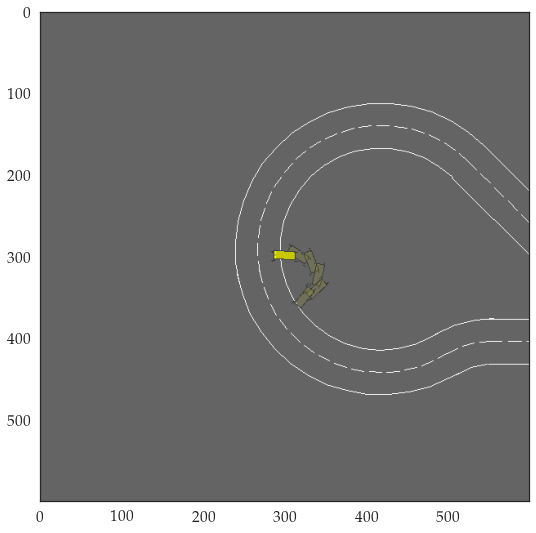

In [302]:
obs = env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render(mode='rgb_array'))
for _ in range(300):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action, _ = bc.predict(obs, deterministic=True)
    obs, _, _, _, = env.step(action)
env.close()